# Activity Recognition from Single Chest-Mounted Accelerometer

## Contents

- [Overview](#overview)
- [Data Preprocessing](#data_preprocessing)
- [Exploratory Data Analysis](#exploratory_data_analysis)
- [Feature Engineering](#feature_engineering)
- [Data Modelling](#data_modelling)
- [Evaluation](#evaluation)
- [Summary](#summary)
- [References](#references)

## Overview <a id='overview'></a>

### Project Objective

The objective of this project is to predict the human activity based on a single wearable chest-mounted accelerometer which collects the acceleration of the x-, y- and z-axis during an activity. The field human activity recognition poses various challenges such as classifying the performed activity and identifiying individuals by their specific motion patterns within the collected sensor data. However, this project focuses on the classification of the activities performed by various persons. Since the predictions outcome is of categorical datatype (classification problem), different classification models must be investigated based on defined evaluation metrics.

### Dataset

The dataset **Activity Recognition from Single Chest-Mounted Accelerometer** is provided by the **UCI Machine Learning Repository** and consists of human activities collected by a 52Hz sampling frequency of the chest-mounted accelerometer. Therefore, entirely 15 participants performed 7 activities from their daily life by labeling the performed activity for the performed timespan [1]. The considered 7 activities and their encoded labels are as follows:

- 1: Working at Computer
- 2: Standing Up, Walking and Going updown stairs
- 3: Standing
- 4: Walking
- 5: Going UpDown Stairs
- 6: Walking and Talking with Someone
- 7: Talking while Standing

The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer).

### Target Feature

The target feature is the provided encoded label which is througout this project called `activity`. The activity consists of the aforementioned 7 activities as integer encoded values and represents originally a categorical datatype. Based on this target features, the objective is to create a machine learning model which classifies the accelerometer data into the corresponding `activity`.

### Methodology

Since our project objective poses a classification problem in terms of the target feature `activity`, we search for an appropriate classification model which predicts the target feature as categorical value. Firstly, the gathered sensor data of all participants are merged into one dataset and preprocessed by considering irrelevant features, missing values and outliers. Secondly, we explore the descriptive featues and target feature in order to get an intuition about the distribtuions of each feature and the relationship among these features. Based on the data exploration, new features are created during the feature engineering process to add more meaningful descriptive features with a sliding window approach. After these steps, we create and evaluate the following machine learning models:

- Decision Tree (DT)
- K-Nearest Neighbors (KNN)

For feature selection, hyperparameter tuning and model evaluation, the dataset is splitted into a training and test set with a test-ratio of 20%. Therefore, the participants 1 to 12 represent the training set and the participants 13 to 15 the test set, respectively. In this way, we want to enable a meaningful evaluation of the generalization of the trained classification algorithms. The preprocessed training and test set are then standarized by a standard scaler which positively contributes to the model performance.

The feature selection process is conducted by training a random forest model using the training set. This trained model provides the feature importances of each descriptive feature. According to the obtained feature importances, a defined number of descriptive features with the best feature importances are selected for the following training and tuning steps. The optimal model hyperparameters are identified by applying a gridsearch for each model in a stratified 5-fold cross-validation fashion using the f1 score as scoring function. Subsequently the classification models and their optimal hyperparamters are trained again on the entire training set. Lastly, the models are compared in terms of the f1 score and confusion matrix by using the "unseen" test set.

## Data Preprocessing <a id='data_preprocessing'></a>

In [1]:
import os
import random
import warnings
warnings.filterwarnings('ignore') # Ignore warnings for readability

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # Display all columns of DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer

In [3]:
seed = 999 # For reproducibility
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)

### Loading Dataset

As first step, we want to load the dataset which consists of 15 csv-files whereby each csv-file represents the collected data from one participant. Since we want to test our developed model with "unseen" data, it is necessary to split the dataset into a train and test set. Therefore, we split the participants with a test-ratio of 20% by allocating the participants 1 to 12 to the train set and 13 to 15 to the test set.

In [4]:
train_filenames = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
test_filenames = ['13', '14', '15']

columns = ['x_acceleration', 'y_acceleration', 'z_acceleration', 'activity']

In [5]:
participants = [pd.read_csv('data/' + filename + '.csv', names=columns, index_col=0) 
                for filename in (train_filenames + test_filenames)]

Let's have a look at the dataset shape of each participant and then concatenate all participants to one entire dataset for easier preprocessing and exploration.

In [6]:
for i, participant in enumerate(participants):
    print('Participant ', i+1, ':', participant.shape)

Participant  1 : (162501, 4)
Participant  2 : (138001, 4)
Participant  3 : (102341, 4)
Participant  4 : (122201, 4)
Participant  5 : (160001, 4)
Participant  6 : (140901, 4)
Participant  7 : (163001, 4)
Participant  8 : (138001, 4)
Participant  9 : (166741, 4)
Participant  10 : (126801, 4)
Participant  11 : (104451, 4)
Participant  12 : (114702, 4)
Participant  13 : (67651, 4)
Participant  14 : (116101, 4)
Participant  15 : (103501, 4)


In [7]:
participants[0].head()

x_acceleration  y_acceleration  z_acceleration  activity
0.0            1502            2215            2153         1
1.0            1667            2072            2047         1
2.0            1611            1957            1906         1
3.0            1601            1939            1831         1
4.0            1643            1965            1879         1

In [8]:
df_all = pd.DataFrame()
for i, participant in enumerate(participants):
    data = participant.copy()
    data['participant'] = i + 1
    df_all = df_all.append(data)
    
df_all.shape

(1926896, 5)

In [9]:
df_all.head()

x_acceleration  y_acceleration  z_acceleration  activity  participant
0.0            1502            2215            2153         1            1
1.0            1667            2072            2047         1            1
2.0            1611            1957            1906         1            1
3.0            1601            1939            1831         1            1
4.0            1643            1965            1879         1            1

### Check Datatypes & Handling Missing and Invalid Values

As next step, we check the datatypes of all columns to ensure if the loaded dataset represents the original source based on the description. The features x acceleration, y acceleration, z acceleration and activity must be of numerical datatype.

In [10]:
df_all.dtypes

x_acceleration    int64
y_acceleration    int64
z_acceleration    int64
activity          int64
participant       int64
dtype: object

The loaded dataset has the expected datatypes for both the descriptive features and target feature. Subsequently, we check if any missing values of the type `nan` are present.

In [11]:
df_all.isnull().sum()

x_acceleration    0
y_acceleration    0
z_acceleration    0
activity          0
participant       0
dtype: int64

Since no missing values of the type `nan` are present, we don't must apply any imputing or removing of observations at this point. Besides obviously missing values of the type `nan`, there also can be values which indicate missing values such as `-1` or `9999`. These values can be recognized by descriptive statistics, investigating unique values and data exploration. Let's check the target feature by looking at the unique values.

In [12]:
df_all['activity'].unique()

array([1, 2, 3, 4, 5, 6, 7, 0], dtype=int64)

In [13]:
df_all['activity'].value_counts(normalize=True).multiply(100).round(2)

1    31.59
7    30.80
4    18.53
3    11.25
5     2.67
2     2.48
6     2.48
0     0.19
Name: activity, dtype: float64

We can see that the target feature contains the value 0 to 7. According to the dataset description, we can observe that the activities must be only codified as the numbers 1 to 7. Since only seven activities should be present, we assume the level 0 as an invalid or missing value. Hence, we remove all observations with the activity level 0 from the dataset.

In [14]:
df_all = df_all[df_all['activity'] != 0]
df_all.shape

(1923177, 5)

After removing the obvious missing values, other anomalies such as outliers and invalid values can be investigated by using descriptive statistics. Thereby, we are interessted into the three acceleration features (x-, y- and z-axis).

In [15]:
df_all.describe().round(2)

x_acceleration  y_acceleration  z_acceleration    activity  participant
count      1923177.00      1923177.00      1923177.00  1923177.00   1923177.00
mean          1987.48         2382.30         1970.49        3.89         7.51
std            111.34          100.21           94.49        2.44         4.18
min            282.00            2.00            1.00        1.00         1.00
25%           1904.00         2337.00         1918.00        1.00         4.00
50%           1992.00         2367.00         1988.00        4.00         7.00
75%           2076.00         2412.00         2032.00        7.00        11.00
max           3828.00         4095.00         4095.00        7.00        15.00

Almost each value of the descriptive features seems to be valid and we don't expect more missing or invalid values within the dataset. However, the minimum and maximum values of the acceleration features are suspicious since they represent very low and high values in comparison with the quartiles.

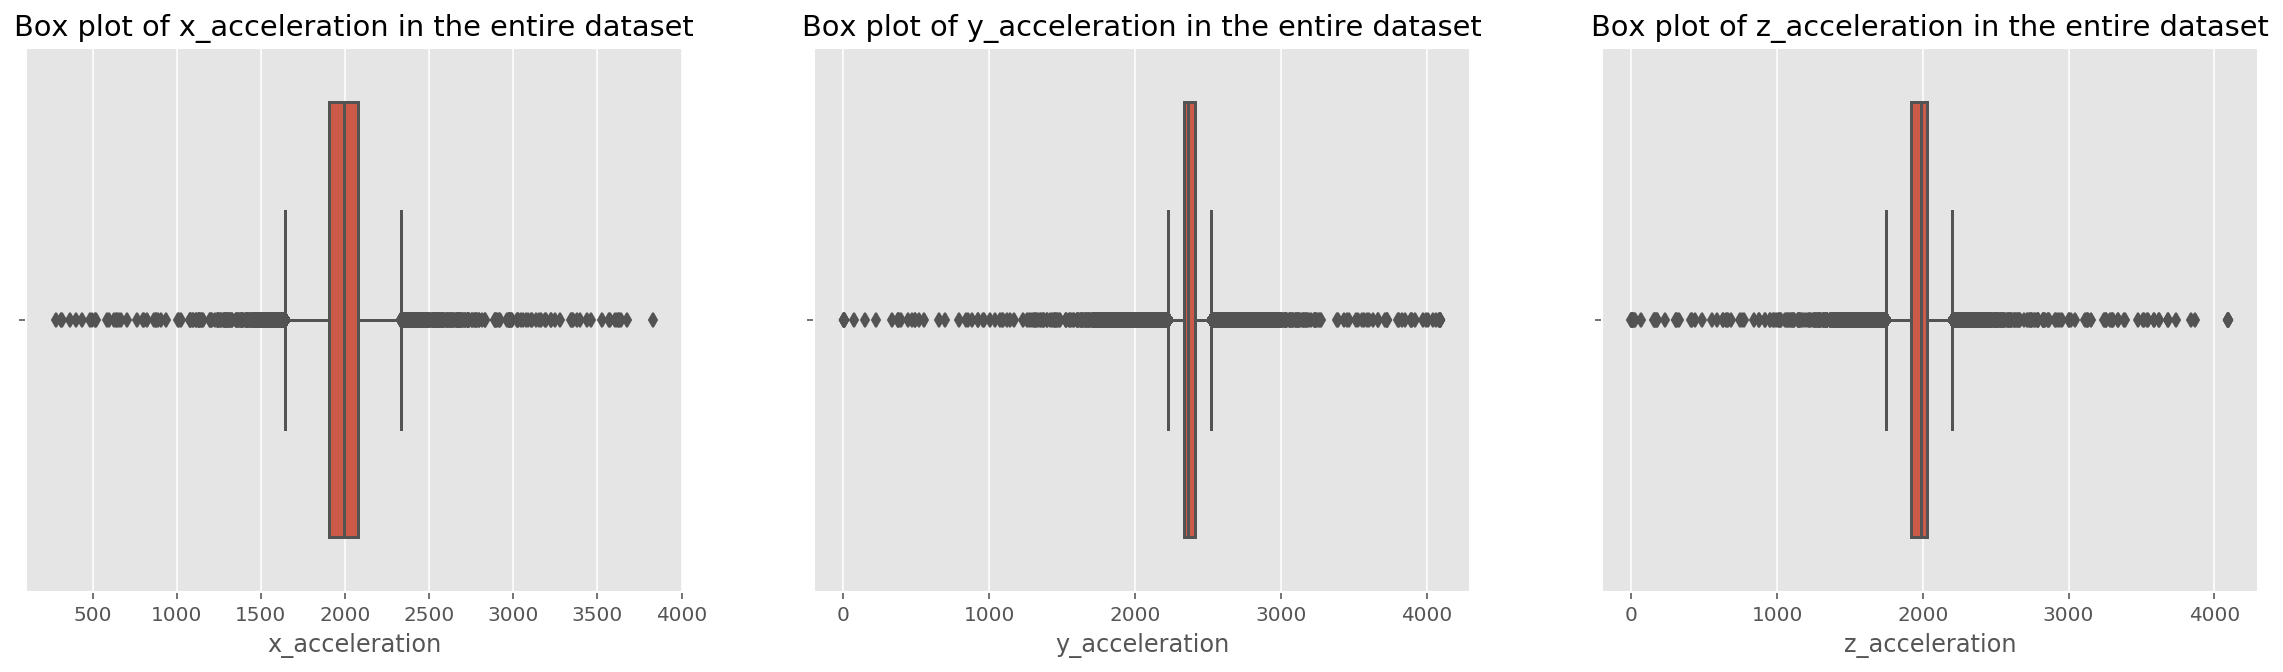

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs[0].set_title('Box plot of x_acceleration in the entire dataset')
sns.boxplot(x=df_all['x_acceleration'], ax=axs[0])
axs[1].set_title('Box plot of y_acceleration in the entire dataset')
sns.boxplot(x=df_all['y_acceleration'], ax=axs[1])
axs[2].set_title('Box plot of z_acceleration in the entire dataset')
sns.boxplot(x=df_all['z_acceleration'], ax=axs[2])
plt.show()

Based on the box plots, we can see a high variance in the descriptive features which might be caused by the different motion patterns and activities of the various participants. Futhermore, the activities 2, 5 and 6 are mincority classes (each ~2.5% of the entire dataset) which can also lead to this apparent outliers. Hence, we don't remove those outliers at this point and standardize the dataset before the training of the machine learning model.

## Exploratory Data Analysis <a id='exploratory_data_analysis'></a>

In this section, the exploration of both the descriptive features and target feature takes place. Therefore, we examine the features `x_acceleration`, `y_acceleration`, `z_acceleration` and `activity` as well as the interactions among these features. Since sensor-based human activities represents sequences of sensor data for each activity, we should also have a look at the sequential number dimension to get an comprehend intuition about the data.

### Helper Methods

In [17]:
def label_to_activity(label = 0):
    mapping = {1: 'Working at Computer', 2: 'Standing Up, Walking and Going updown stairs', 
               3: 'Standing', 4: 'Walking', 5: 'Going UpDown Stairs', 
               6: 'Walking and Talking with Someone', 7: 'Talking while Standing',}
    return mapping[label]

In [18]:
def plot_activities_distribution(activities):
    fig, ax = plt.subplots()
    ax.set_title('Frequency of activities in entire dataset')
    ax.set_xlabel('activity')
    ax.set_ylabel('frequency')
    sns.distplot(activities, kde=False, ax=ax)
    plt.show()

In [19]:
def plot_acceleration_distribution(data, acceleration='x_acceleration'):
    fig, ax = plt.subplots()
    ax.set_title('Distribution of ' + acceleration + ' in entire dataset')
    ax.set_xlabel(acceleration)
    ax.set_ylabel('probability')
    sns.distplot(data[acceleration], ax=ax)
    plt.show()

In [20]:
# Reference: Adapted from [2]
def plot_participant(data, participant_num=1):
    participant = data[data['participant'] == participant_num].drop('participant', axis=1)
    for col in participant.columns:      
        fig, ax = plt.subplots(figsize=(20,5))
        ax.set_title(col + ' of participant ' + str(participant_num))
        ax.set_xlabel('sequential number')
        sns.lineplot(x=participant.index, y=col, data=participant, ax=ax)
        plt.show()

In [21]:
def plot_activities(data, participant_num=1):
    participant = data[data['participant'] == participant_num].drop('participant', axis=1)
    for activity, group in participant.groupby('activity'):
        fig, ax = plt.subplots(figsize=(20,5))
        ax.set_title(label_to_activity(activity) + ' of participant ' + str(participant_num))
        ax.set_xlabel('sequential number')
        sns.lineplot(x=group.index, y='x_acceleration', data=group, ax=ax)
        plt.show()

In [22]:
def plot_activity_participants_timespan(data, participants, activity=1, feature='x_acceleration', start=0, stop=4000):
    for participant in participants:
        participant_df = data[data['participant'] == int(participant)]
        participant_df = participant_df[participant_df['activity'] == activity]
        fig, ax = plt.subplots(figsize=(20,5))
        ax.set_title(label_to_activity(activity) + ' of participant ' + str(participant))
        ax.set_xlabel('sequential number')
        sns.lineplot(x=participant_df[start:stop].index, y=feature, data=participant_df[start:stop], ax=ax)
        plt.show()        

In [23]:
def plot_continuous_pair(x, y, hue, data):
    fig, ax = plt.subplots()
    ax.set_title('Relationship of ' + x + ' and ' + y + ' coloured by ' + hue)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    sns.scatterplot(x=x, y=y, hue=hue, legend='full', data=data, ax=ax, palette='Spectral')
    ax.legend(bbox_to_anchor=(1, 1), 
              facecolor="white", 
              frameon=False)
    plt.show()

In [24]:
def plot_accelerations_activities_violin(x, y, hue, data):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title('Distributions of accelerations per activity')
    ax.set_xlabel('activity')
    ax.set_ylabel('frequency')
    sns.violinplot(x=x, y=y, hue=hue, data=data, ax=ax)
    ax.legend(bbox_to_anchor=(1, 1), 
              facecolor="white", 
              frameon=False)
    plt.show()   

### Data Exploration

Let's visualize the distributions of the various features. We already know, that the activities 2, 5 and 6 are in minority and lead to an imbalanced dataset which can negatively influence the performance of the activity classification. Moreover, at the descriptive features are "outliers" present which we must take into account at the data modelling by standardizing these features.

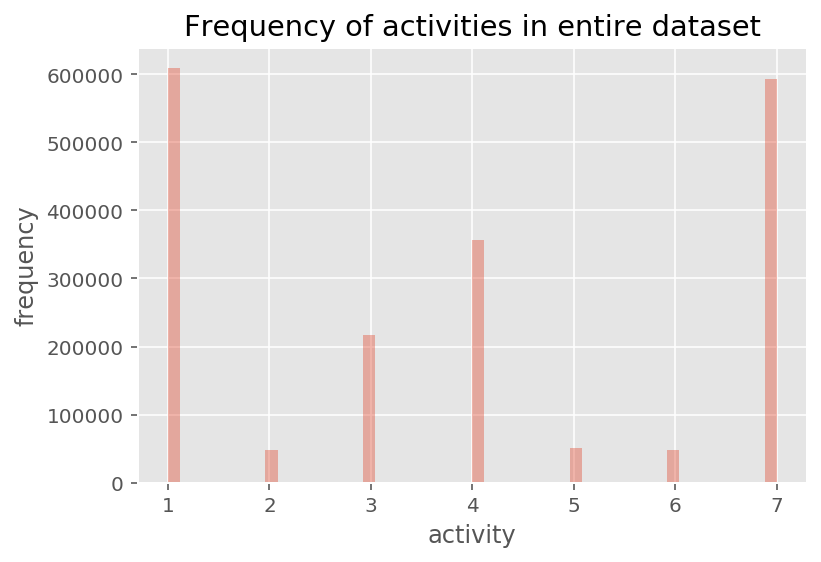

In [25]:
plot_activities_distribution(df_all['activity'])

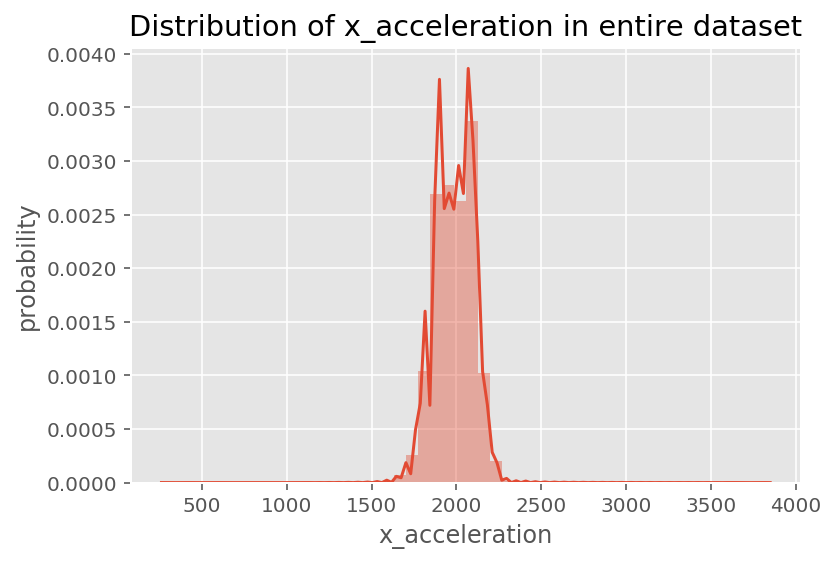

In [26]:
plot_acceleration_distribution(df_all, 'x_acceleration')

In [27]:
print('x_acceleration skewness:', df_all['x_acceleration'].skew().round(3))
print('x_acceleration kurtosis:', df_all['x_acceleration'].kurtosis().round(3))

x_acceleration skewness: -0.186
x_acceleration kurtosis: 0.586


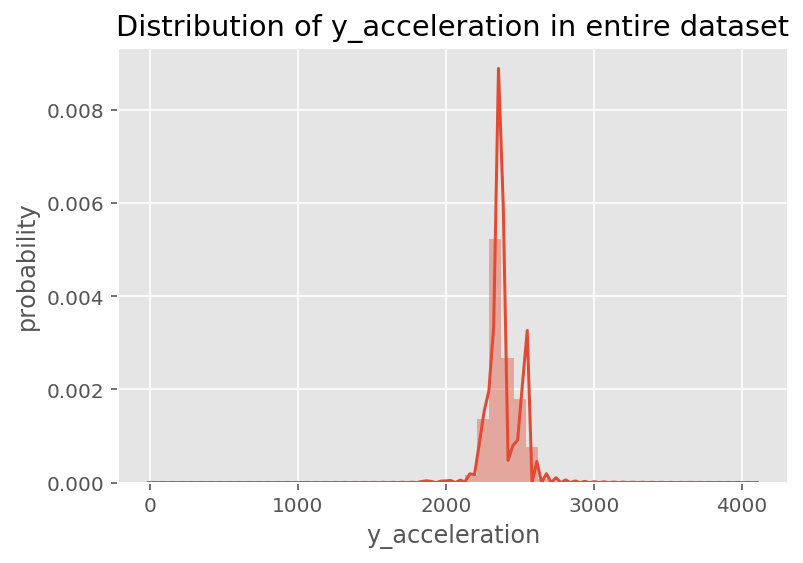

In [28]:
plot_acceleration_distribution(df_all,'y_acceleration')

In [29]:
print('y_acceleration skewness:', df_all['y_acceleration'].skew().round(3))
print('y_acceleration kurtosis:', df_all['y_acceleration'].kurtosis().round(3))

y_acceleration skewness: -0.126
y_acceleration kurtosis: 6.964


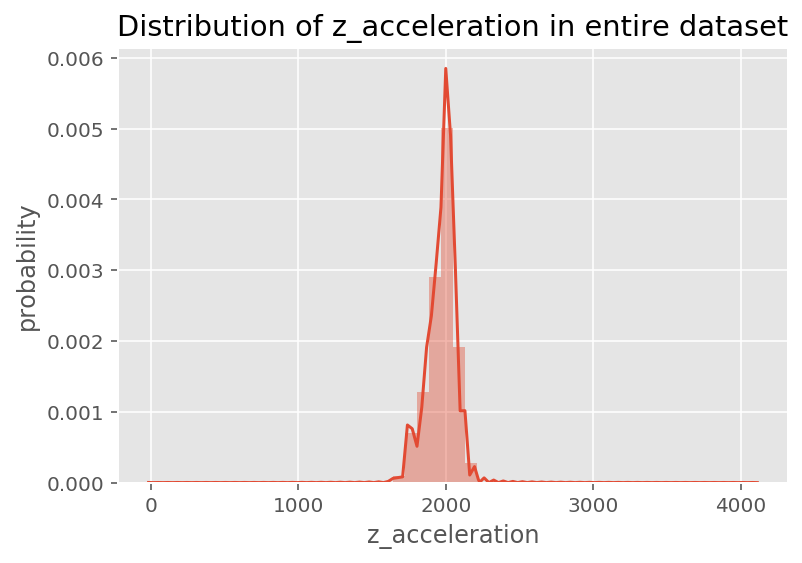

In [30]:
plot_acceleration_distribution(df_all, 'z_acceleration')

In [31]:
print('z_acceleration skewness:', df_all['z_acceleration'].skew().round(3))
print('z_acceleration kurtosis:', df_all['z_acceleration'].kurtosis().round(3))

z_acceleration skewness: -0.674
z_acceleration kurtosis: 6.012


We can see that the distributions are affected by the outliers at the interval x < 1500 and x > 2500. A lot of machine learning models assume a normal distribution of the features so we could improve the classification model by transform these features with a specific function such as the log transformation. However, these distributions are only moderately skewed so we don't apply a transformation. The high kurtosis of `y_acceleration` and `z_acceleration` is due to the present outliers.

Let's visualize one acceleration feature of all activities of two participants (1 and 2) over time (sequential numbers).

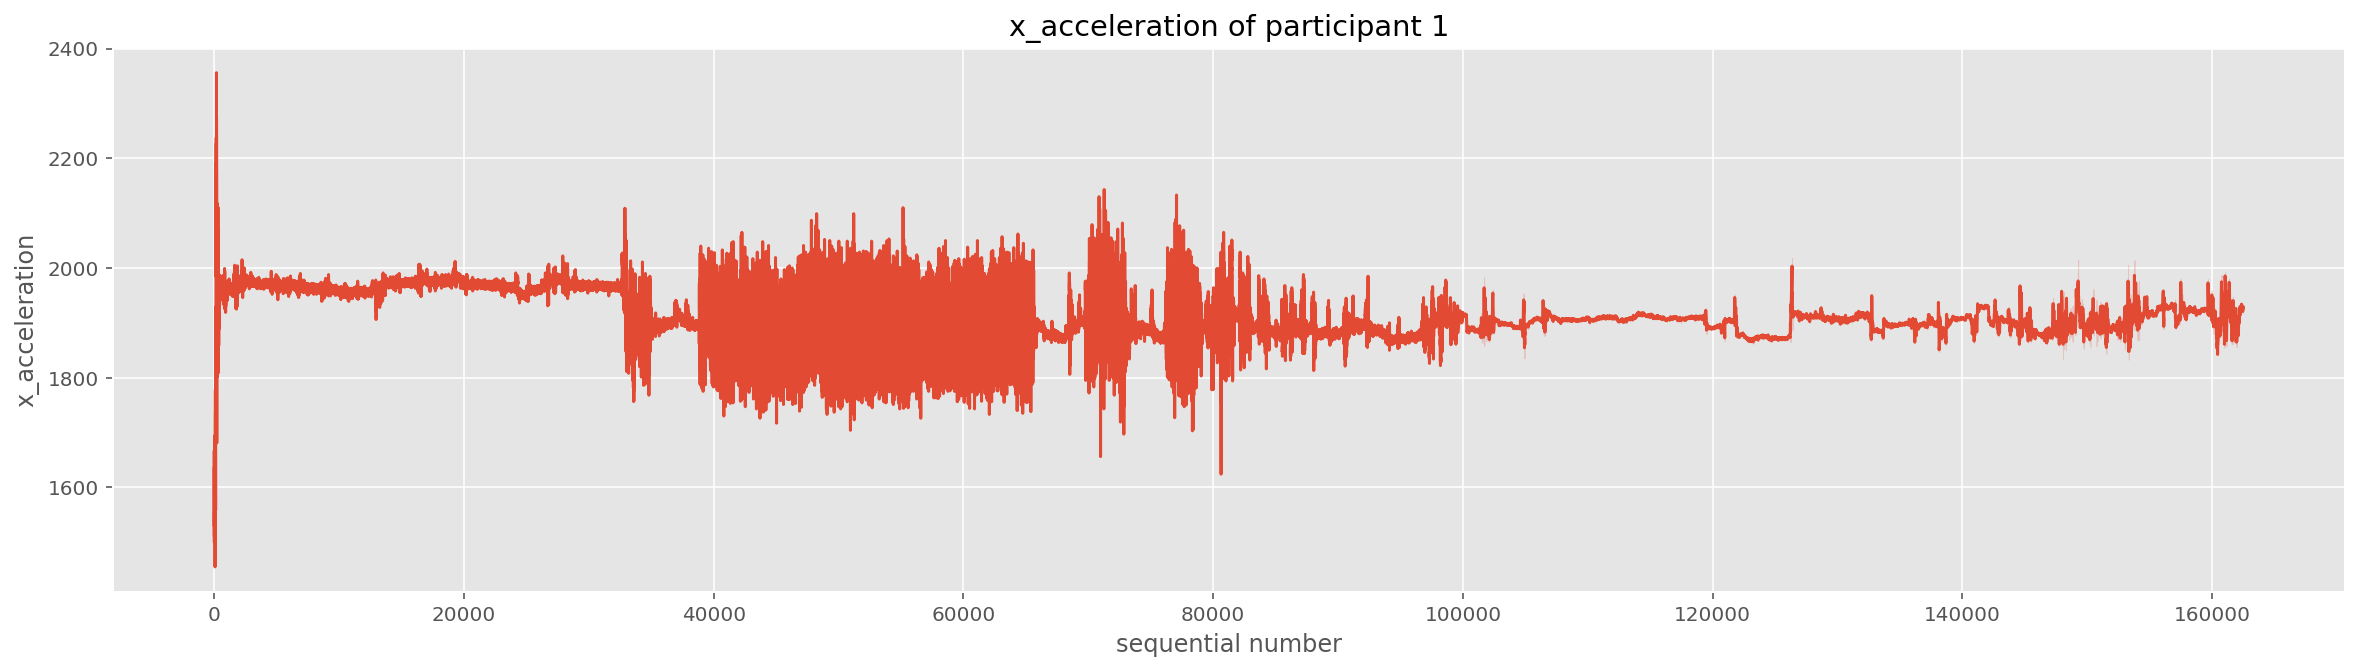

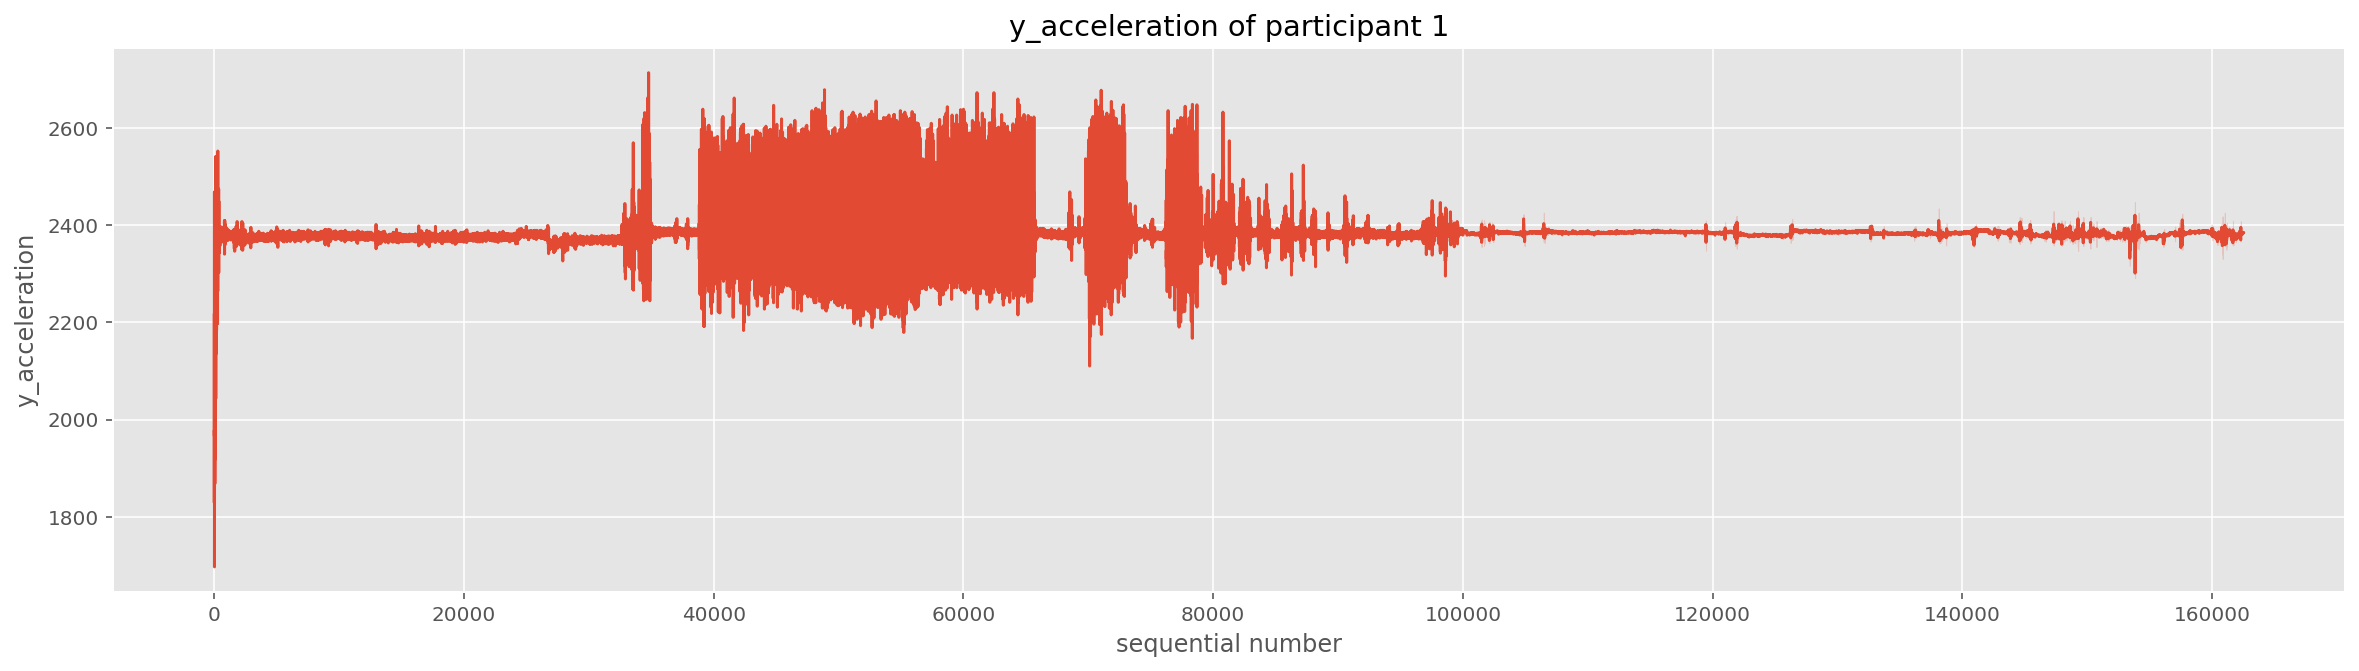

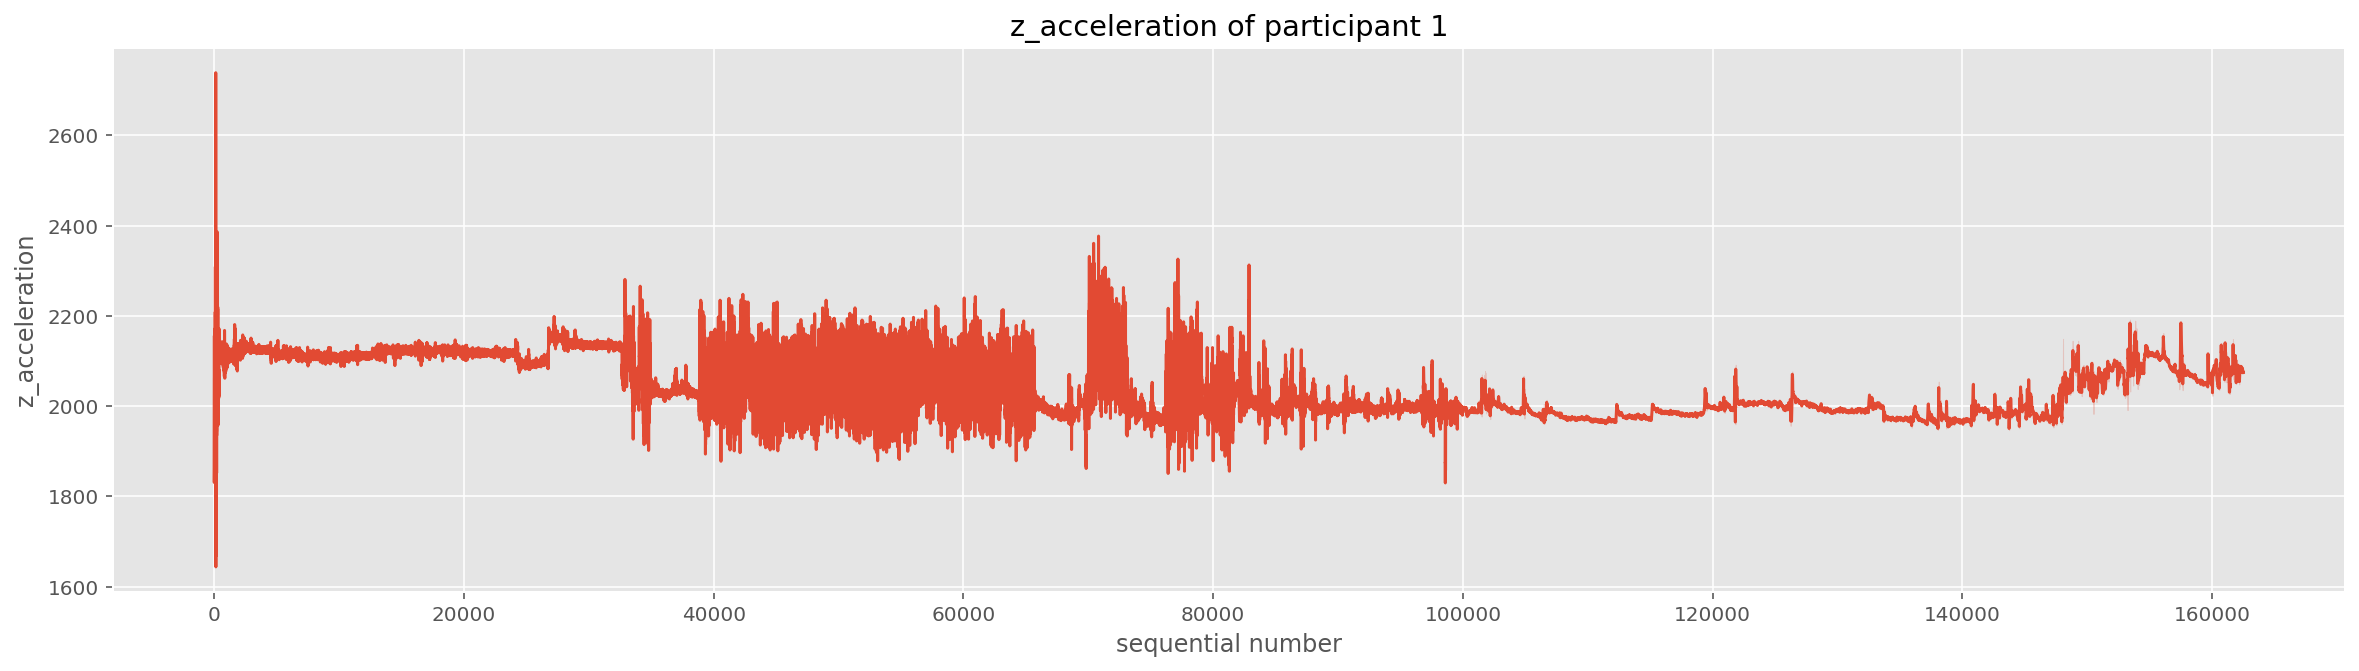

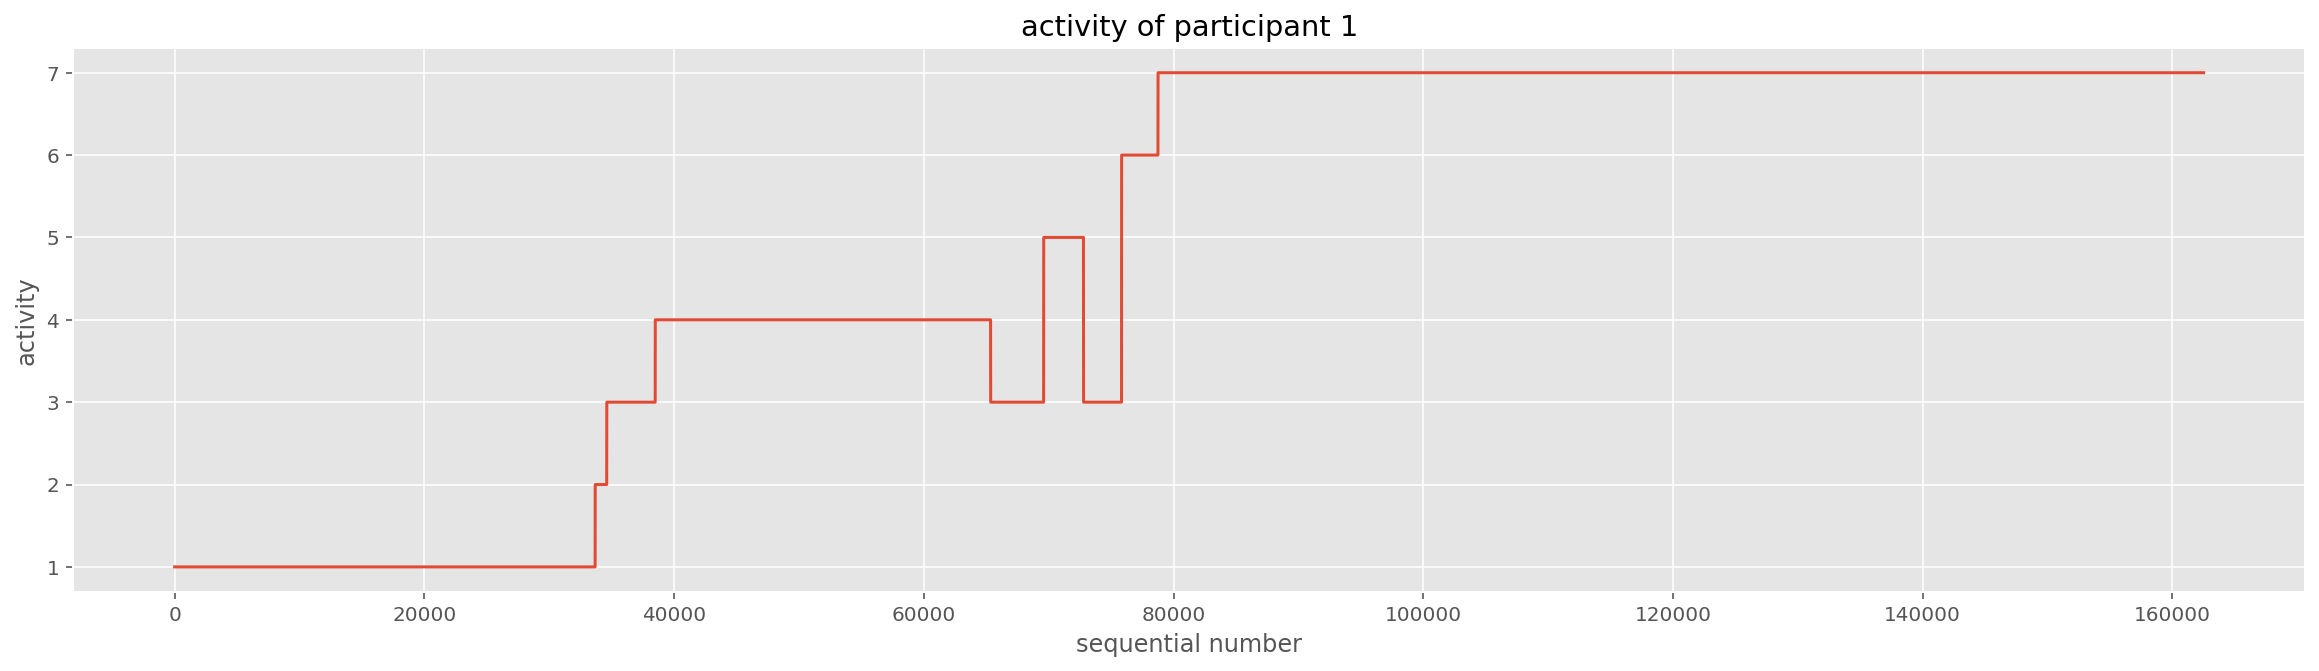

In [32]:
plot_participant(df_all, 1)

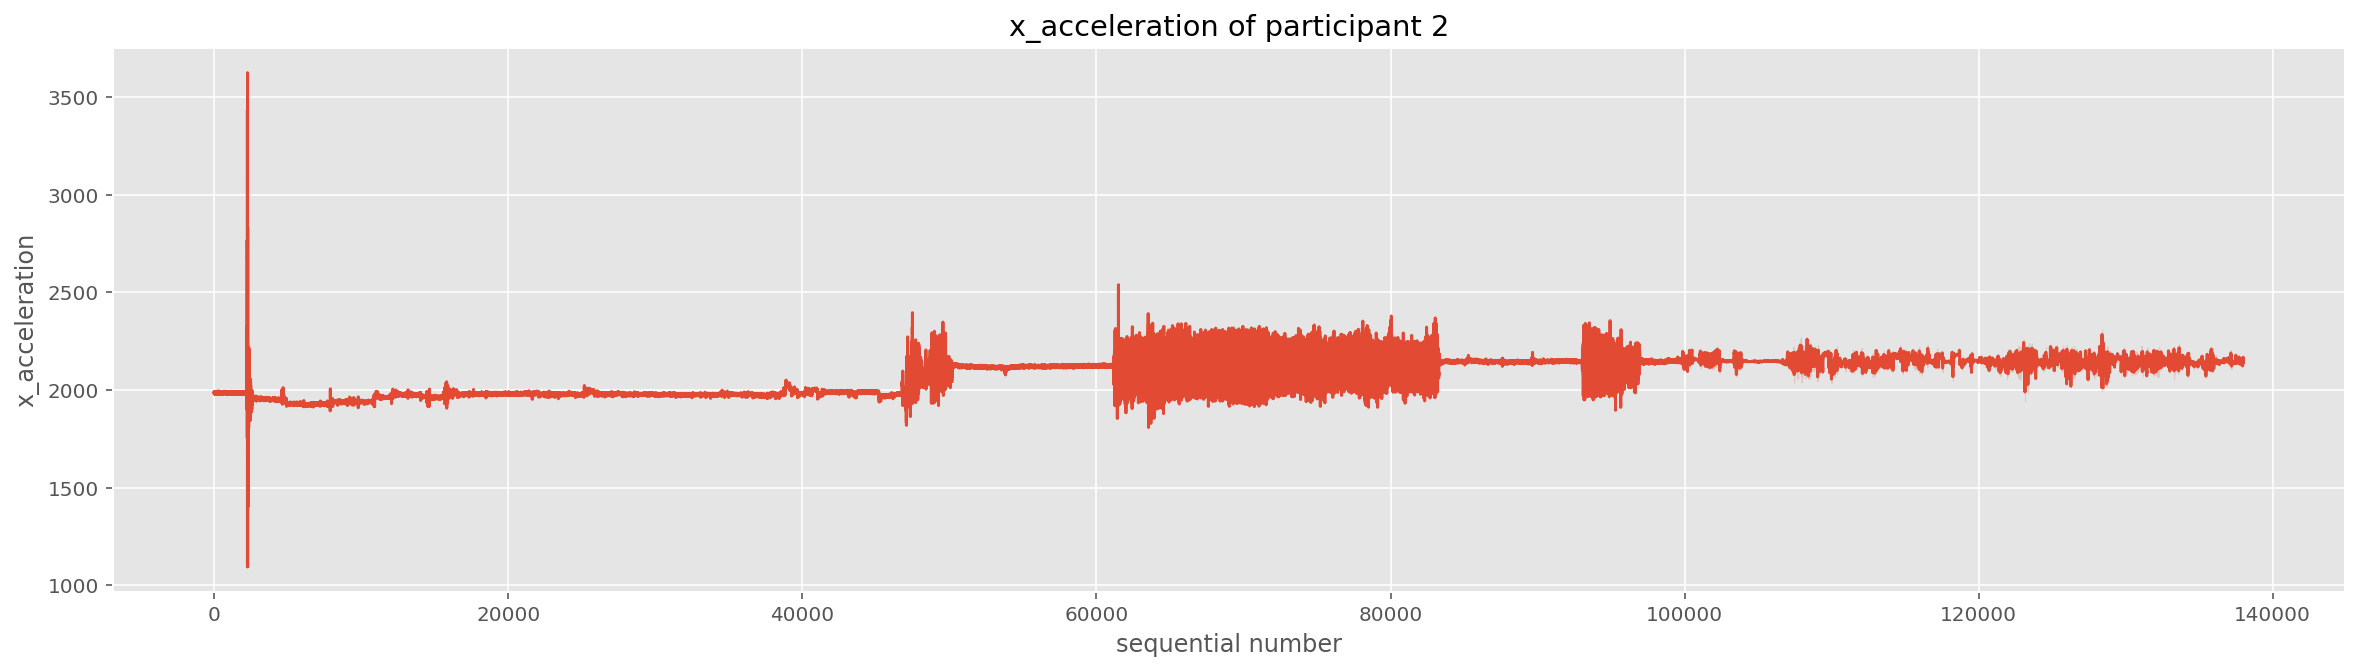

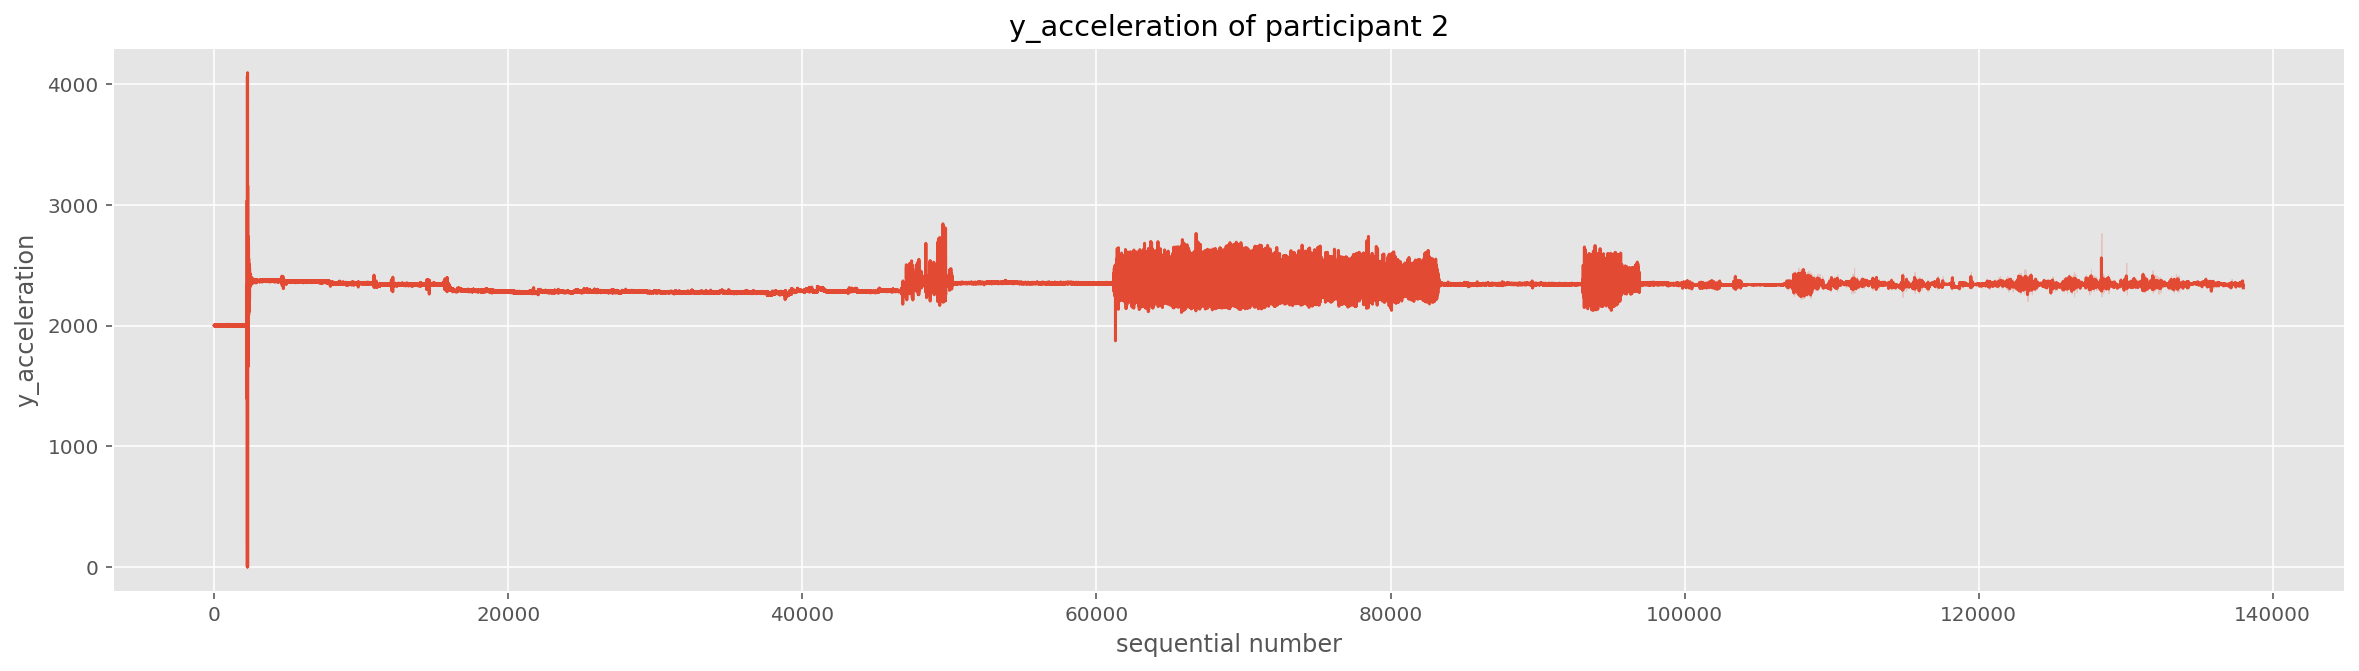

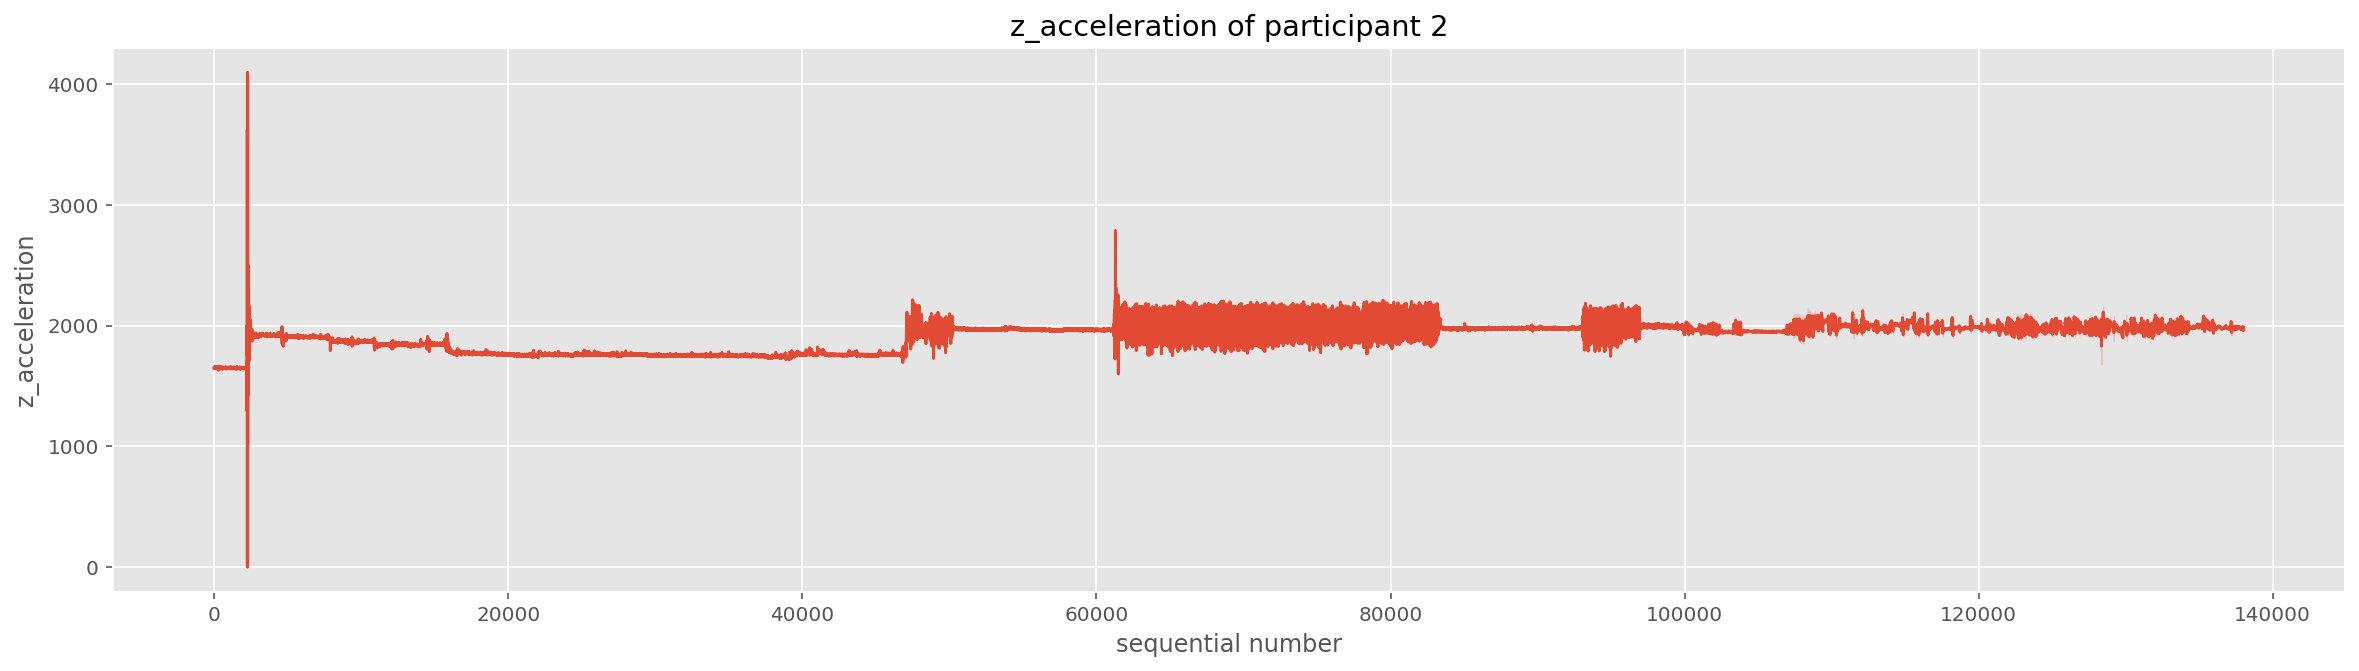

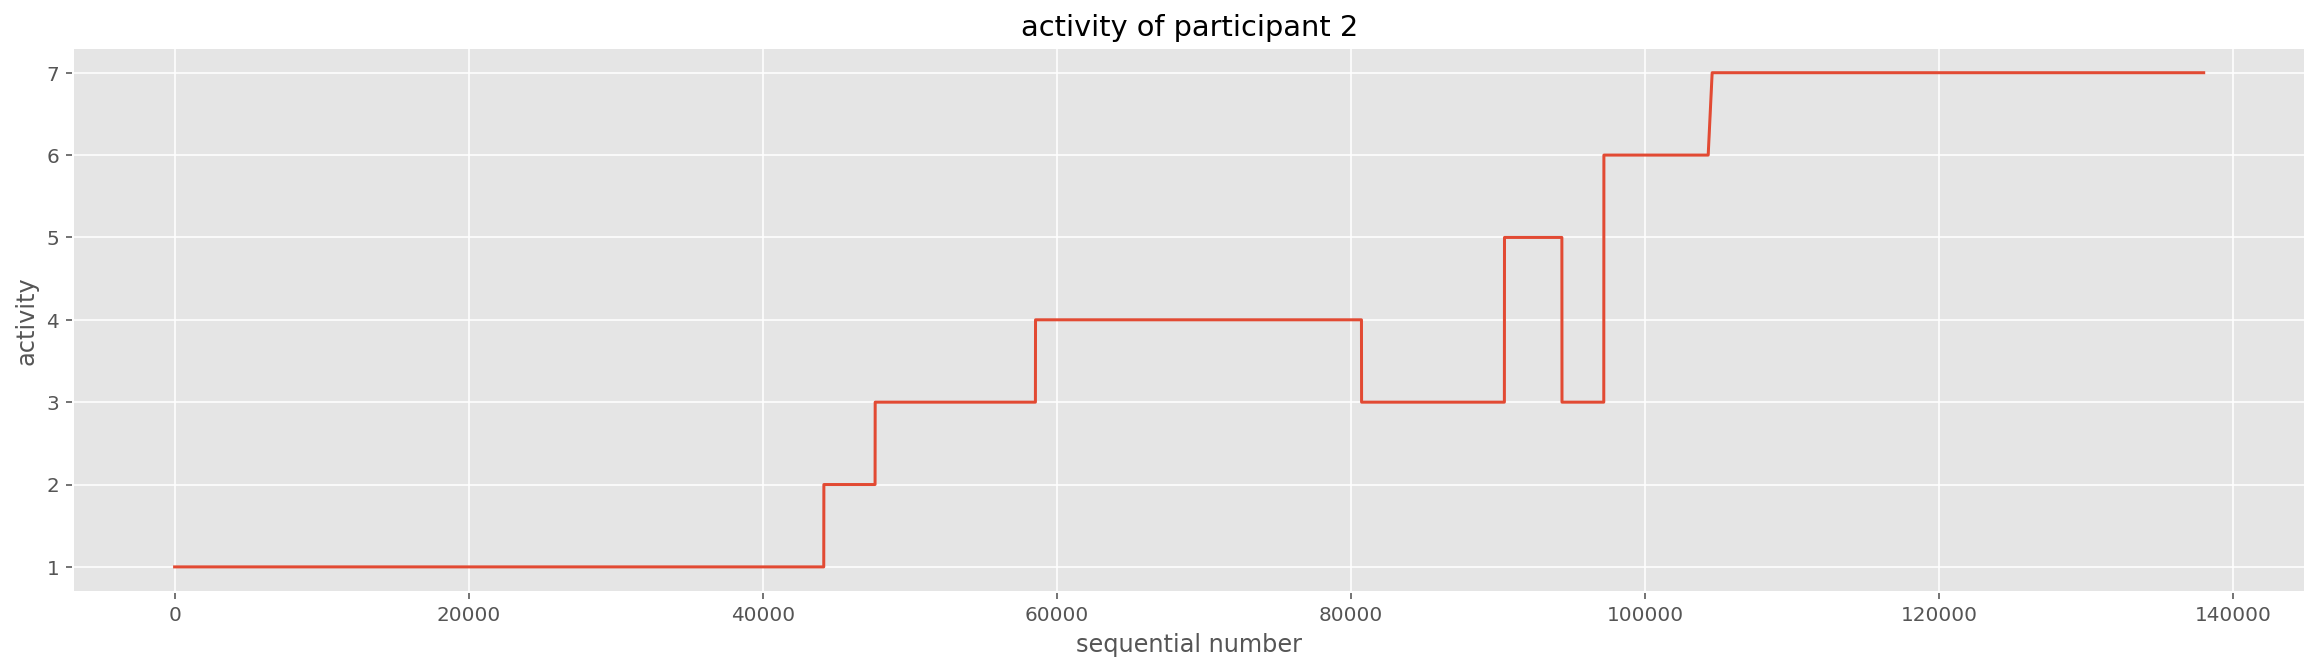

In [33]:
plot_participant(df_all, 2)

As next step, let's have a look at each activity of one participant separately by visualizing all seven activities over time.

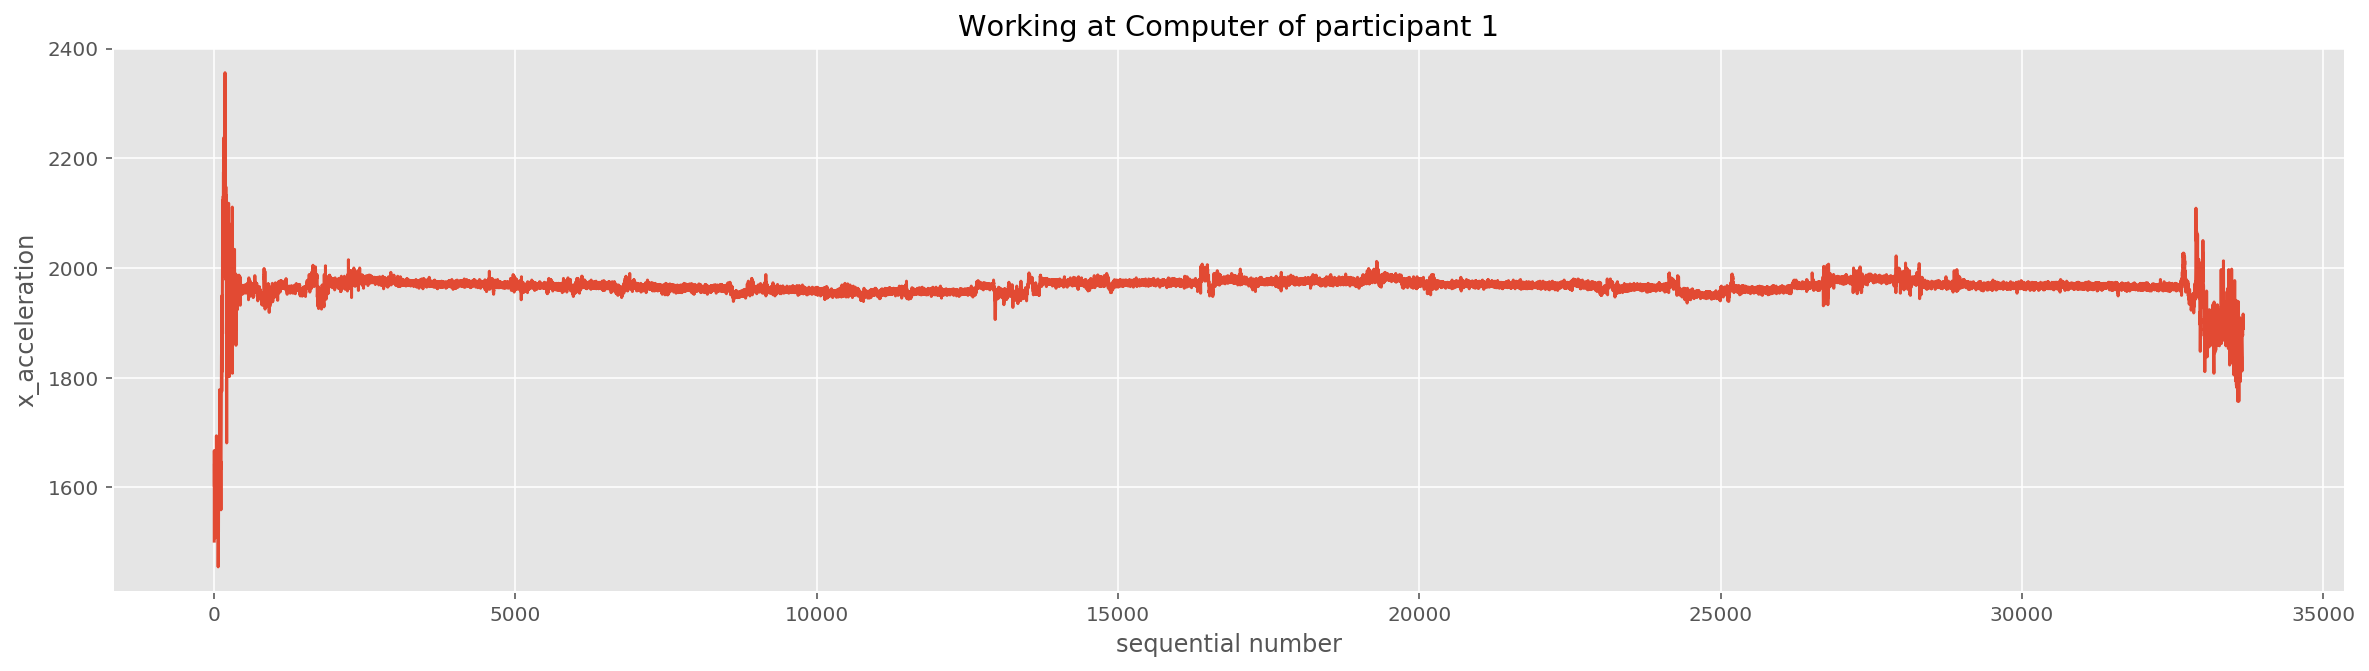

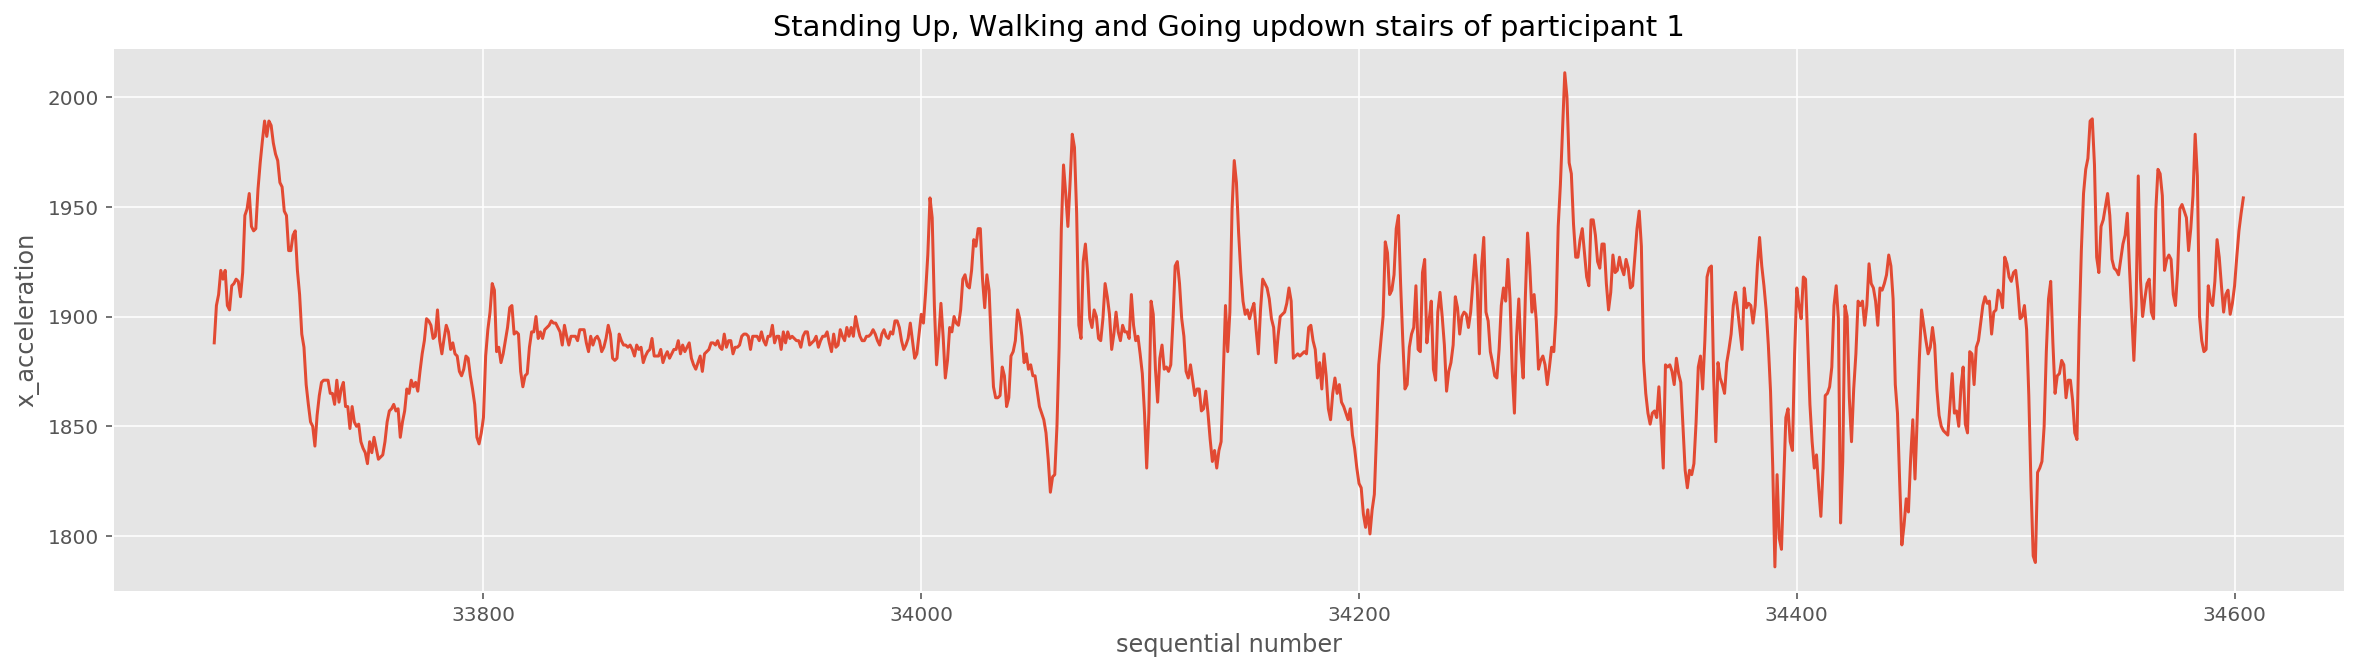

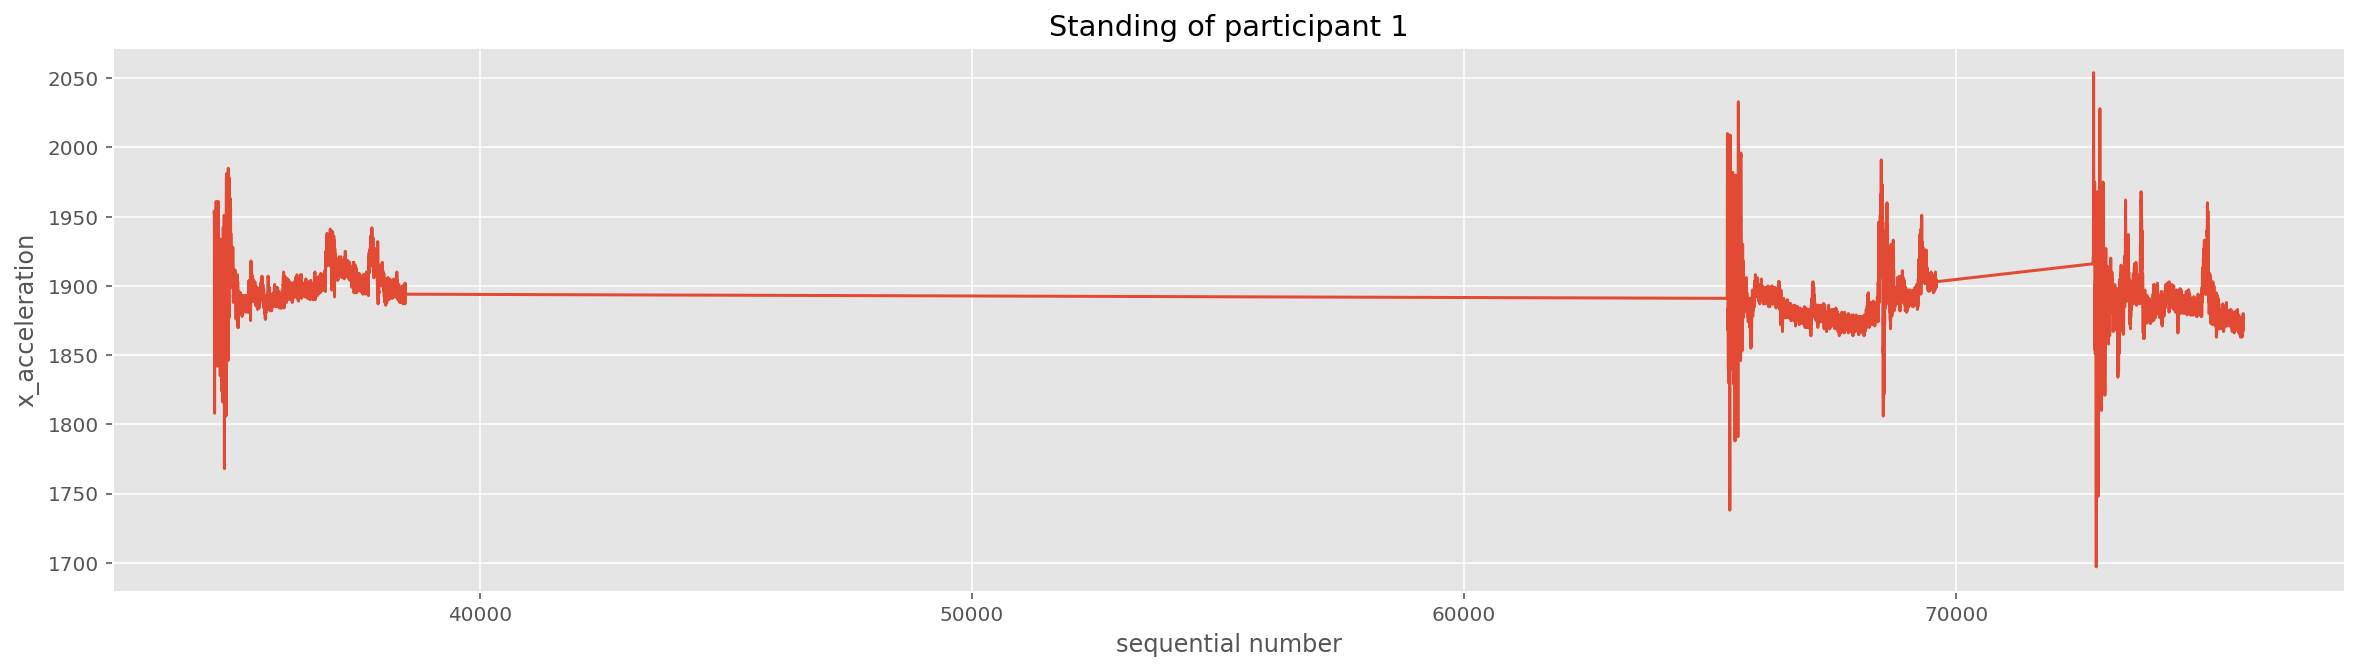

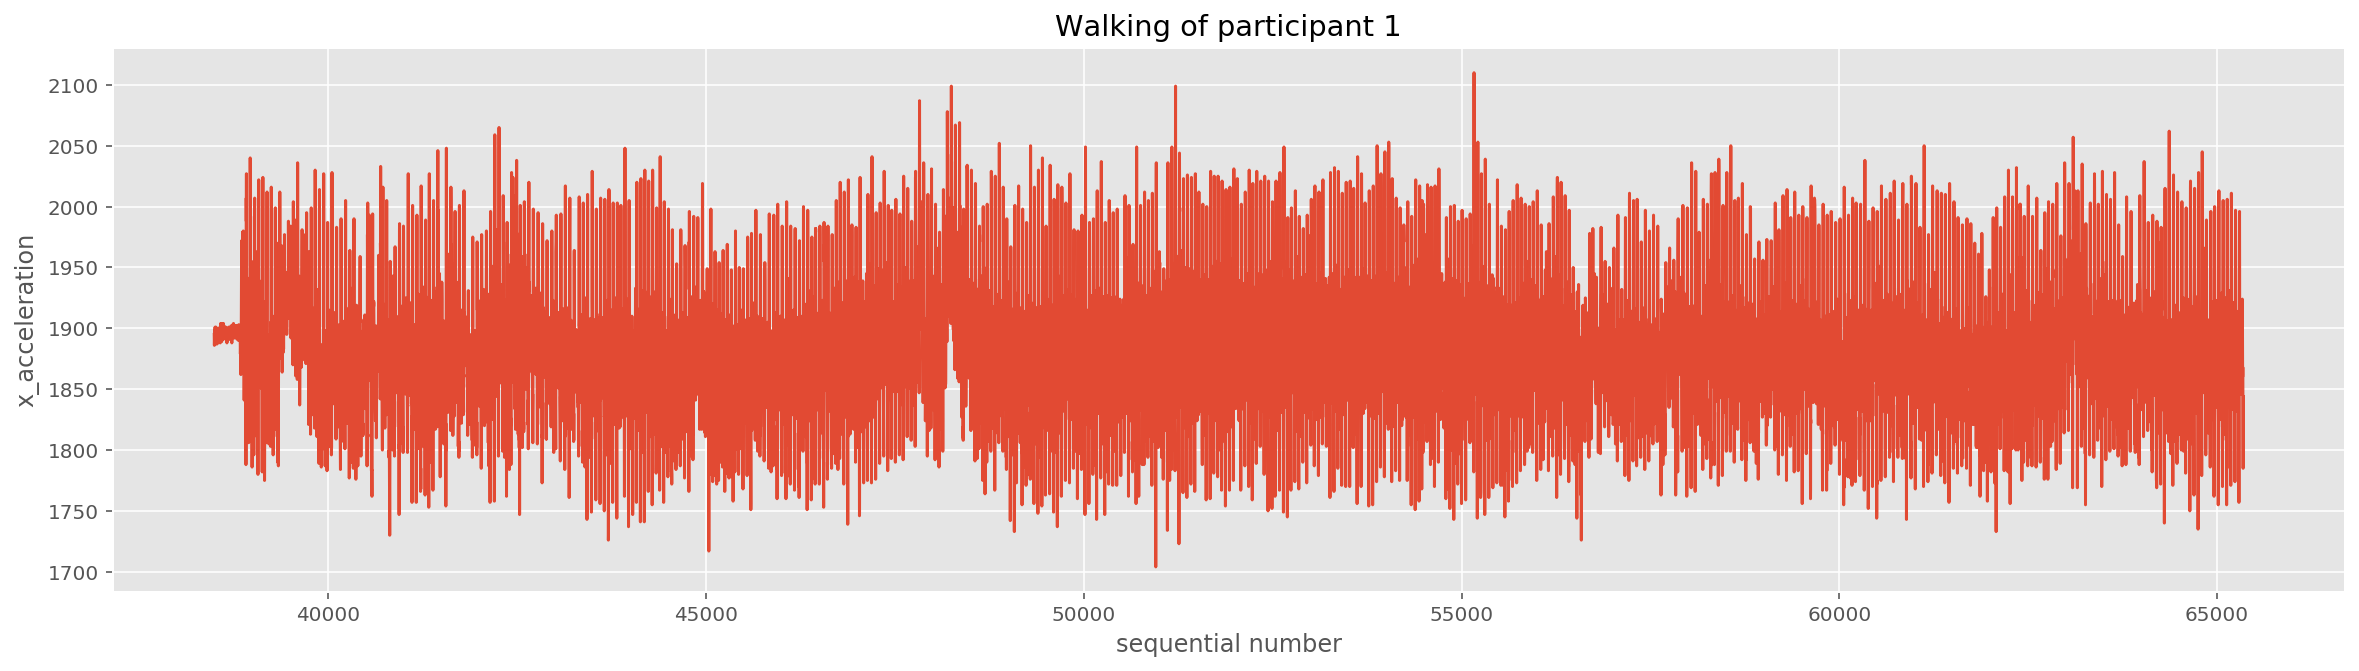

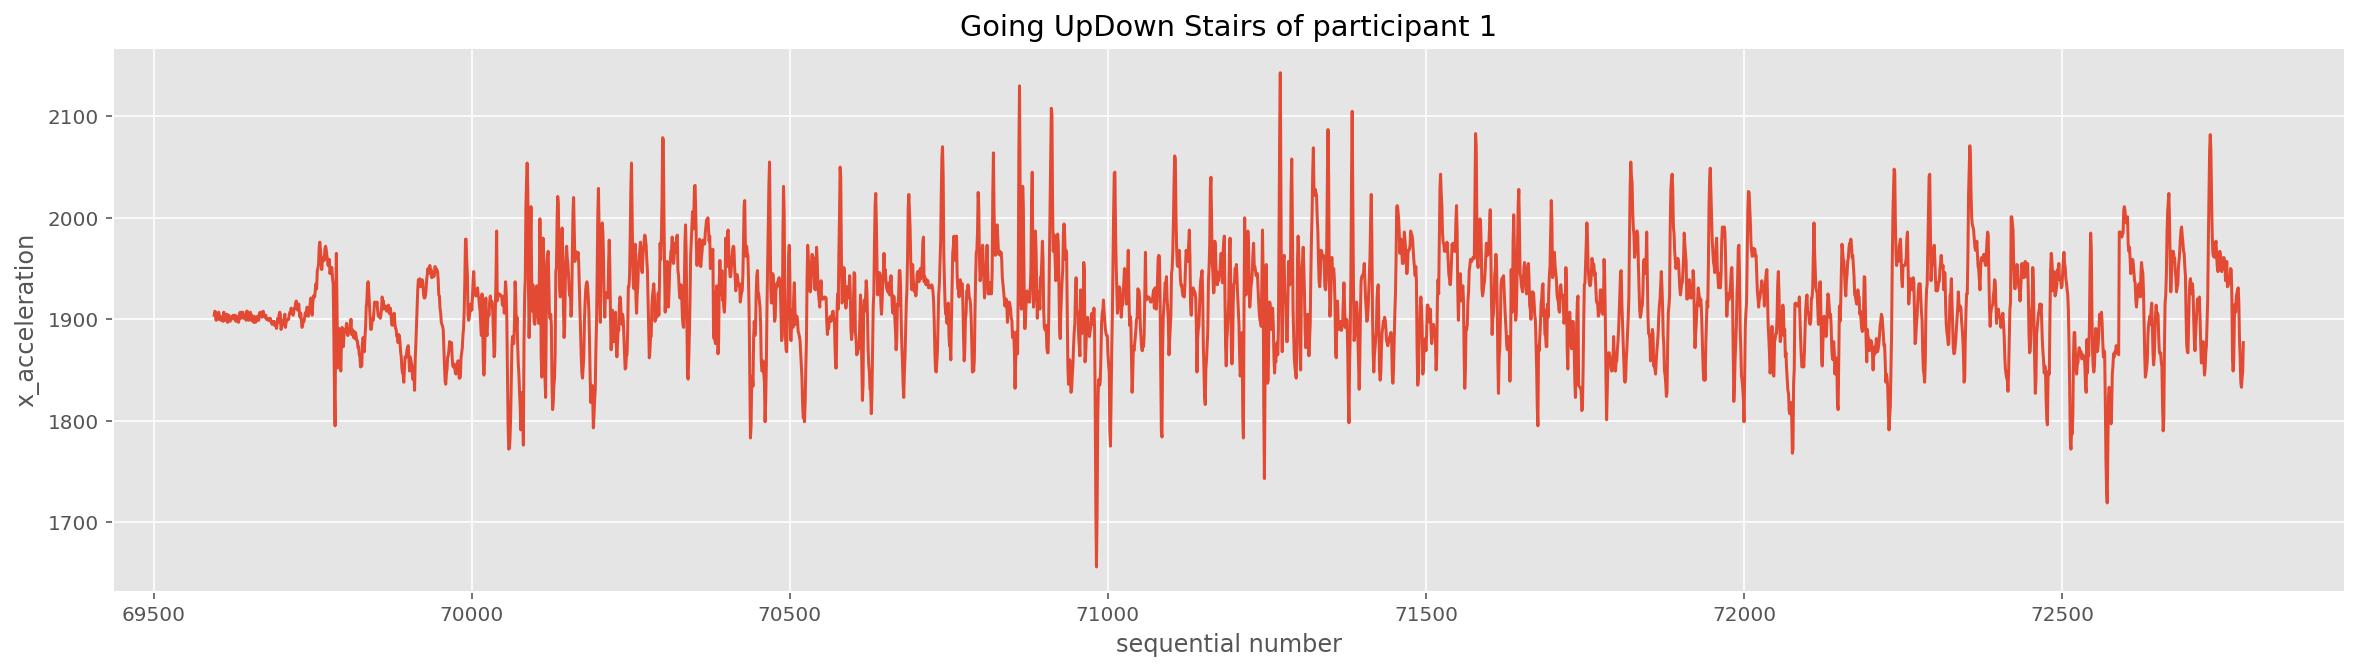

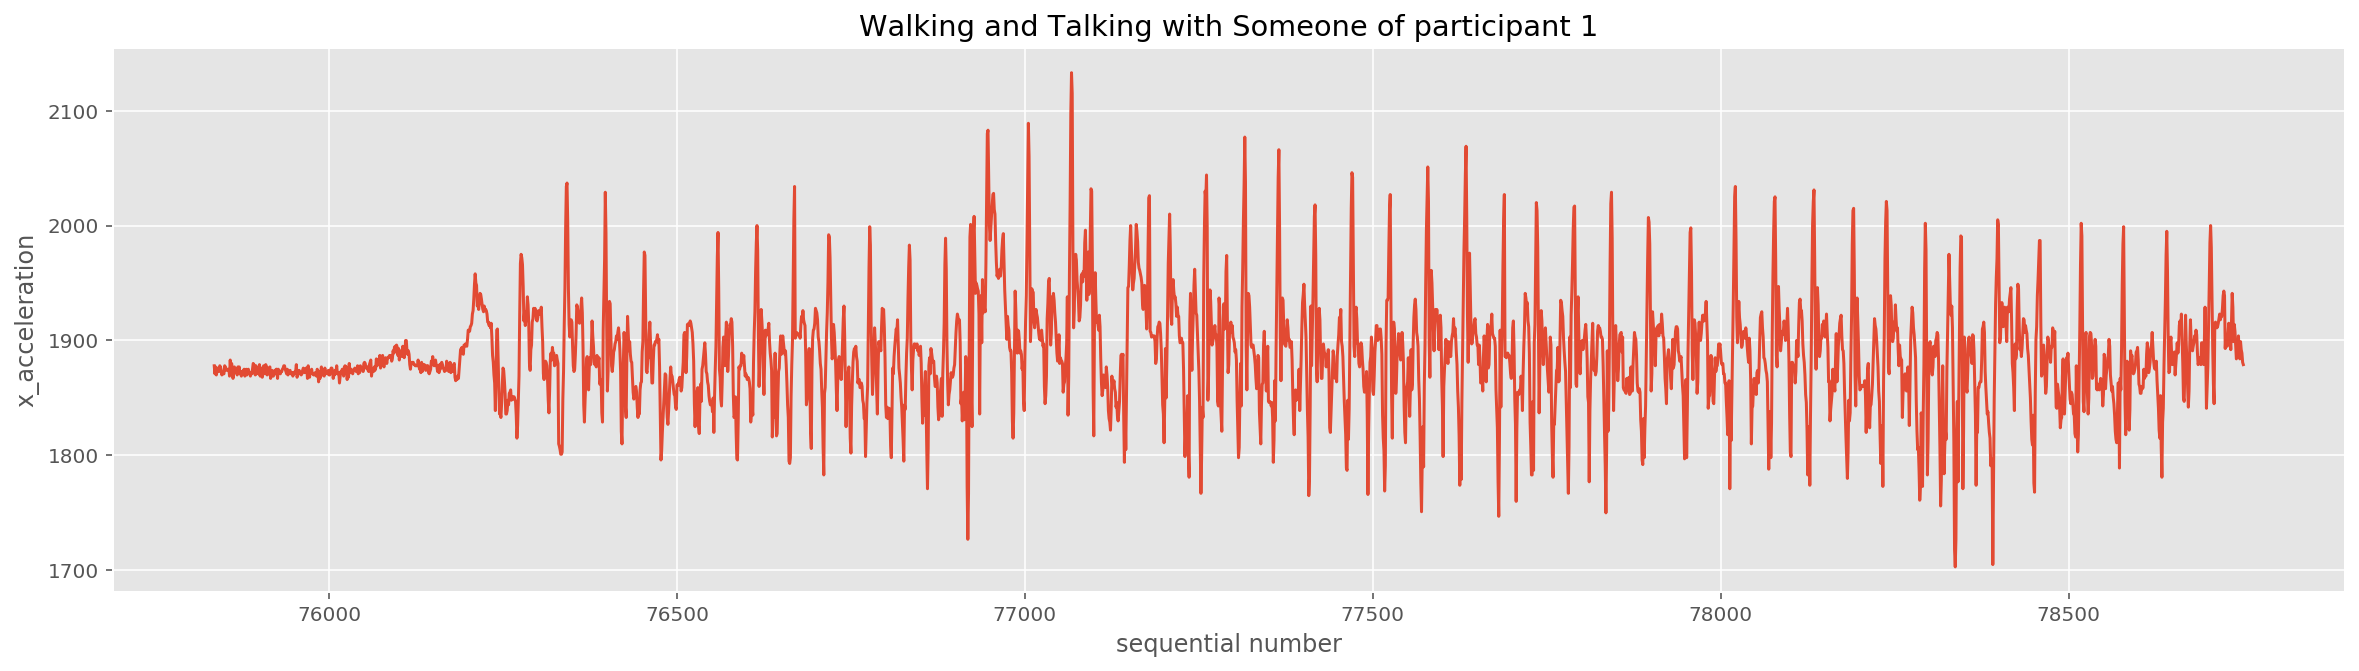

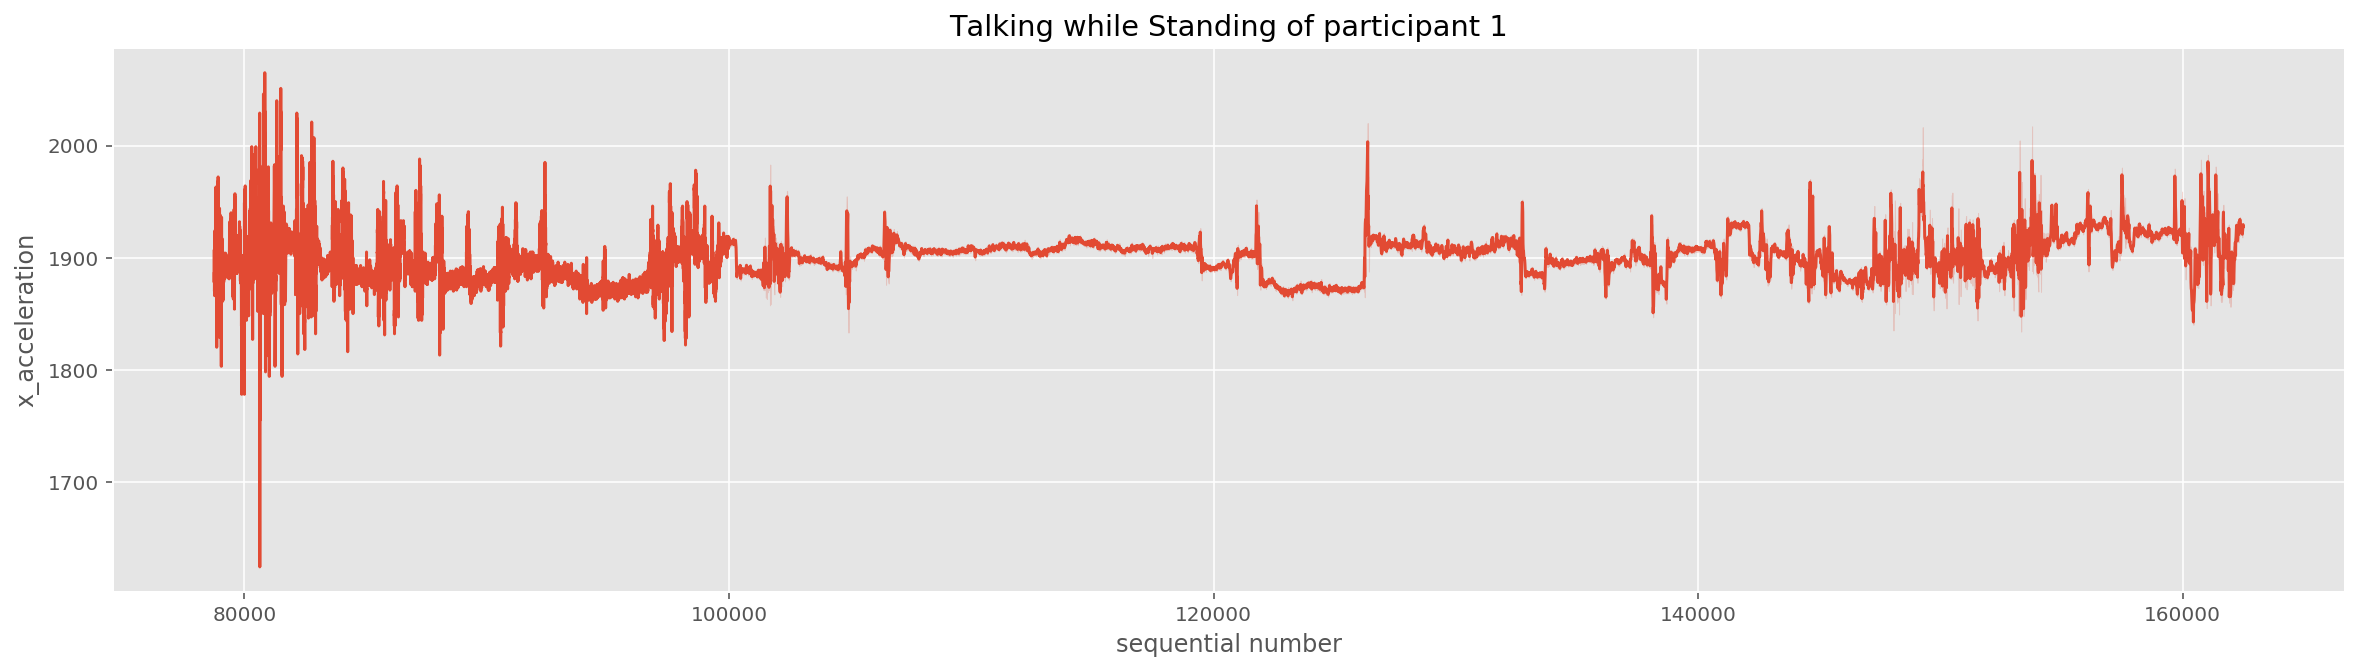

In [34]:
plot_activities(df_all, 1)

Based on the activity visualizations, we can observe some suspicious acceleration peaks at the beginning of the data gathering at activity 1 (Working at Computer). We can assume that this peaks are related to the experimentation setup. Let's visualize only the beginning of activity 1 by using the first 4000 sequential samples.

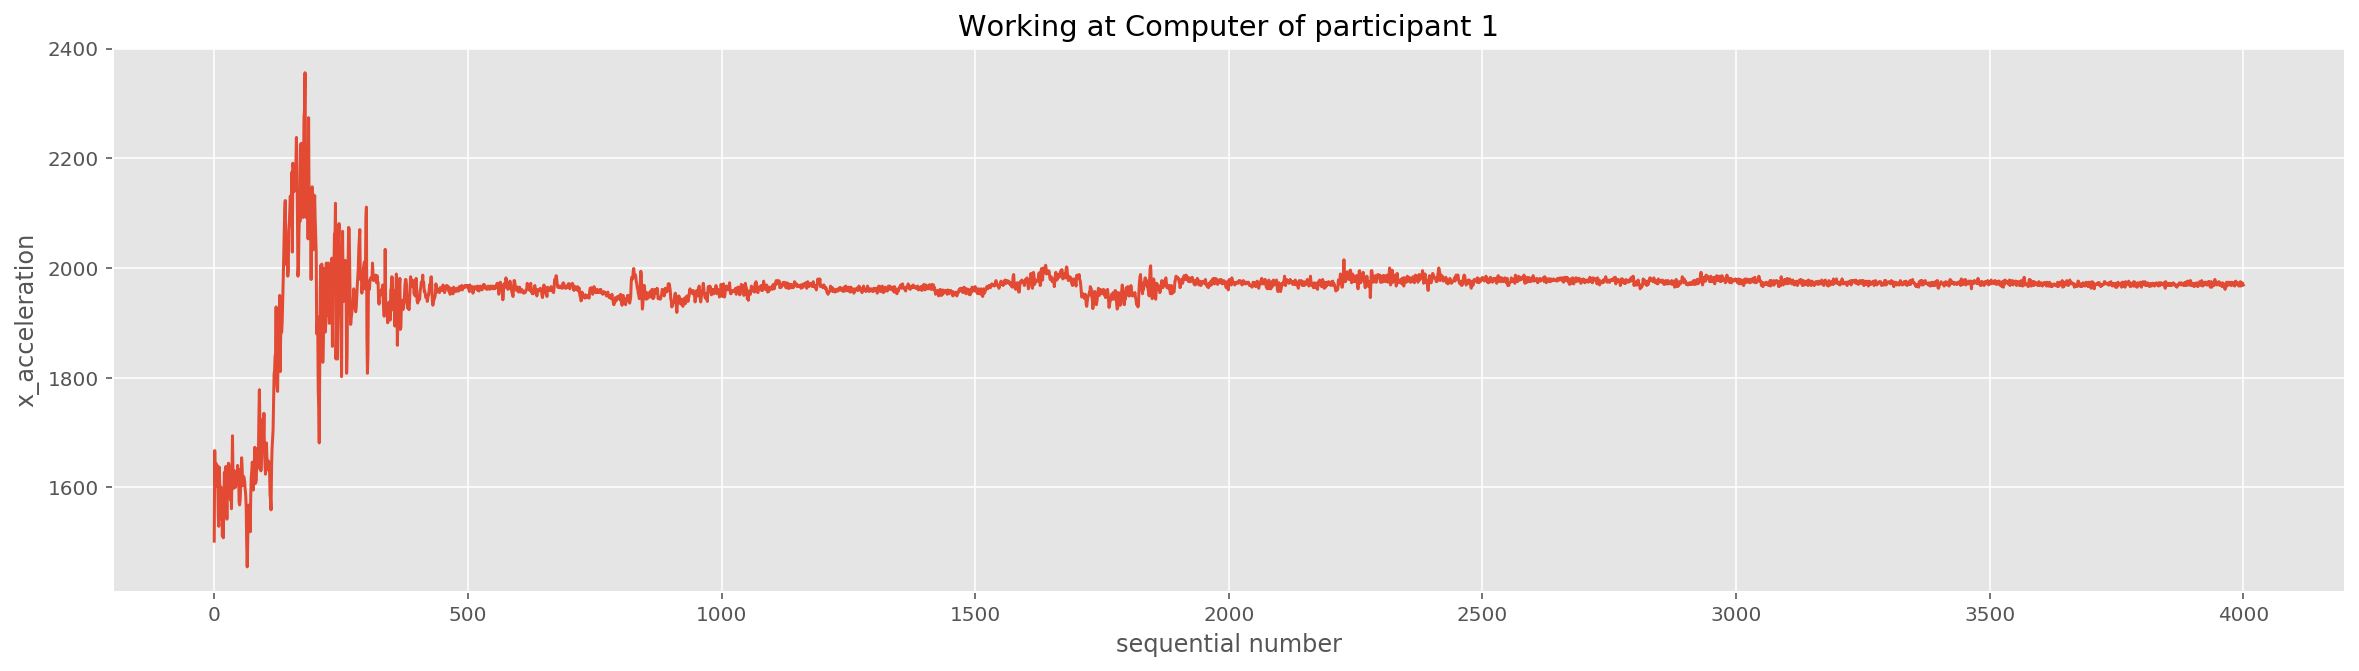

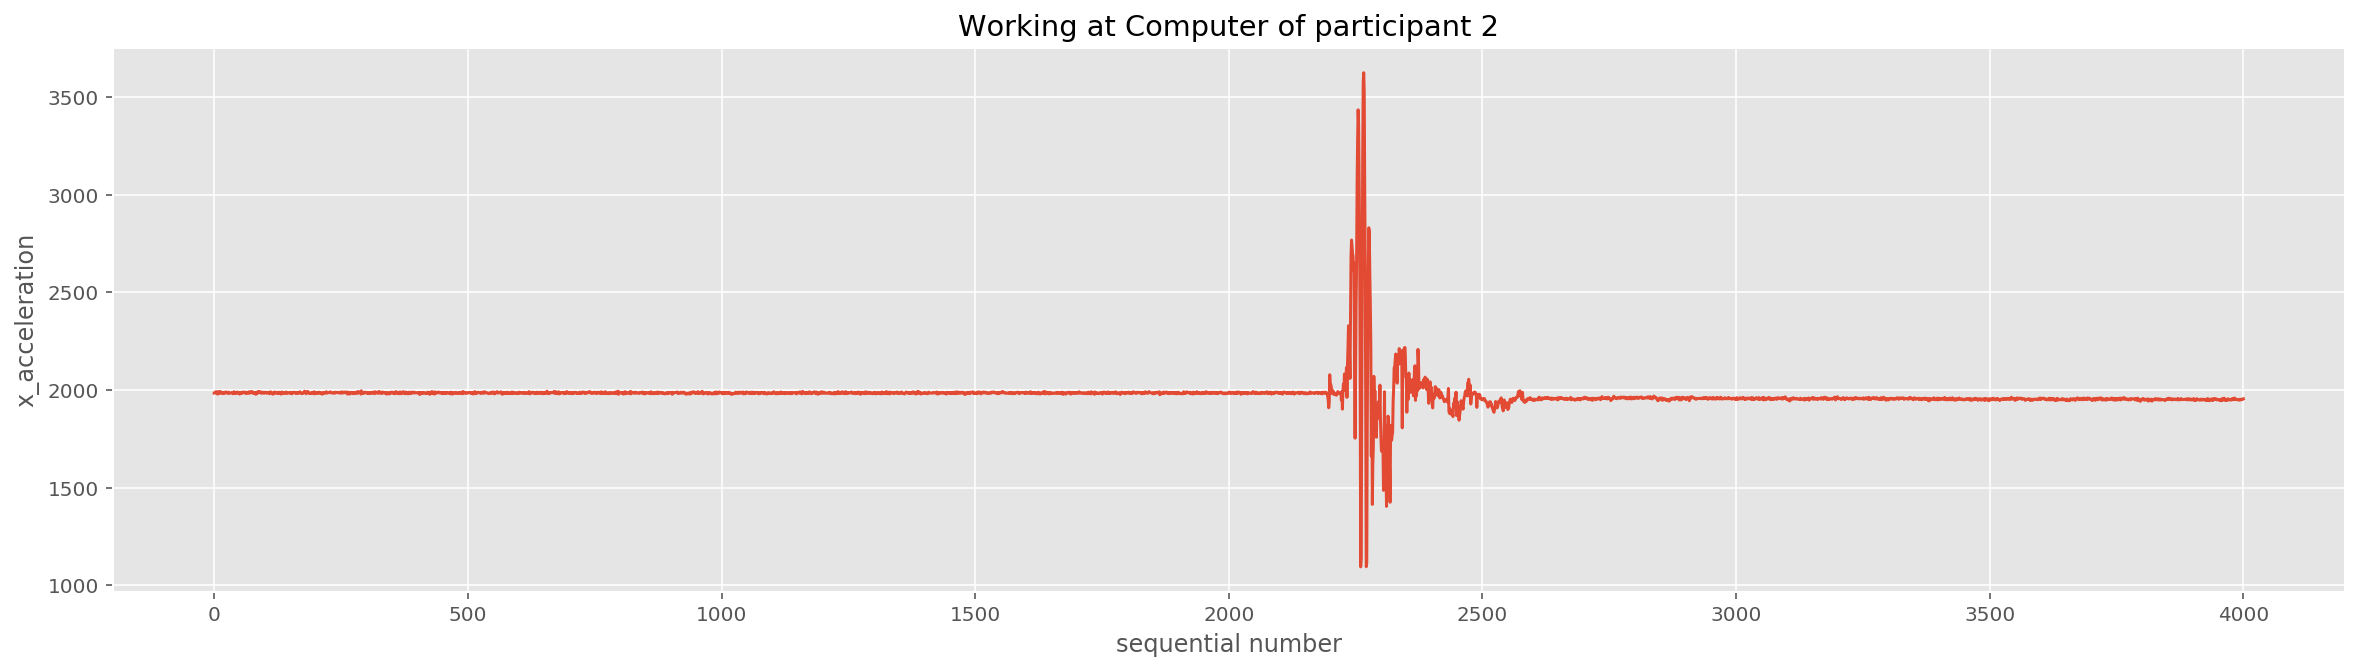

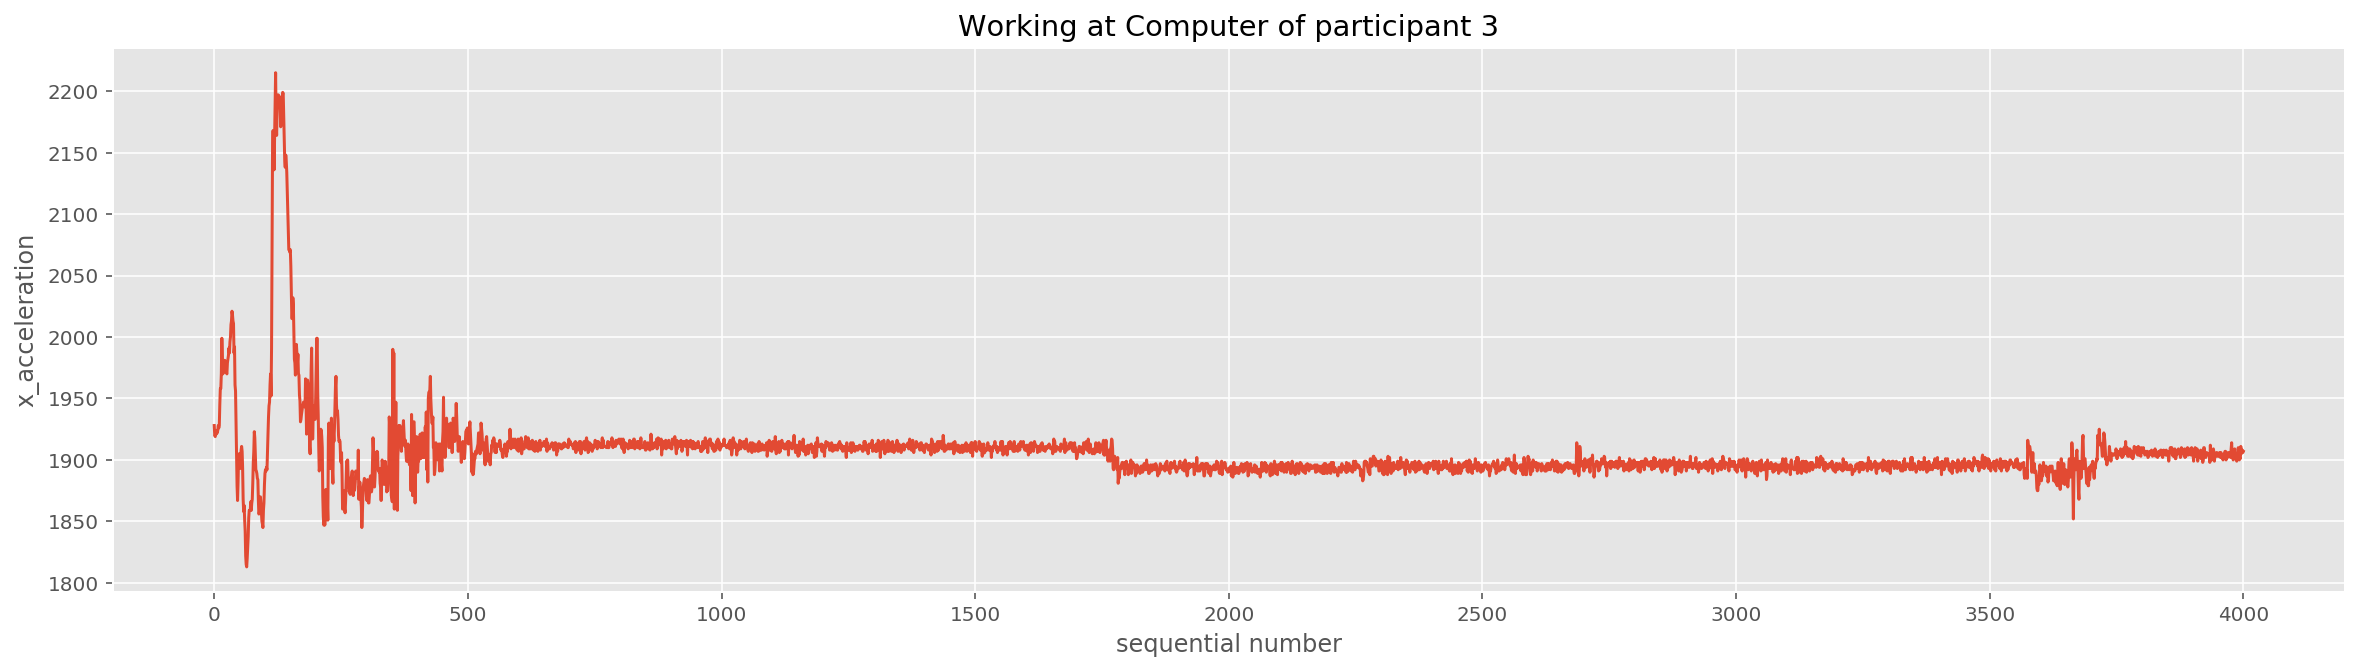

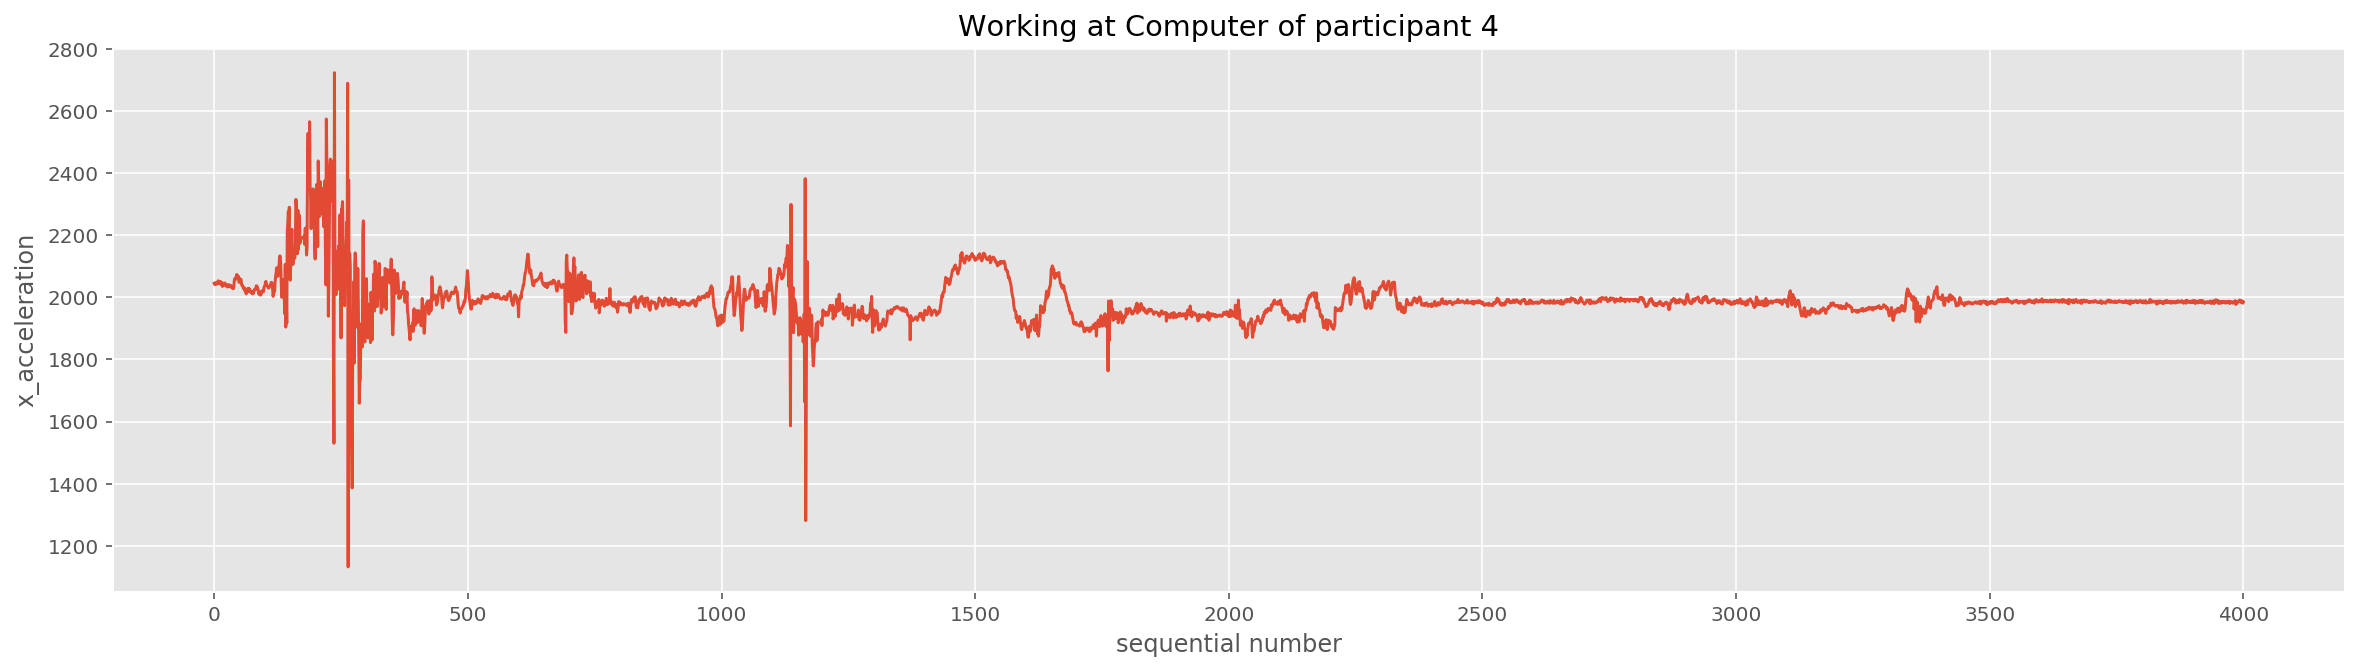

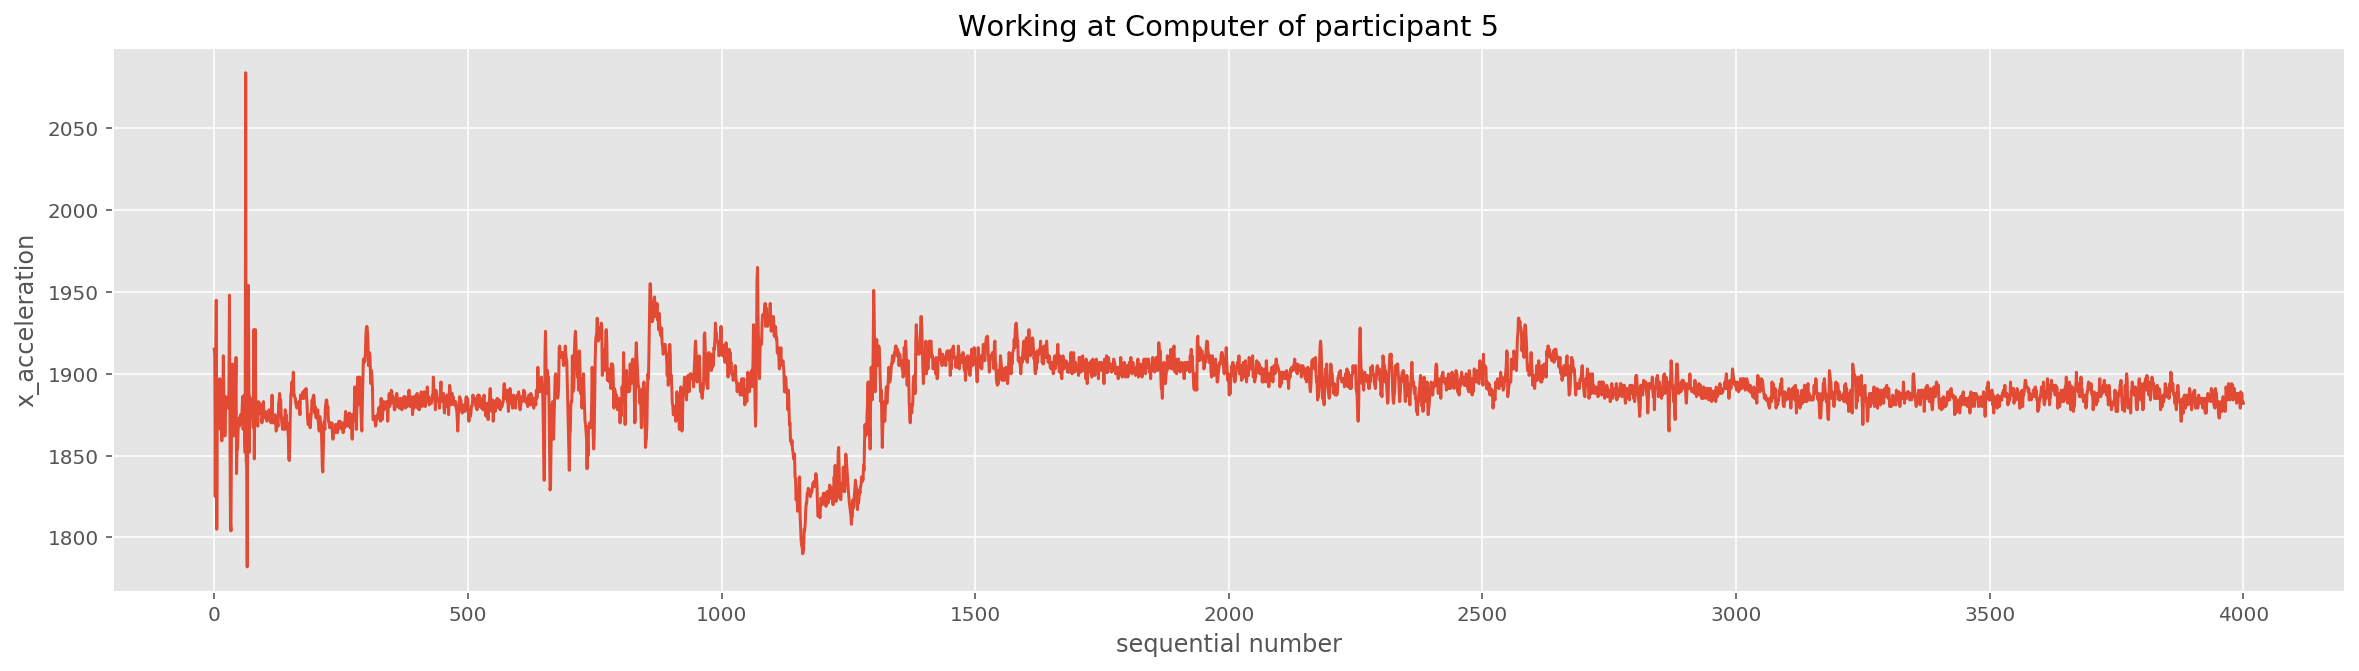

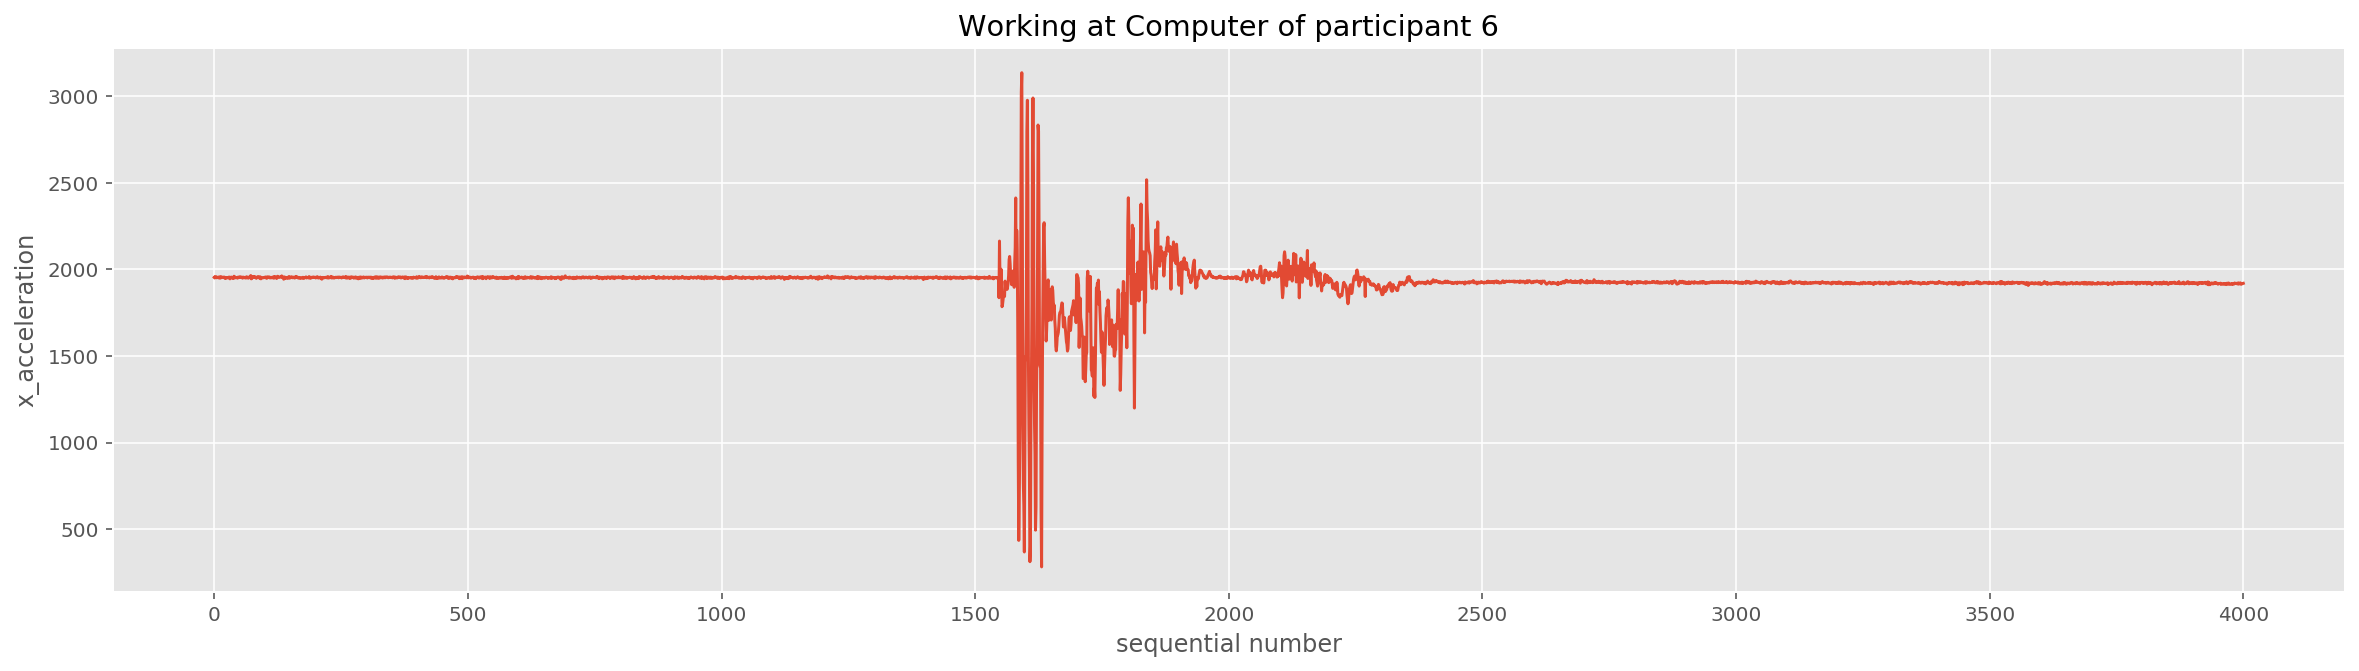

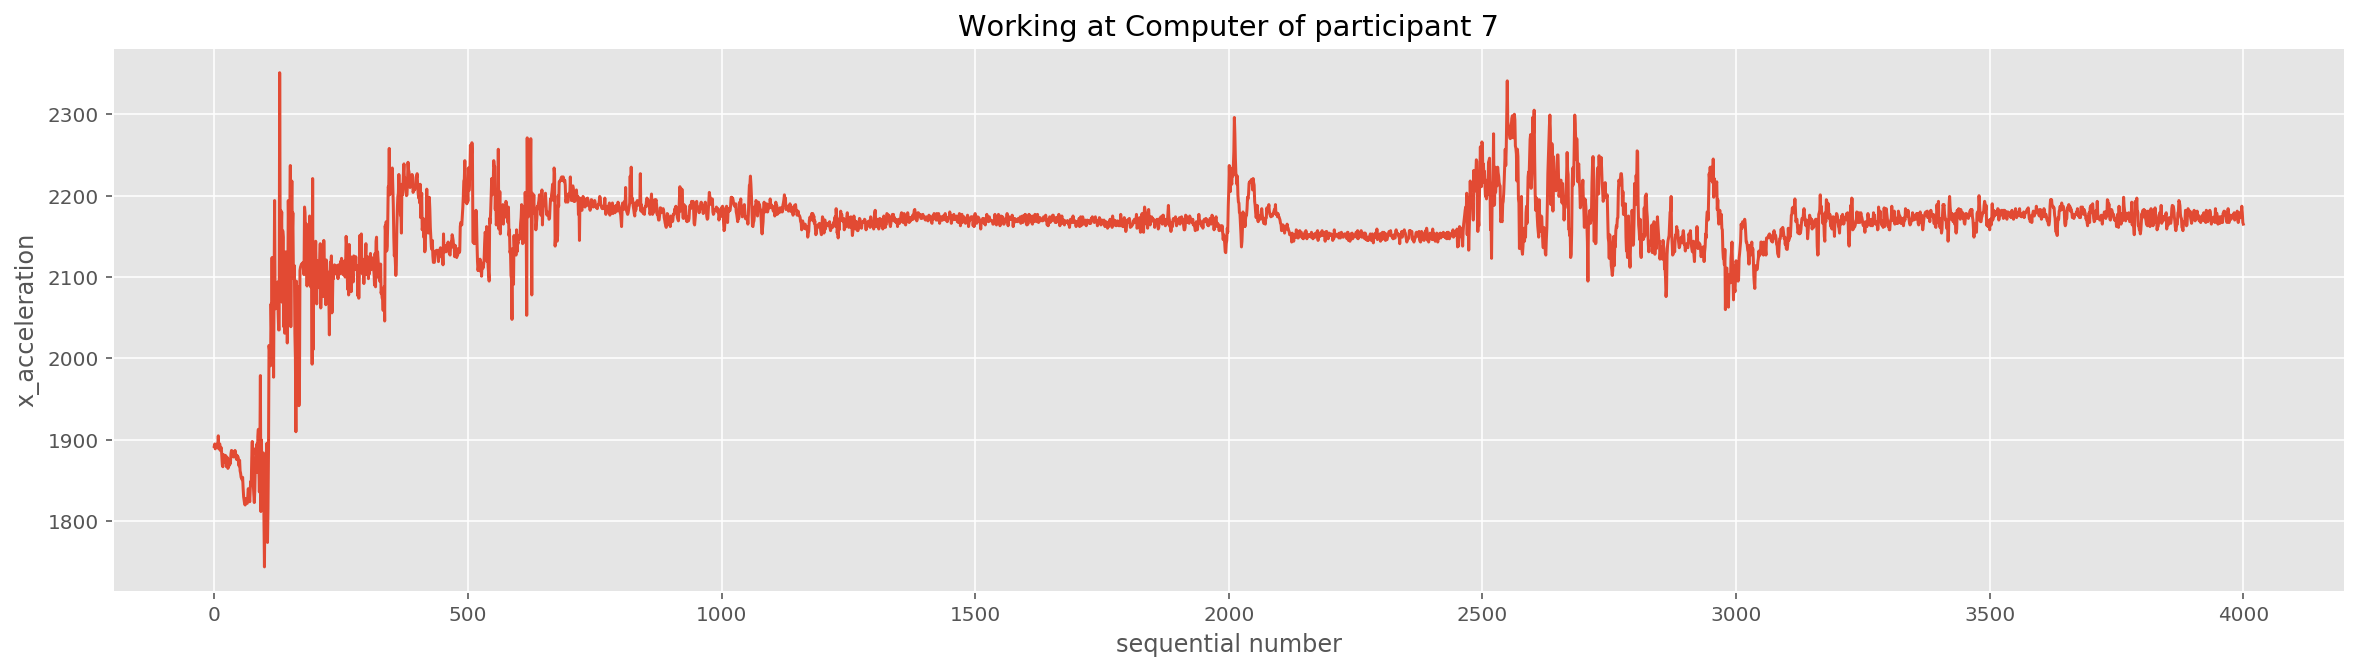

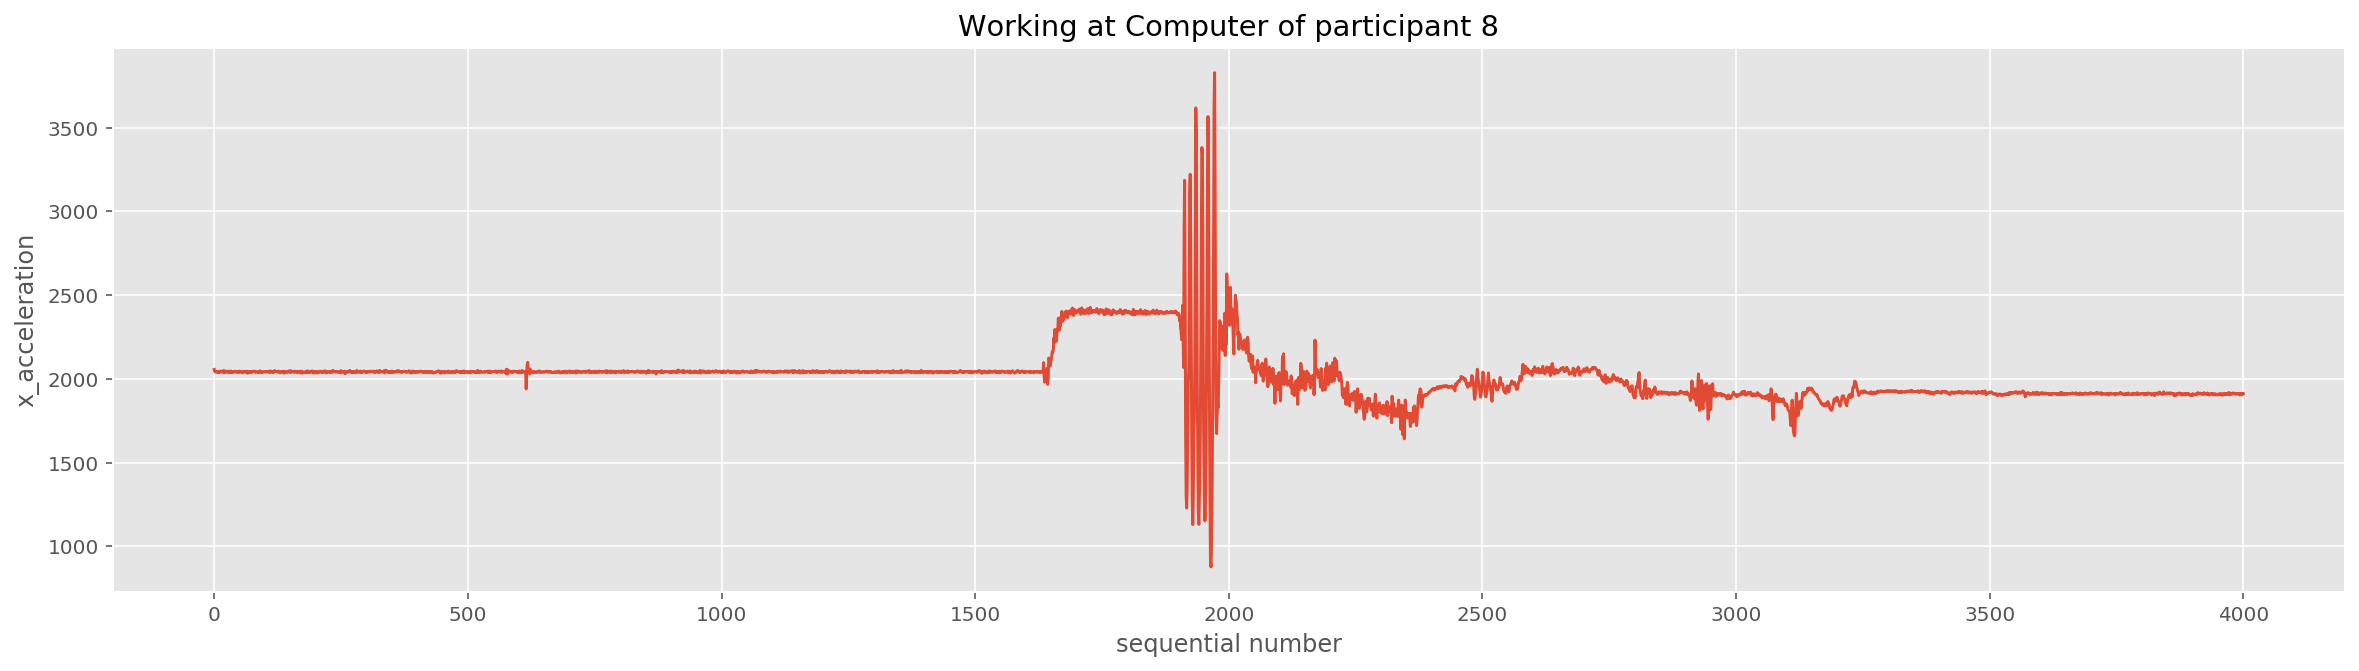

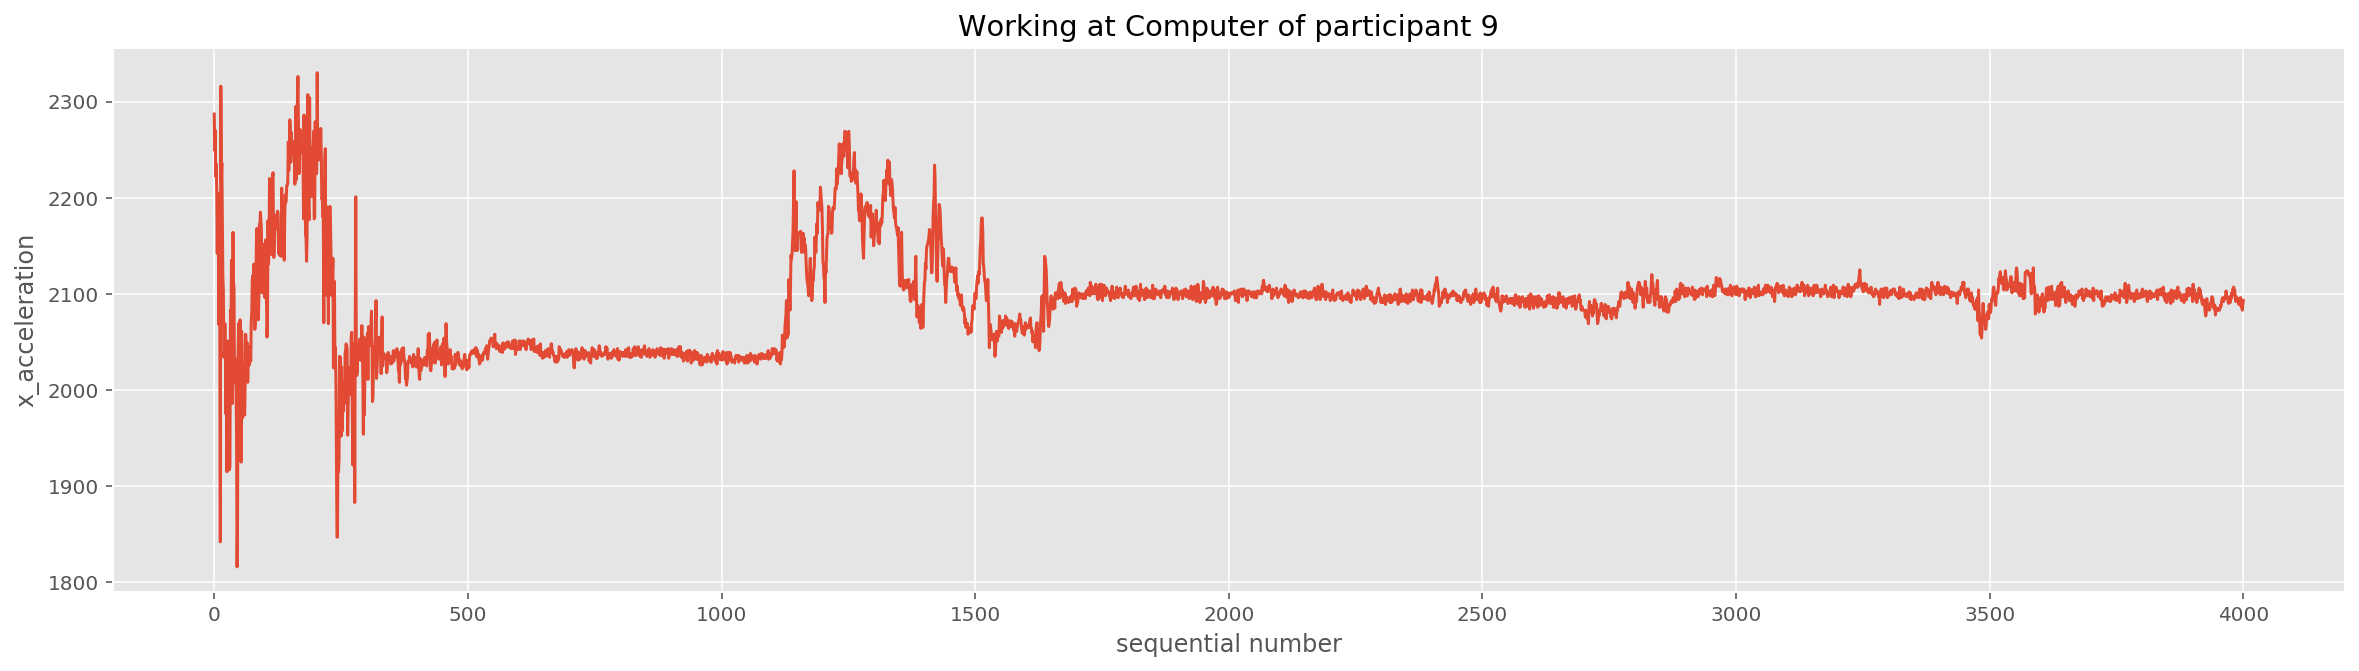

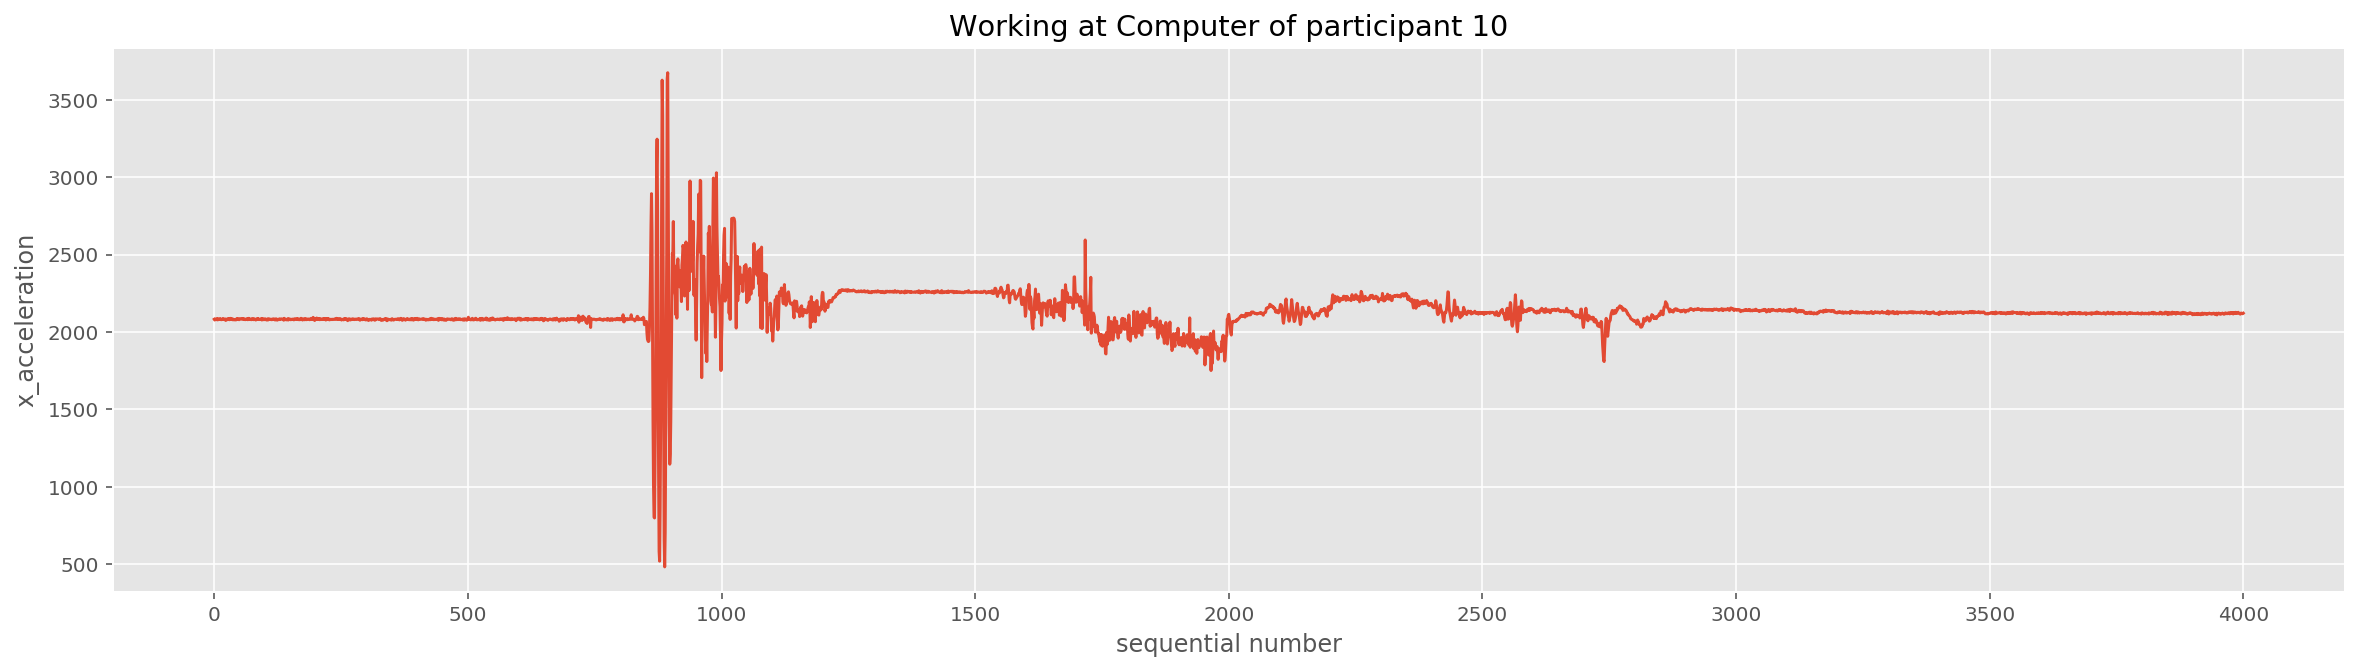

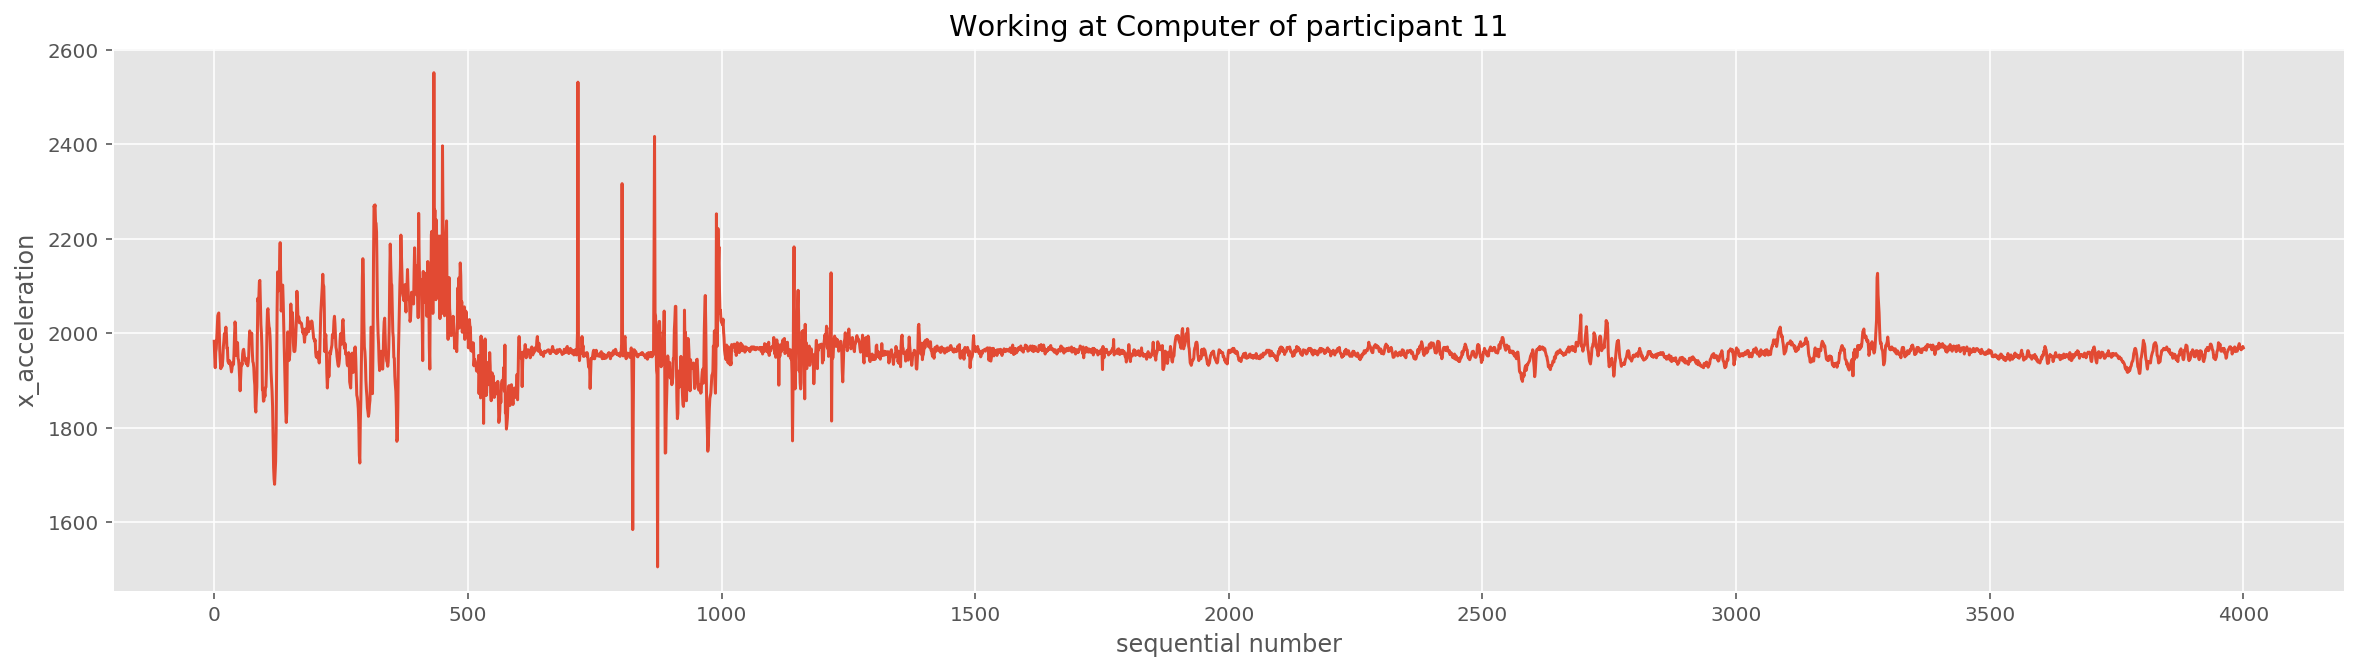

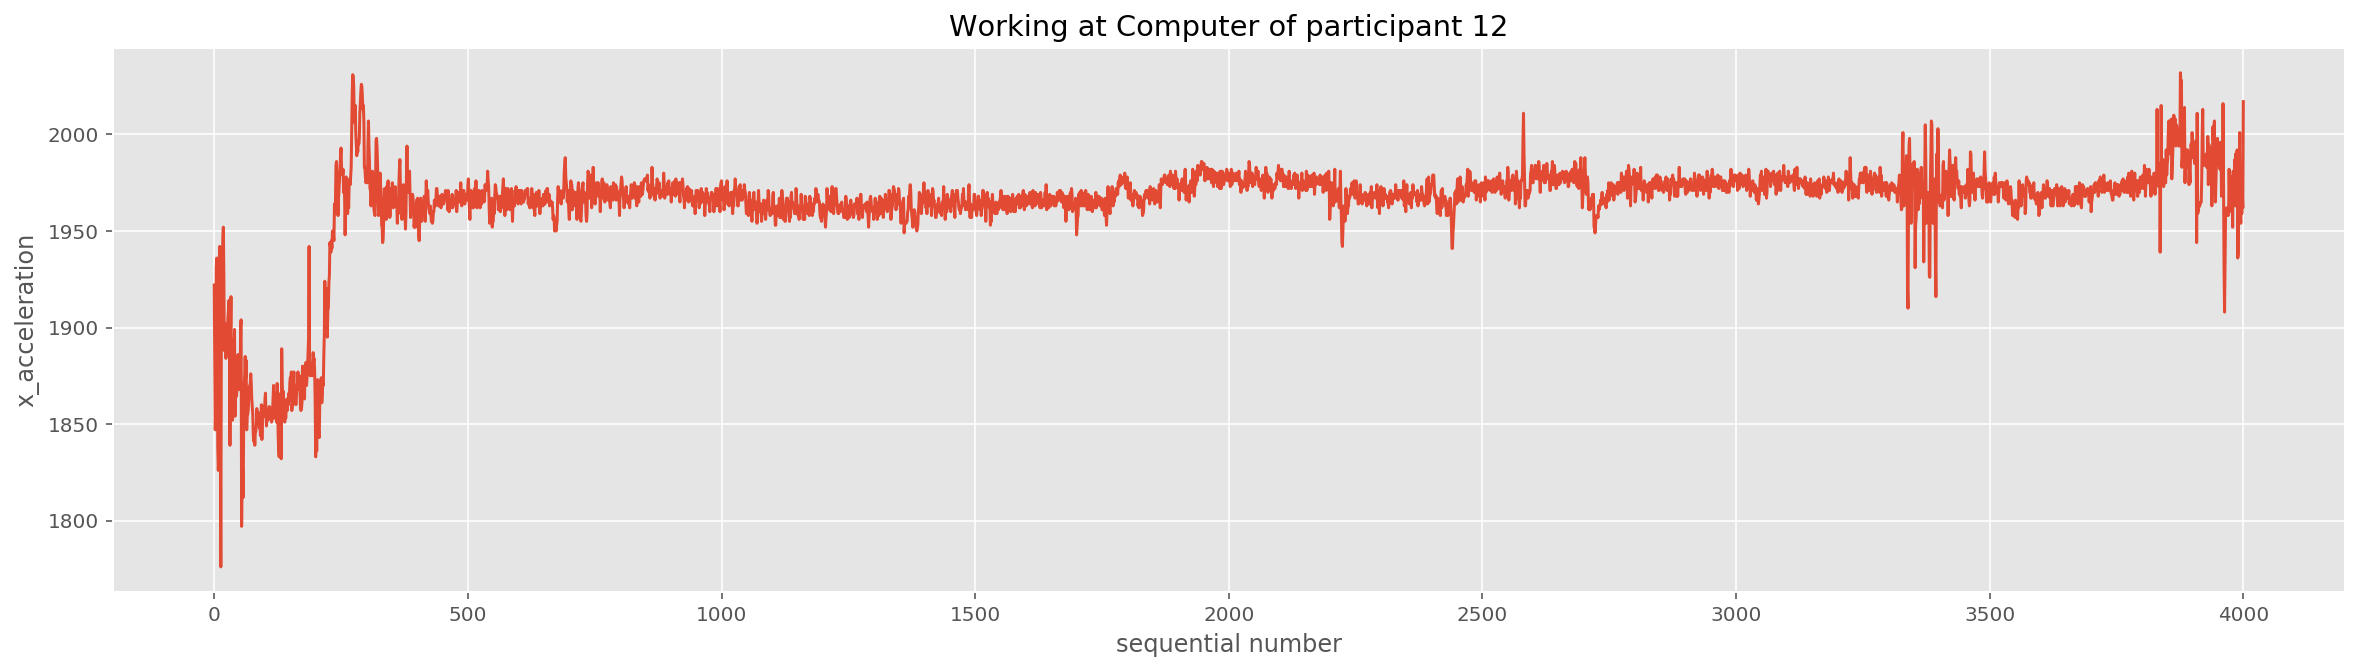

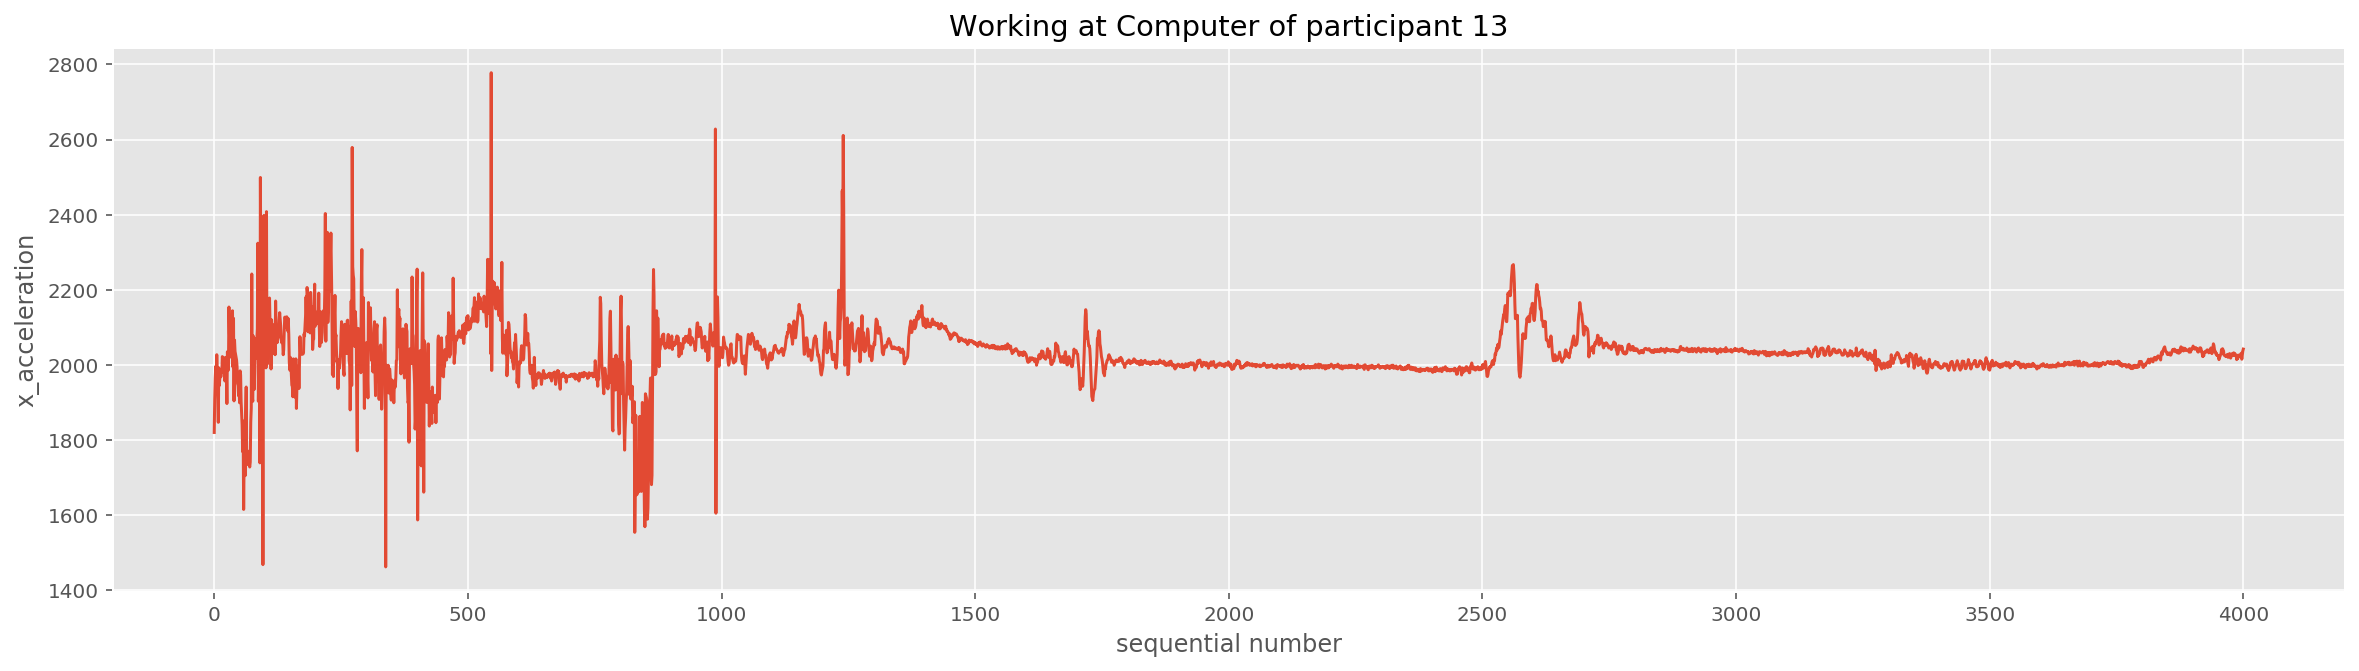

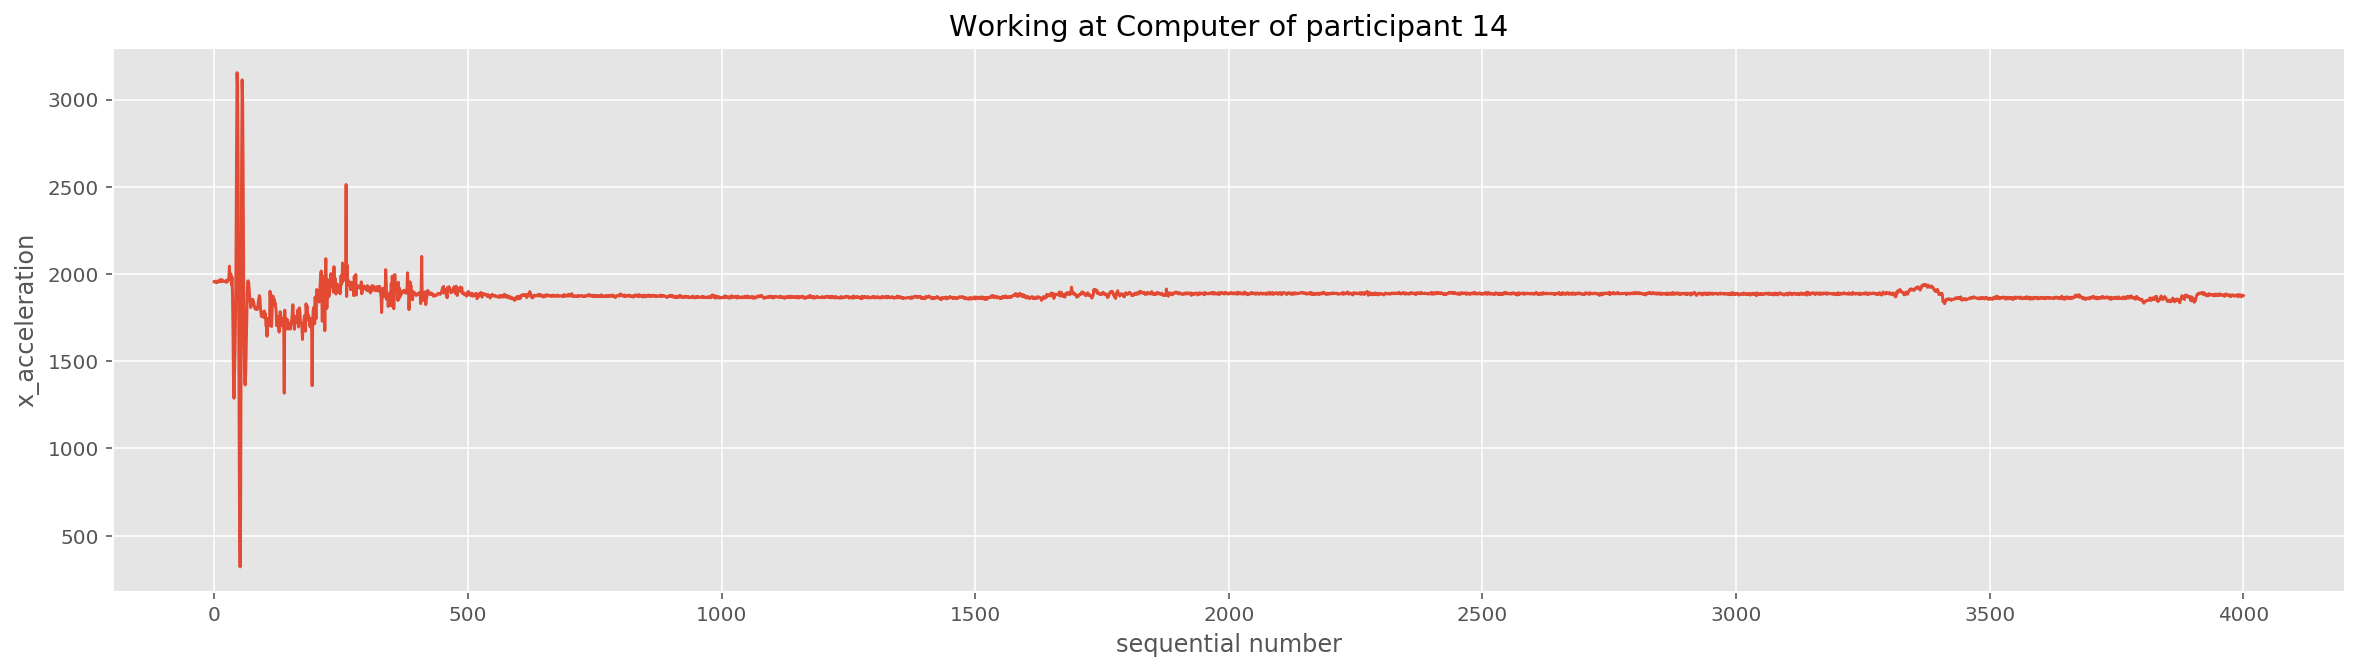

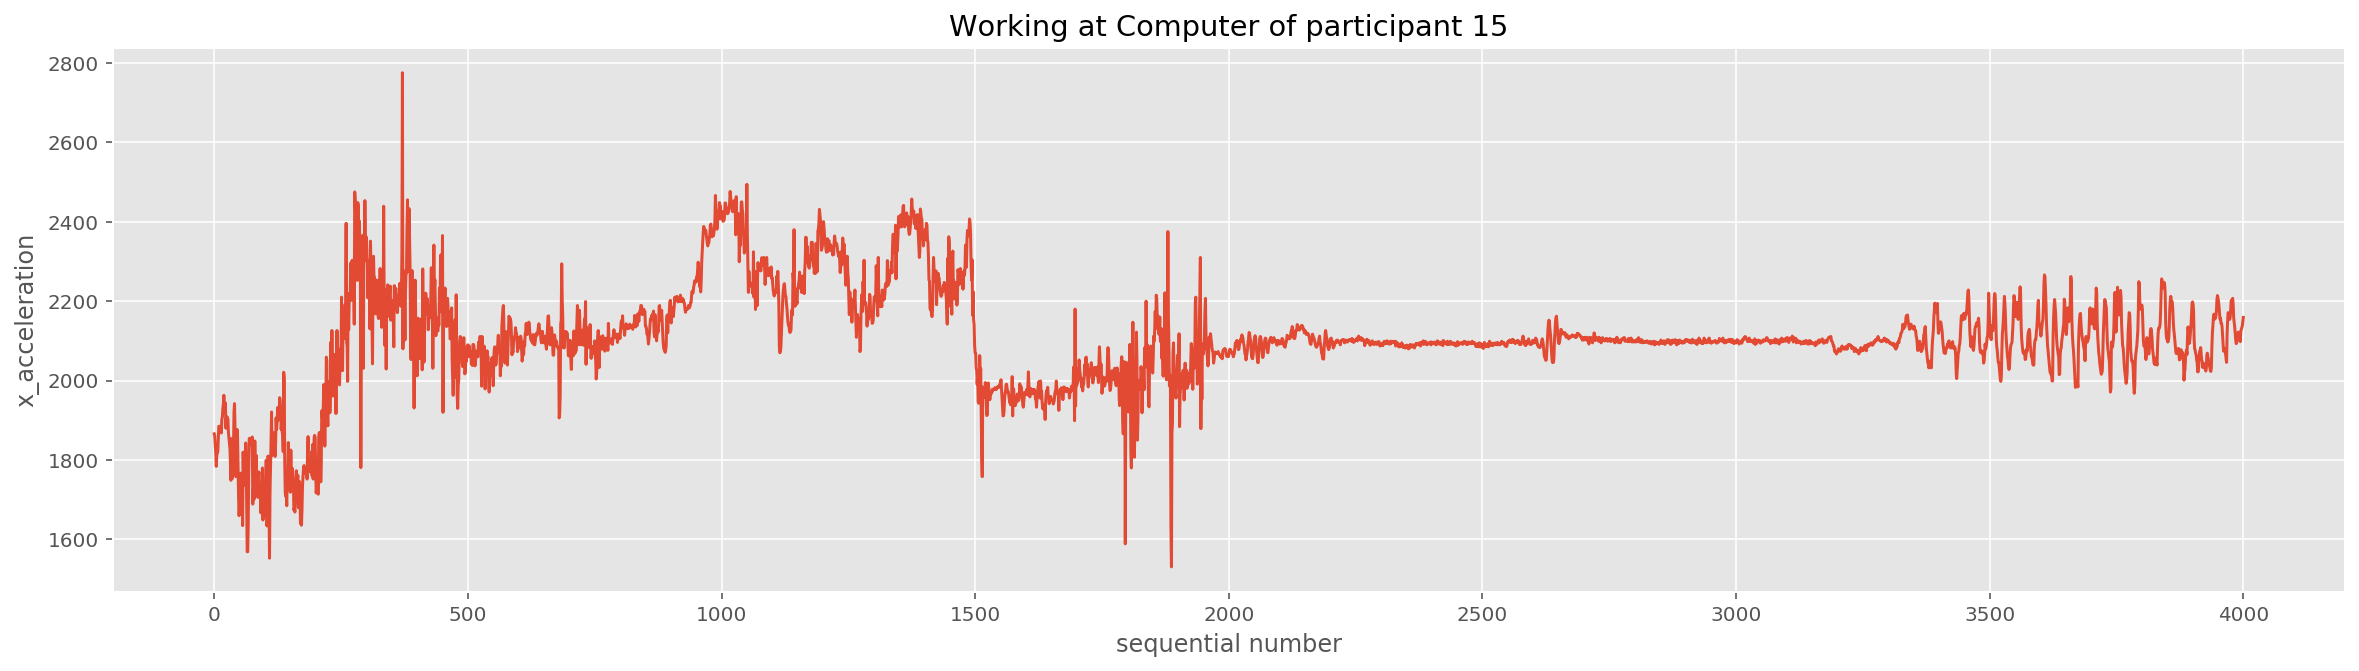

In [35]:
plot_activity_participants_timespan(df_all, 
                                    train_filenames + test_filenames, 
                                    activity=1, 
                                    feature='x_acceleration', 
                                    start=0, 
                                    stop=4000) 

The observed suspicious behaviour is almost at each participant present. Hence, we cut off the beginning of these activities to remove this acceleration peaks from the dataset. According to the visualizations, a cut off at the sequential number 3000 seems a good threshold to remove these peaks from each participant.

In [36]:
df_all_cleaned = pd.DataFrame()
for participant, group in df_all.groupby('participant'):
    df_all_cleaned = df_all_cleaned.append(group[3000:])

df_all_cleaned.shape

(1878177, 5)

Subsequently, we can explore the descriptive statistics of the acceleration features and visualize the activity 1 again.

In [37]:
df_all_cleaned.describe().round(2)

x_acceleration  y_acceleration  z_acceleration    activity  participant
count      1878177.00      1878177.00      1878177.00  1878177.00   1878177.00
mean          1987.12         2383.67         1971.45        3.96         7.50
std            110.77           97.32           91.45        2.43         4.17
min           1199.00         1451.00          630.00        1.00         1.00
25%           1903.00         2337.00         1919.00        1.00         4.00
50%           1993.00         2367.00         1988.00        4.00         7.00
75%           2076.00         2414.00         2032.00        7.00        11.00
max           2700.00         3853.00         3124.00        7.00        15.00

In [38]:
# Clip y_acceleration maximum and z_acceleration minimum as these values are still high/low
df_all_cleaned['y_acceleration'] = df_all_cleaned['y_acceleration'].clip(upper=3300.0)
df_all_cleaned['z_acceleration'] = df_all_cleaned['z_acceleration'].clip(lower=1000.0)

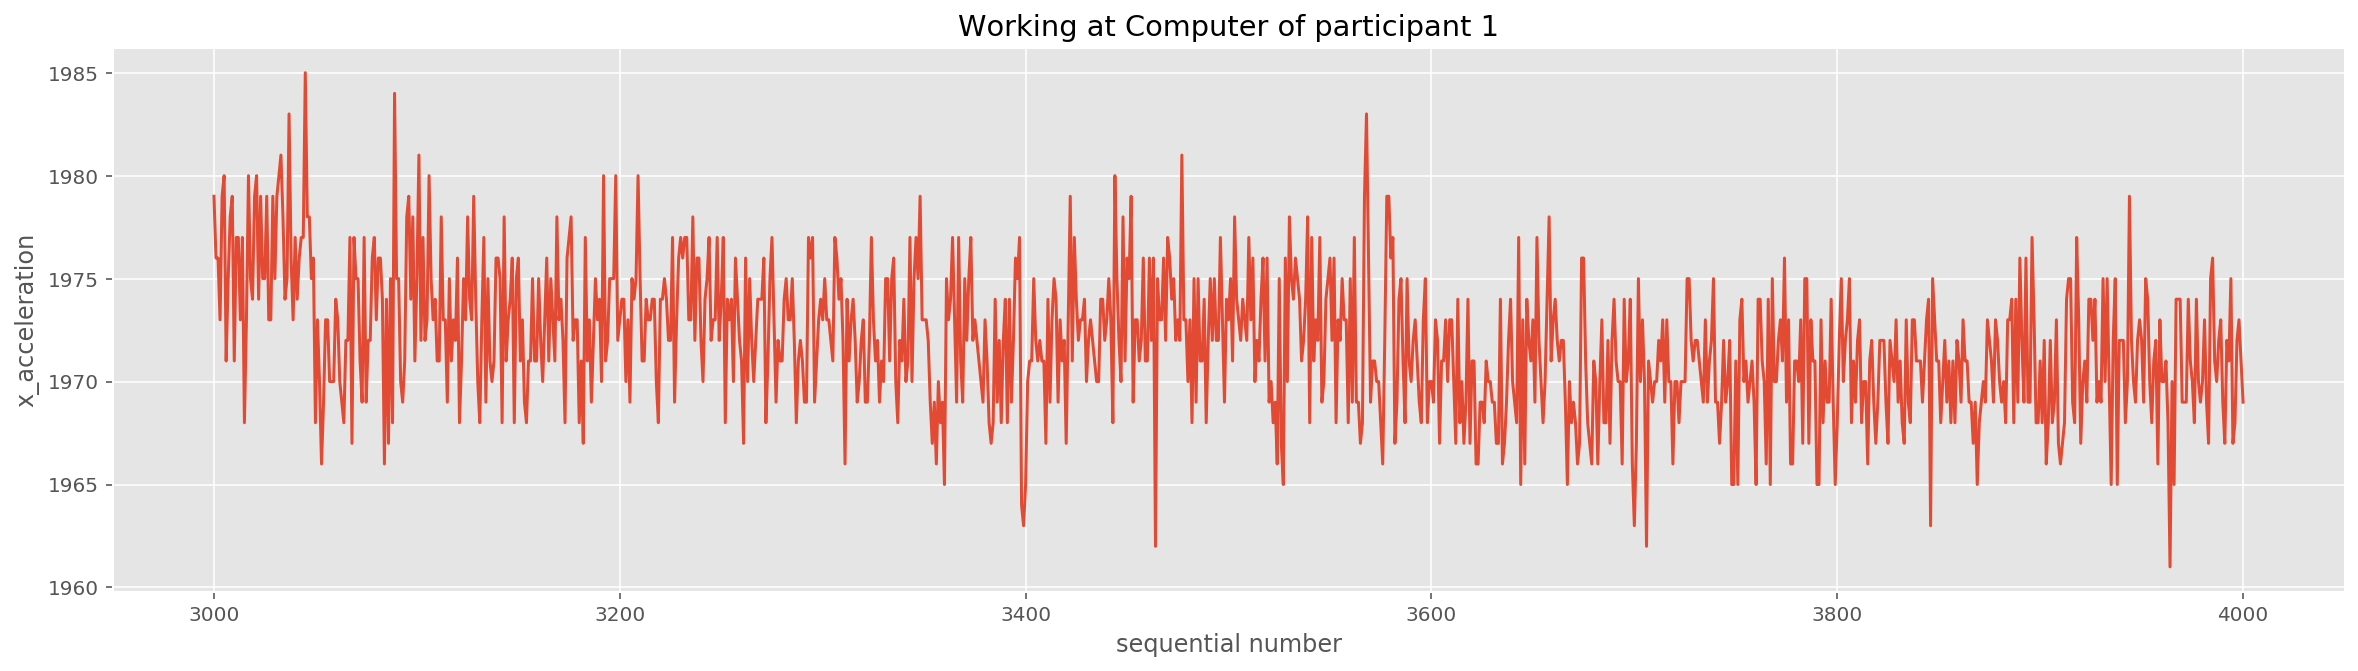

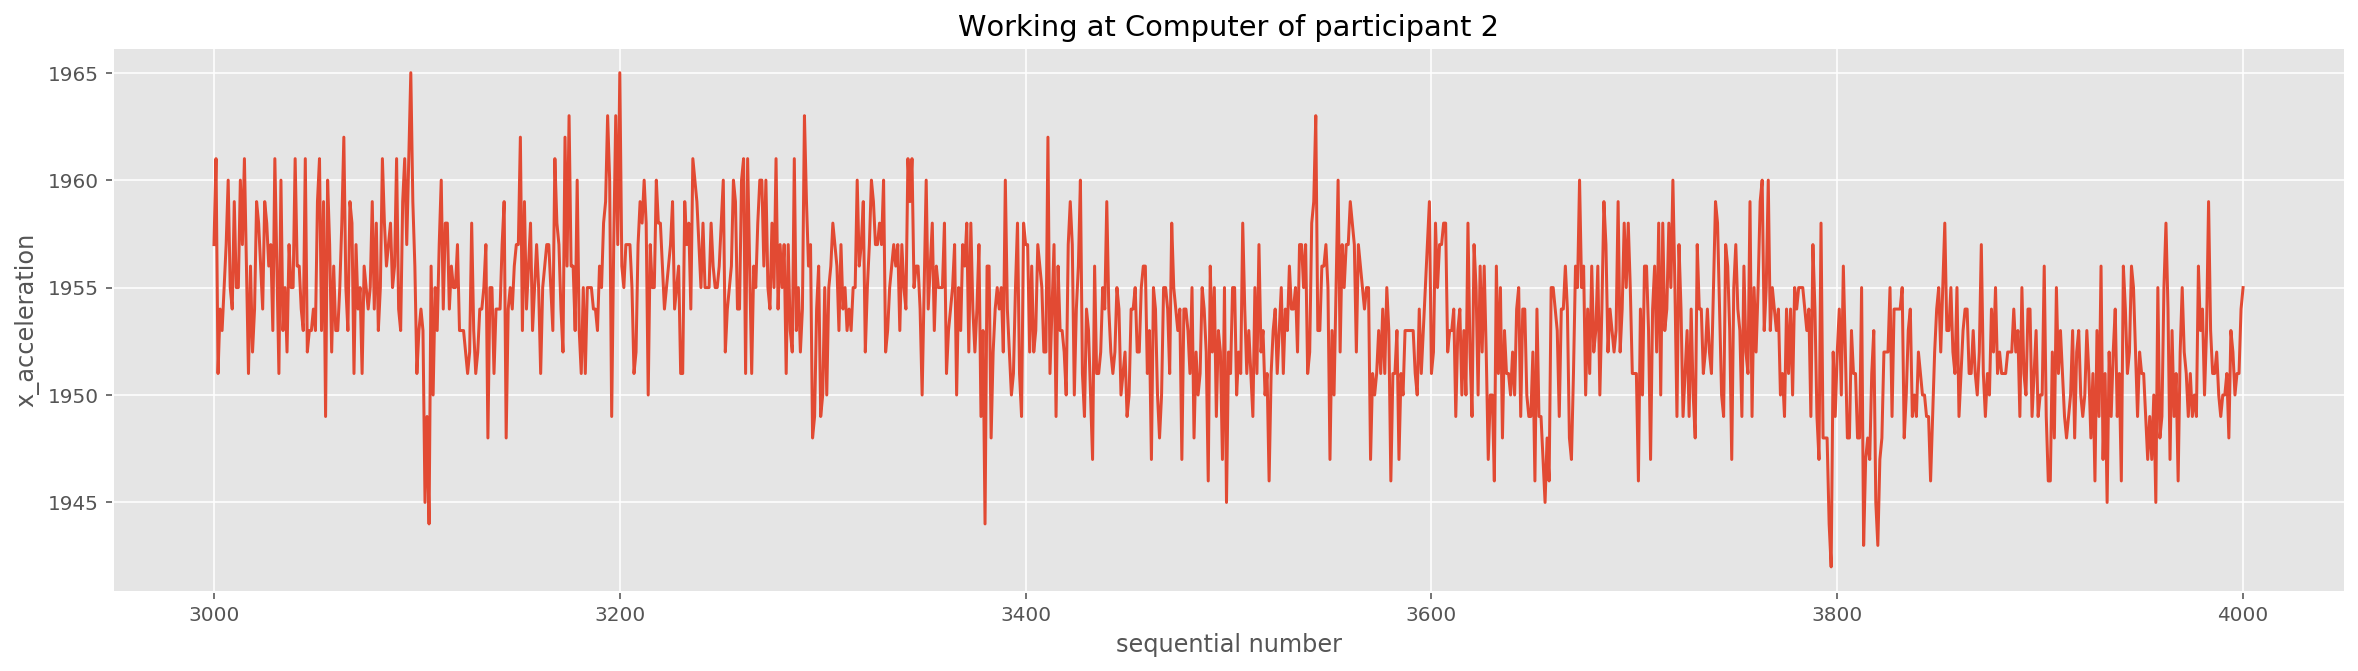

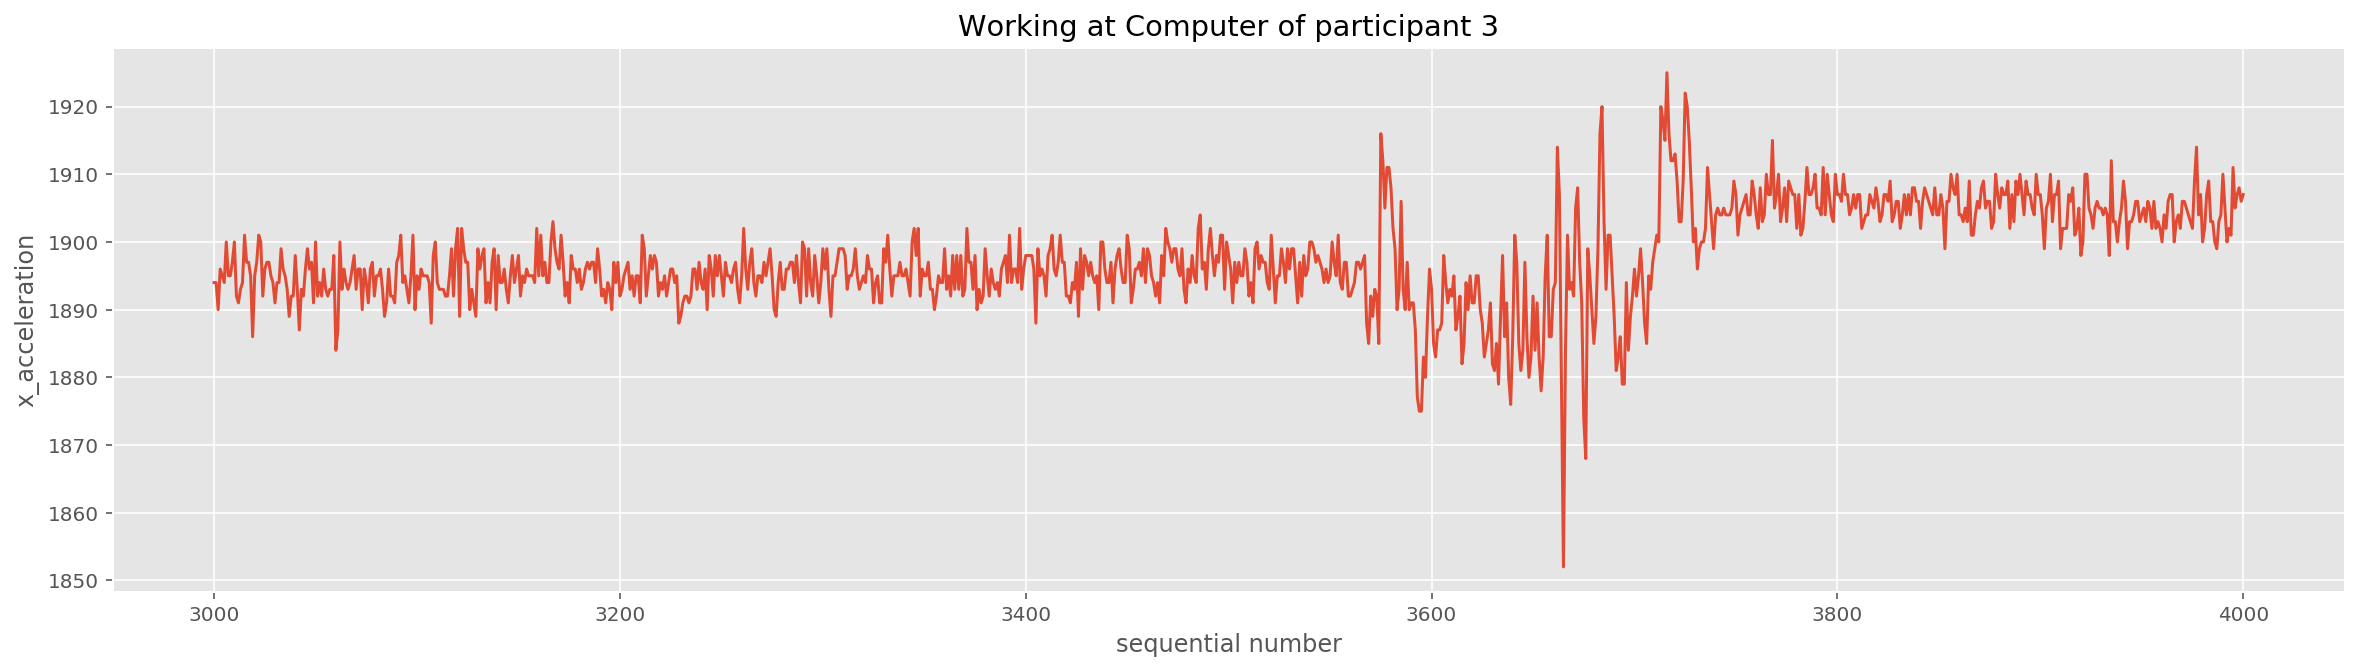

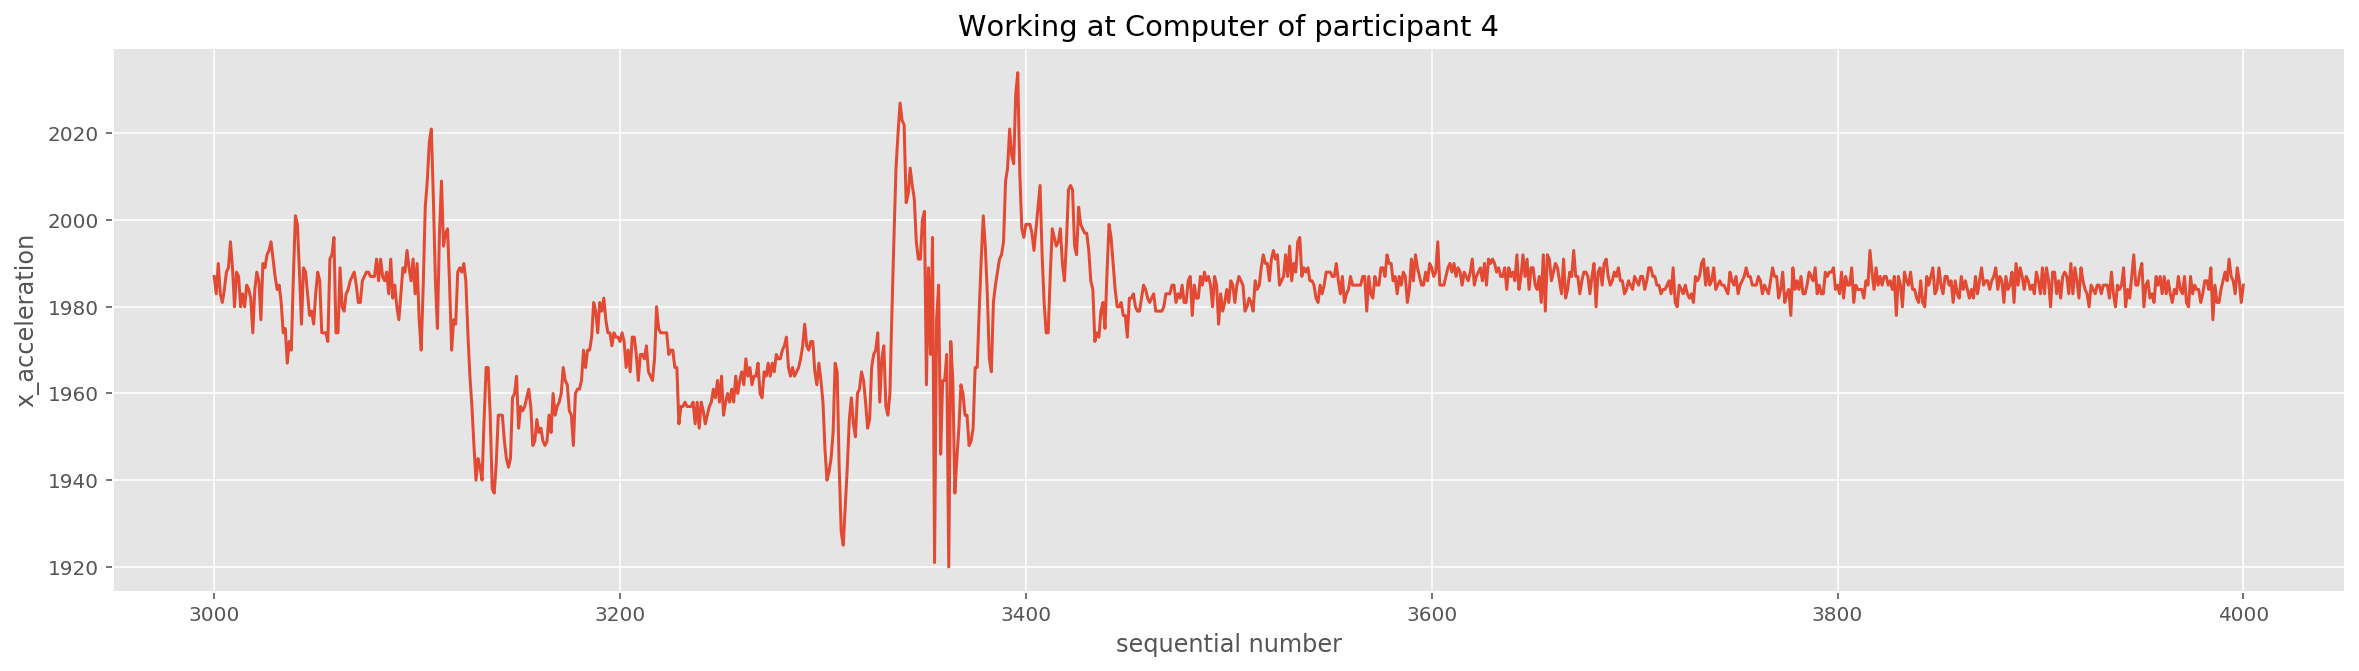

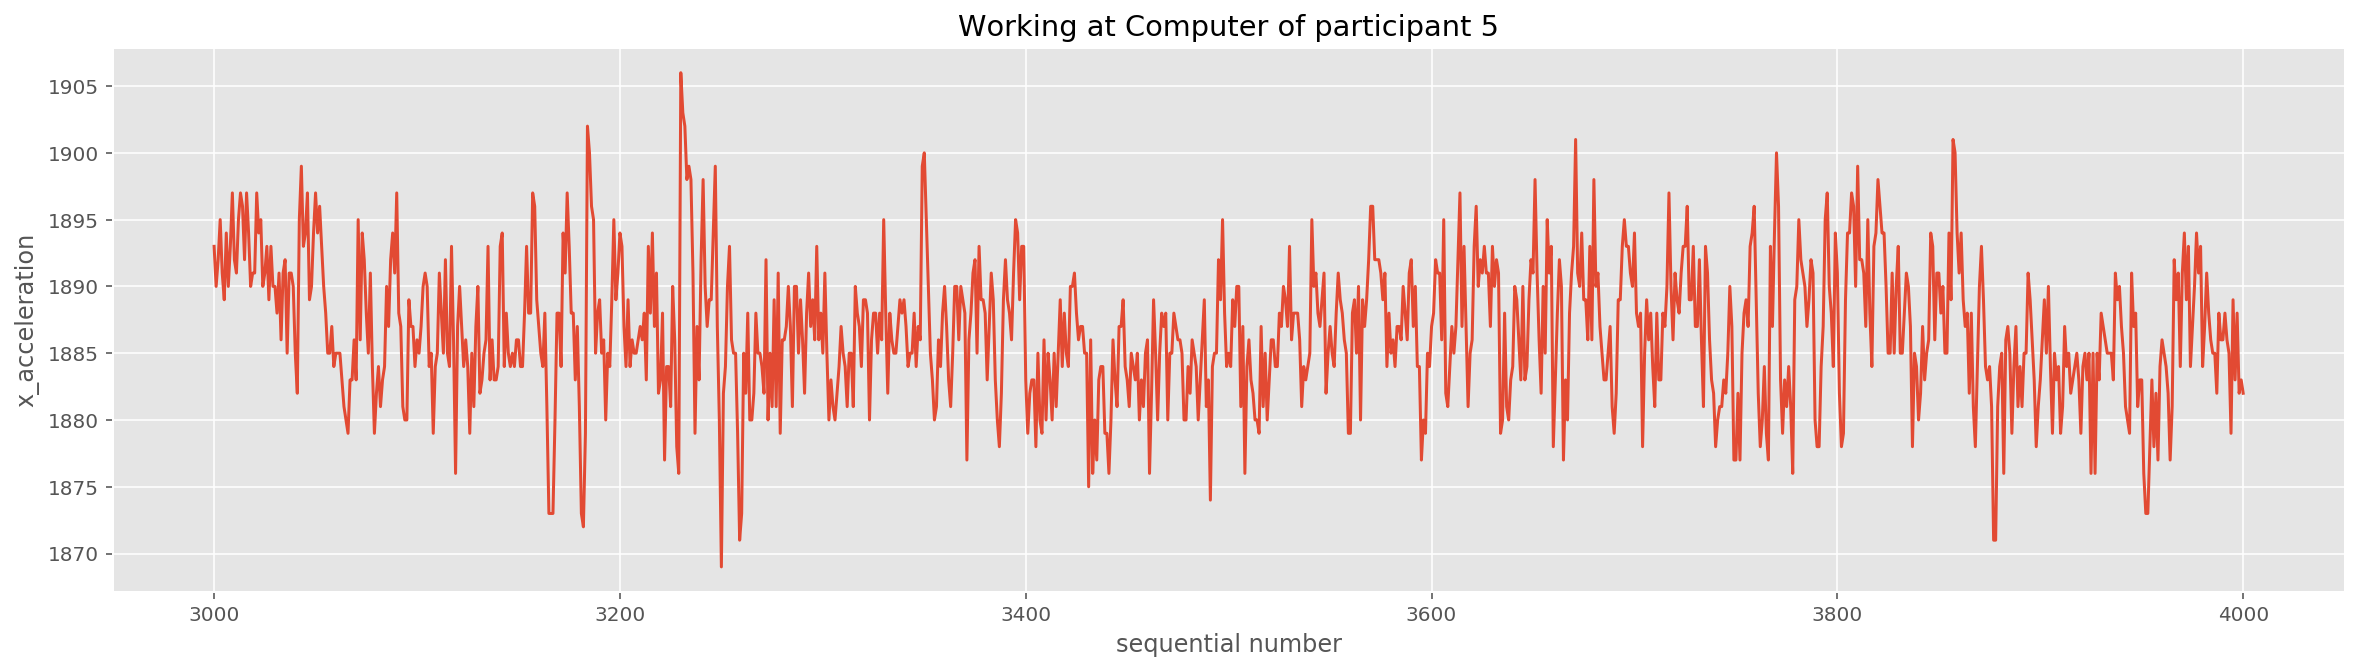

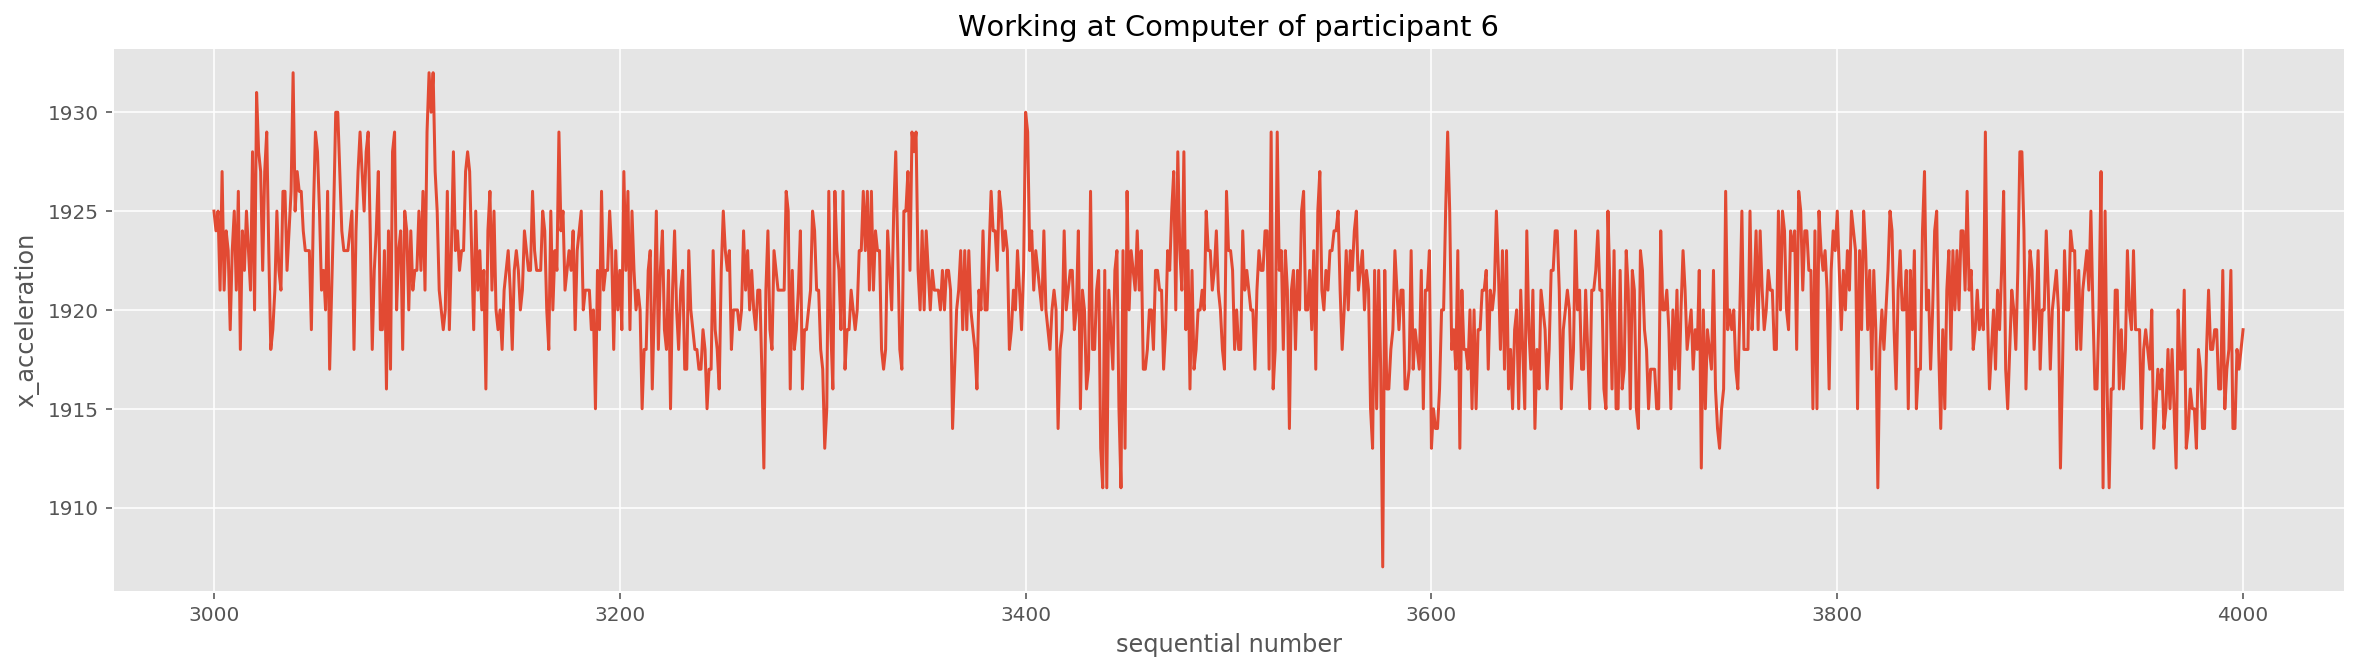

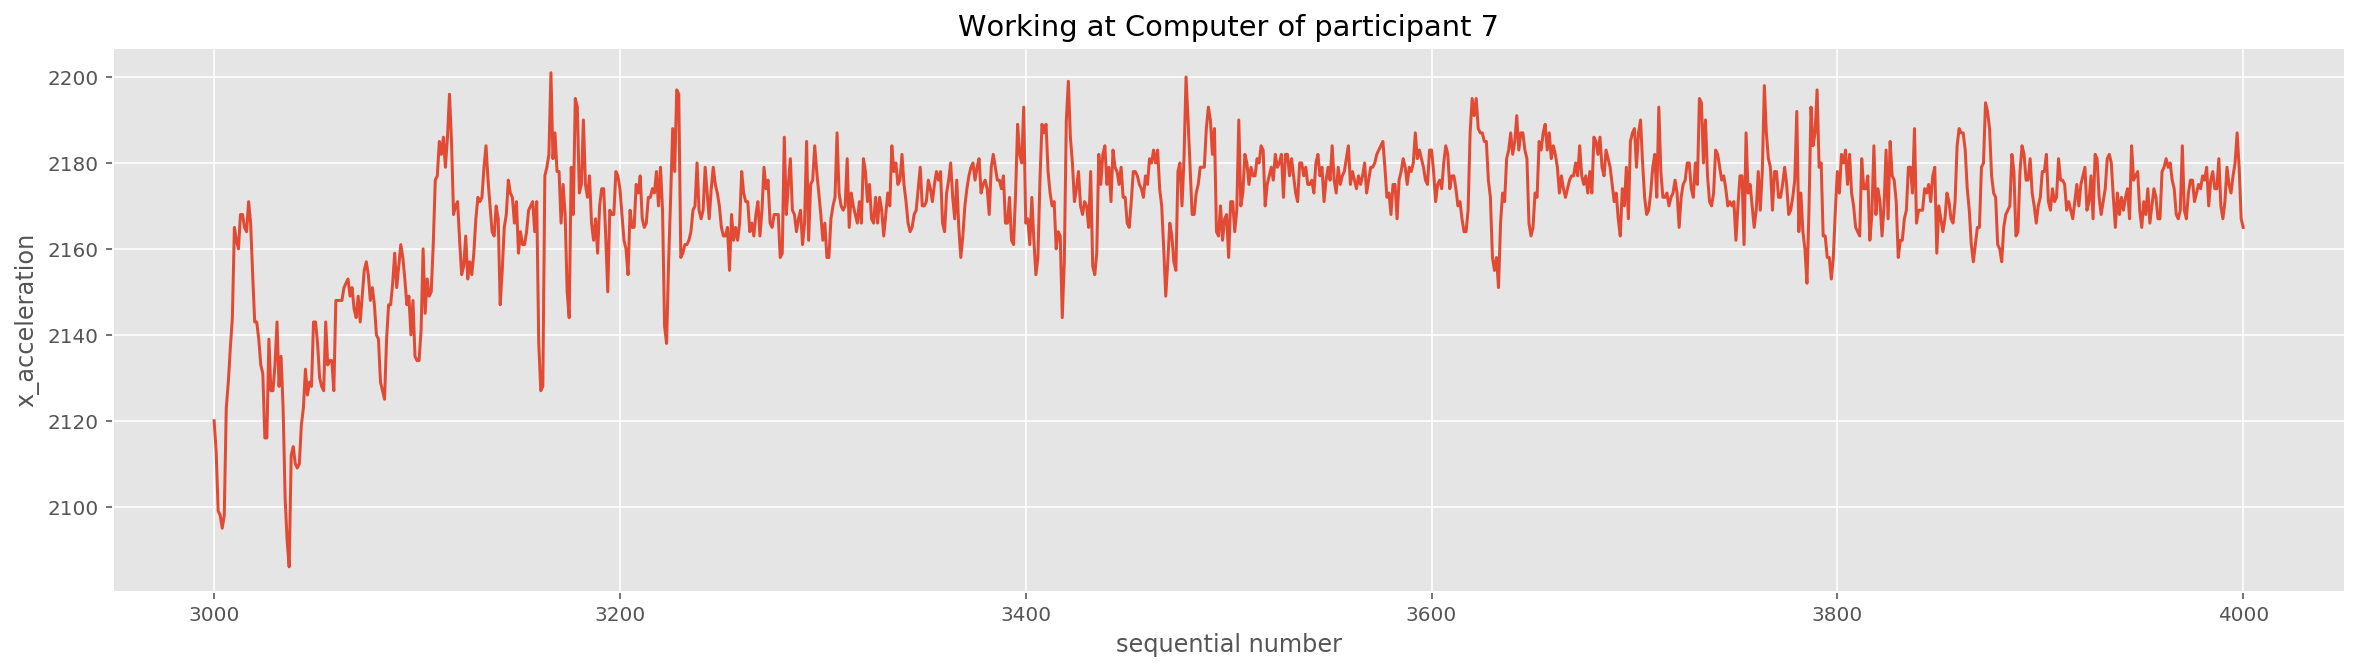

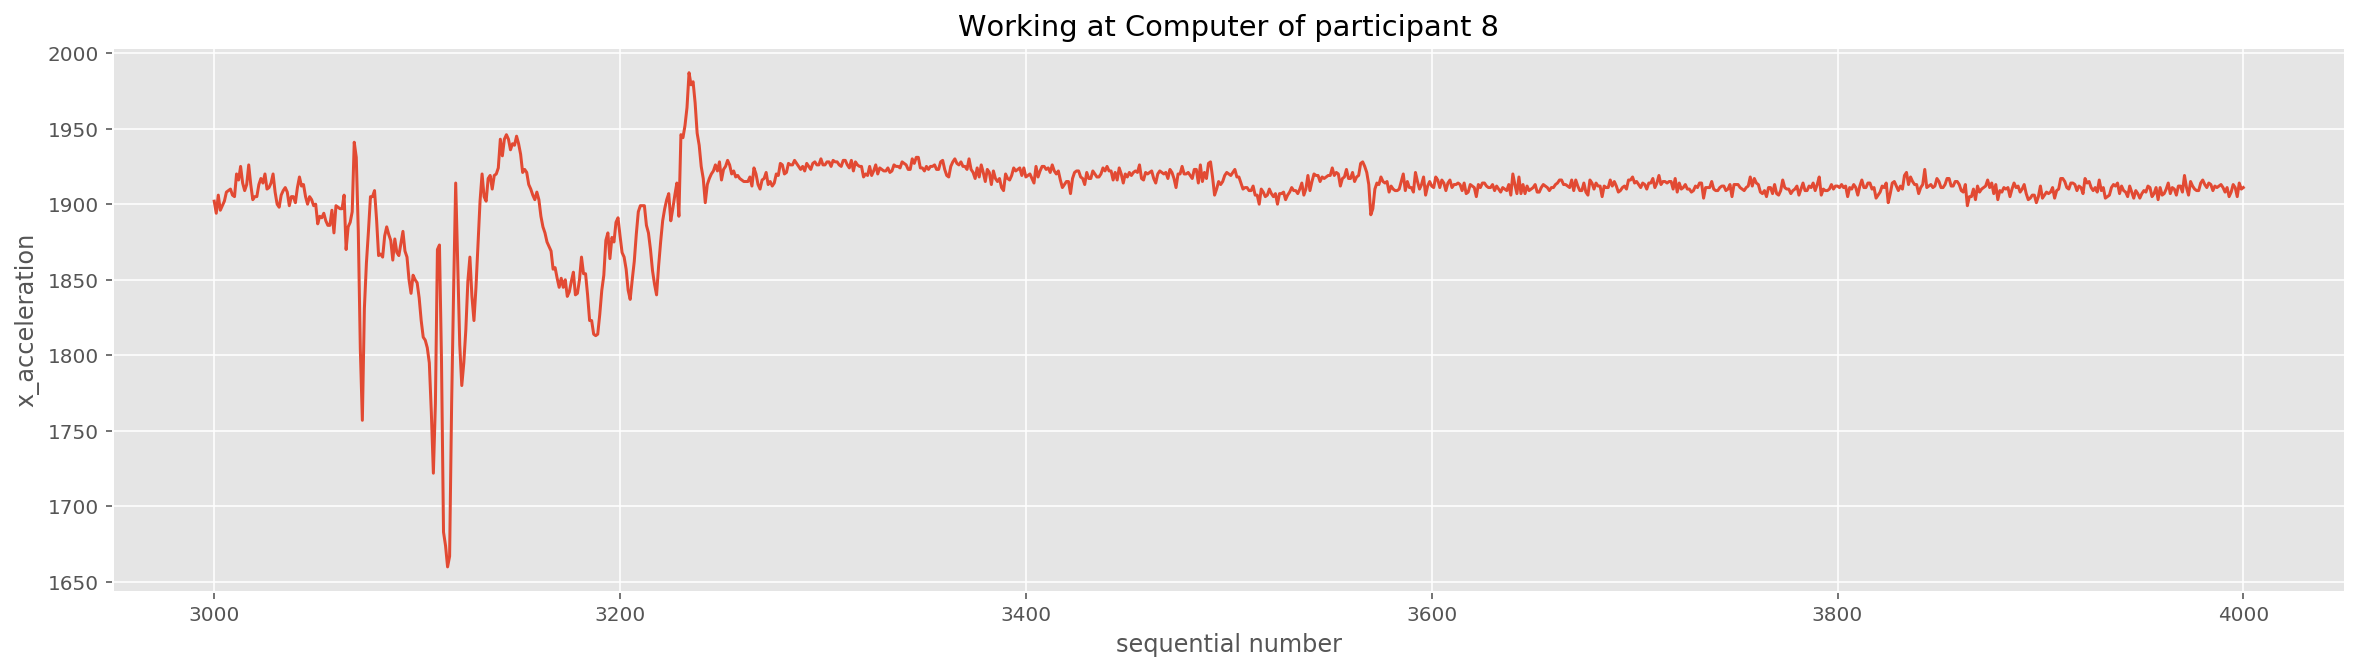

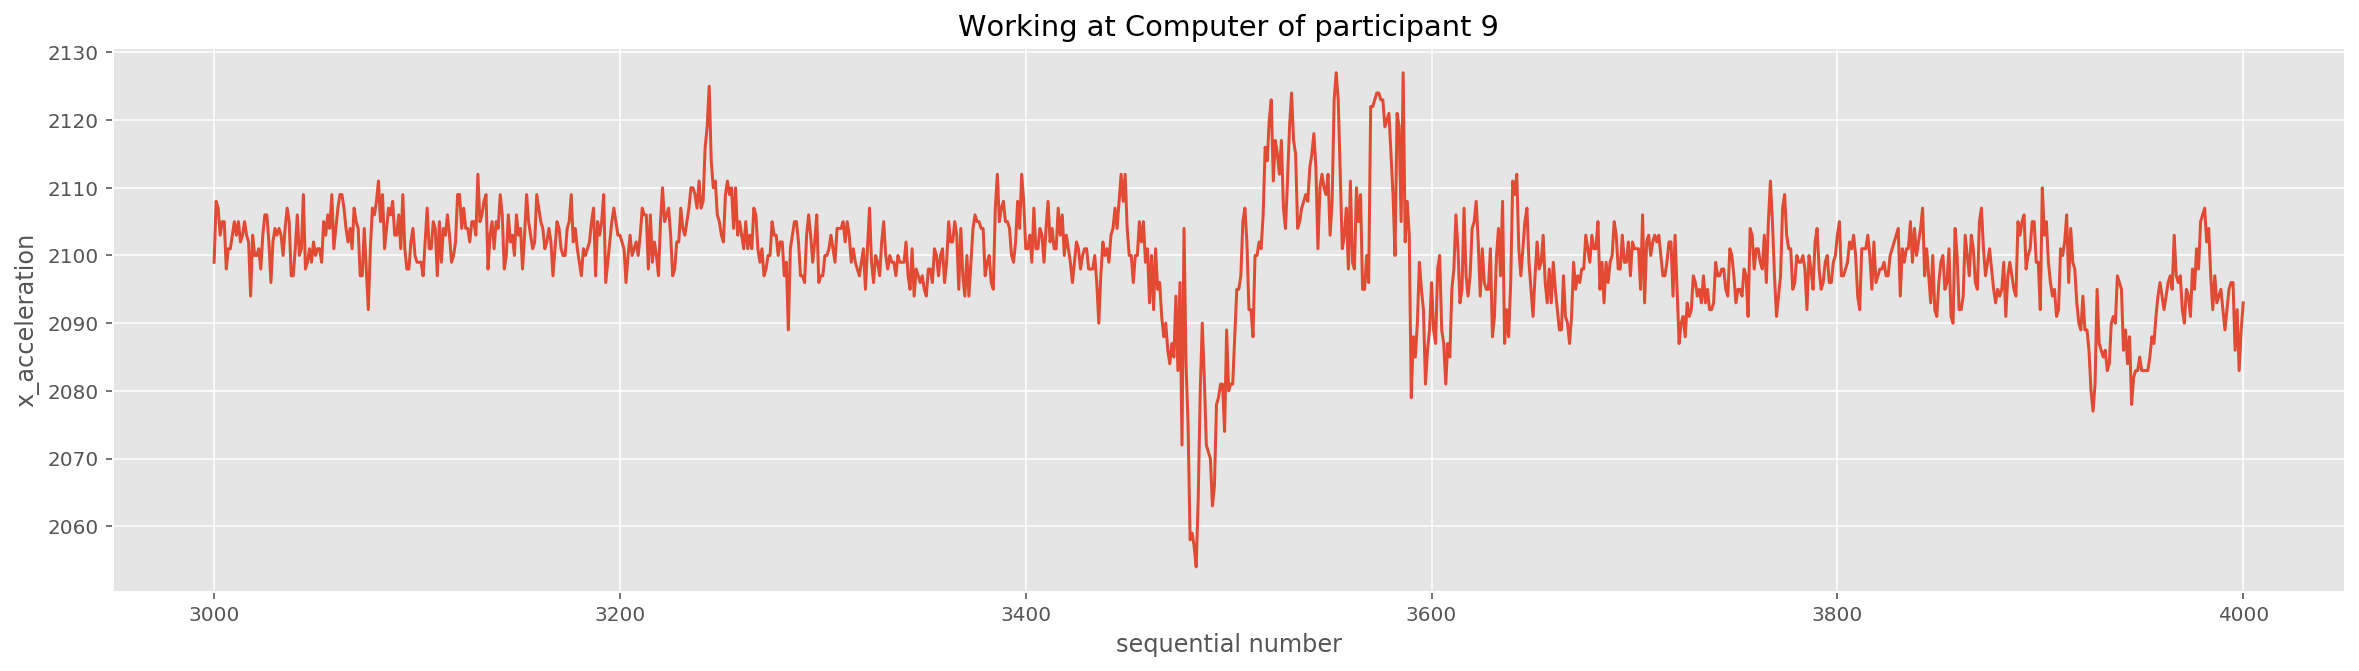

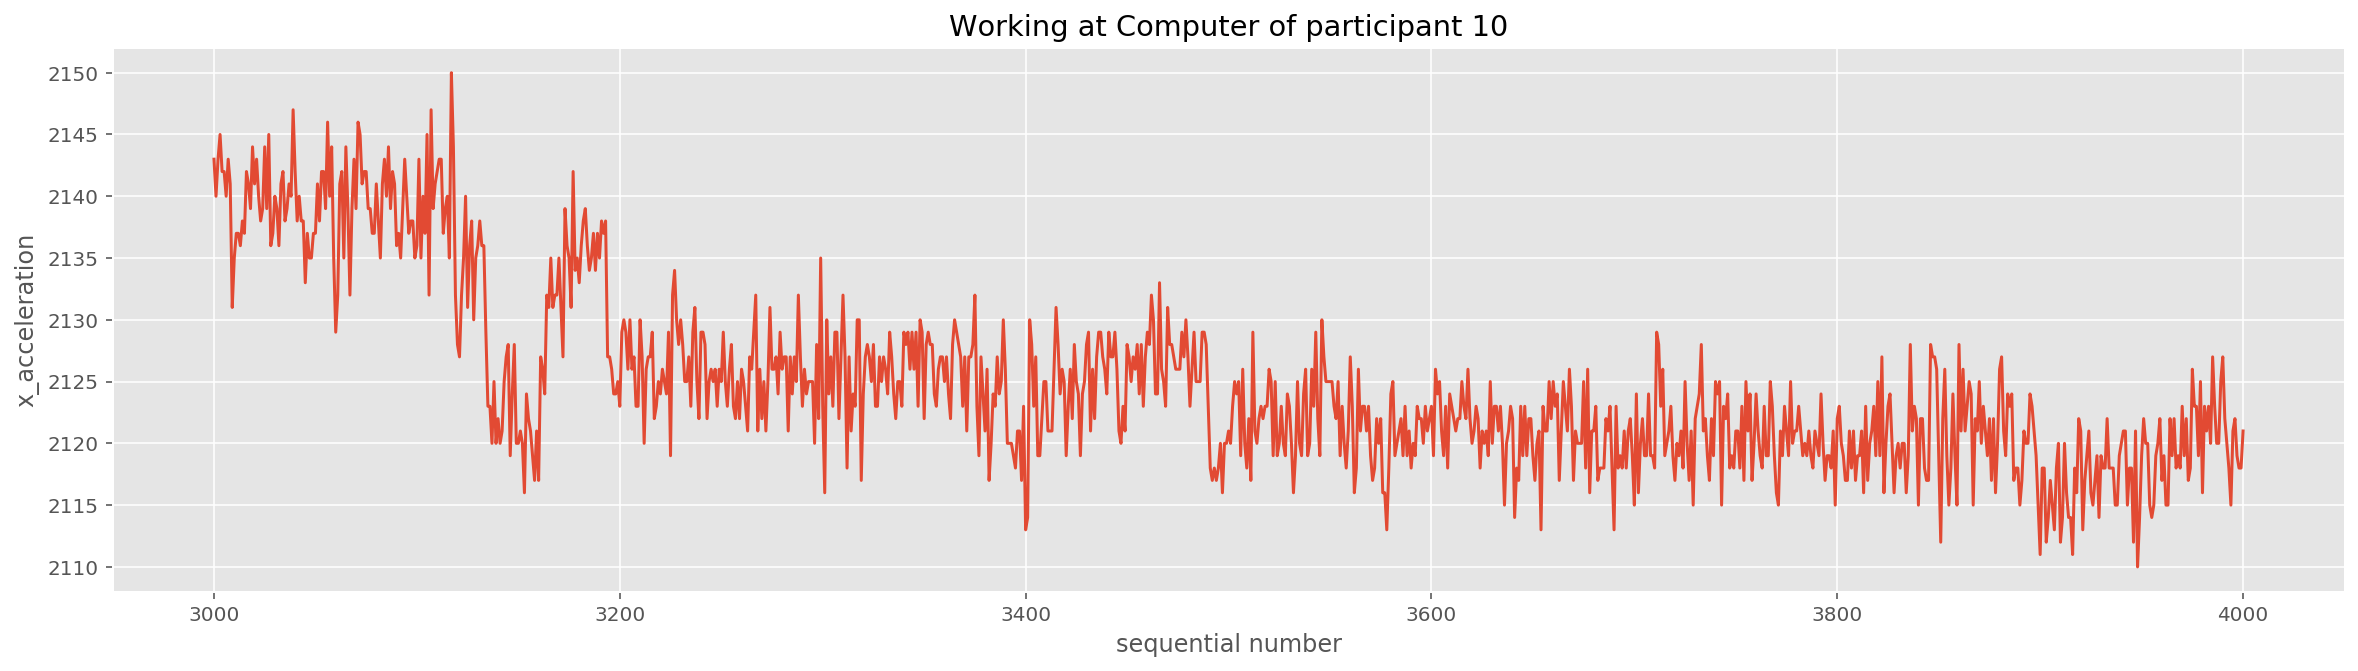

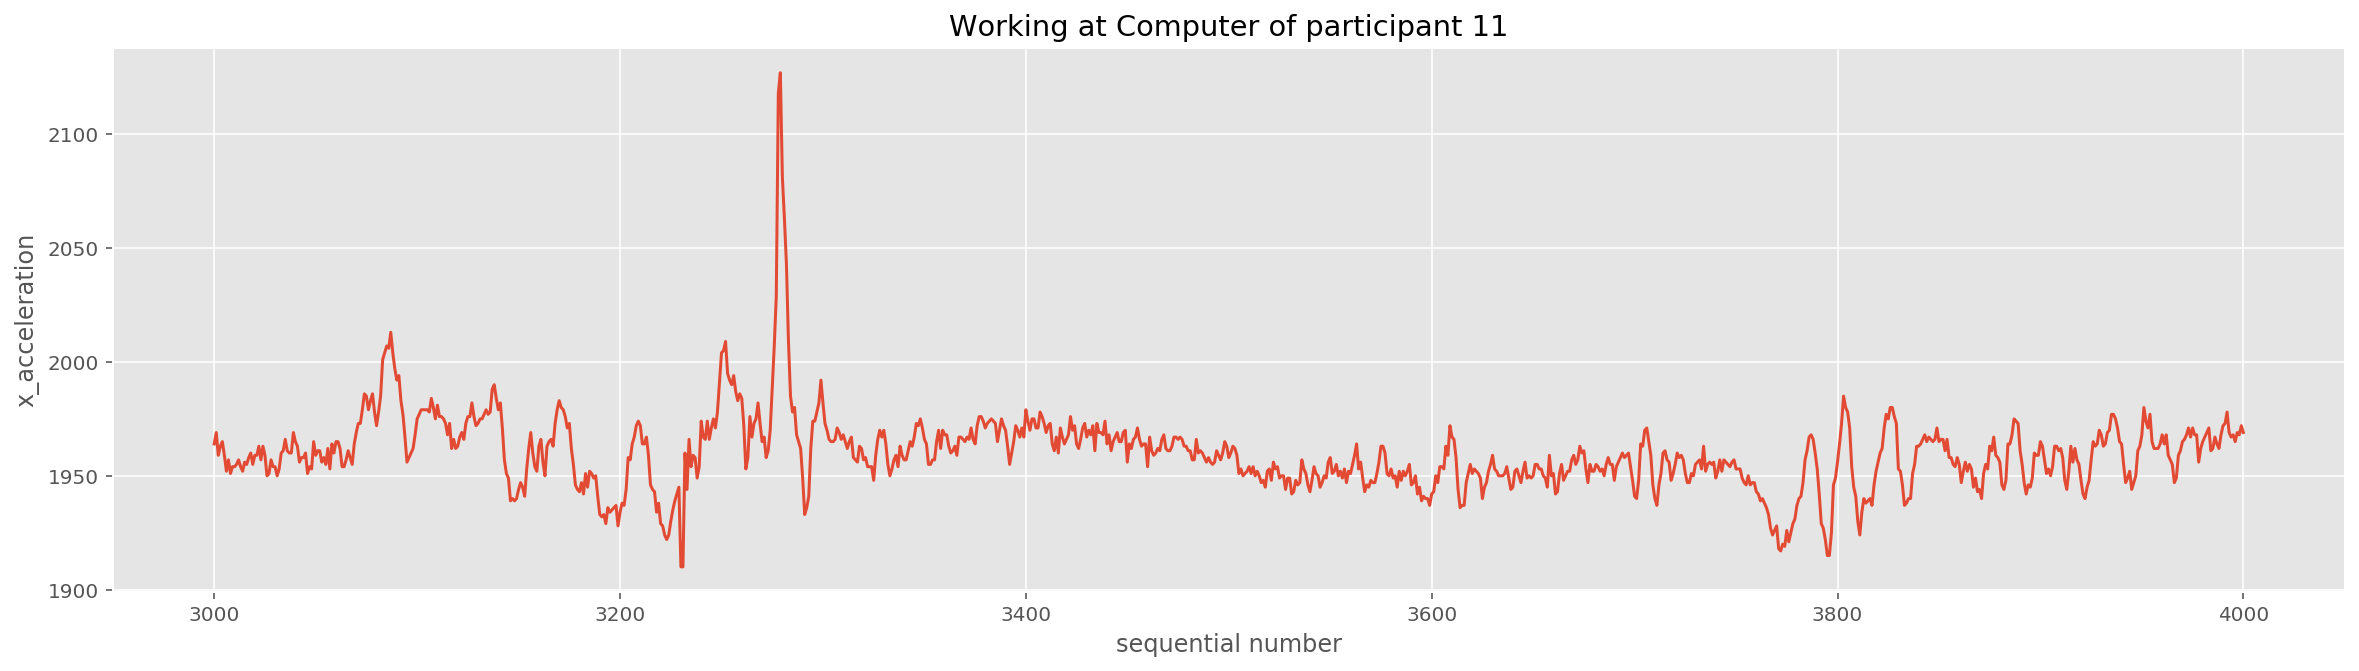

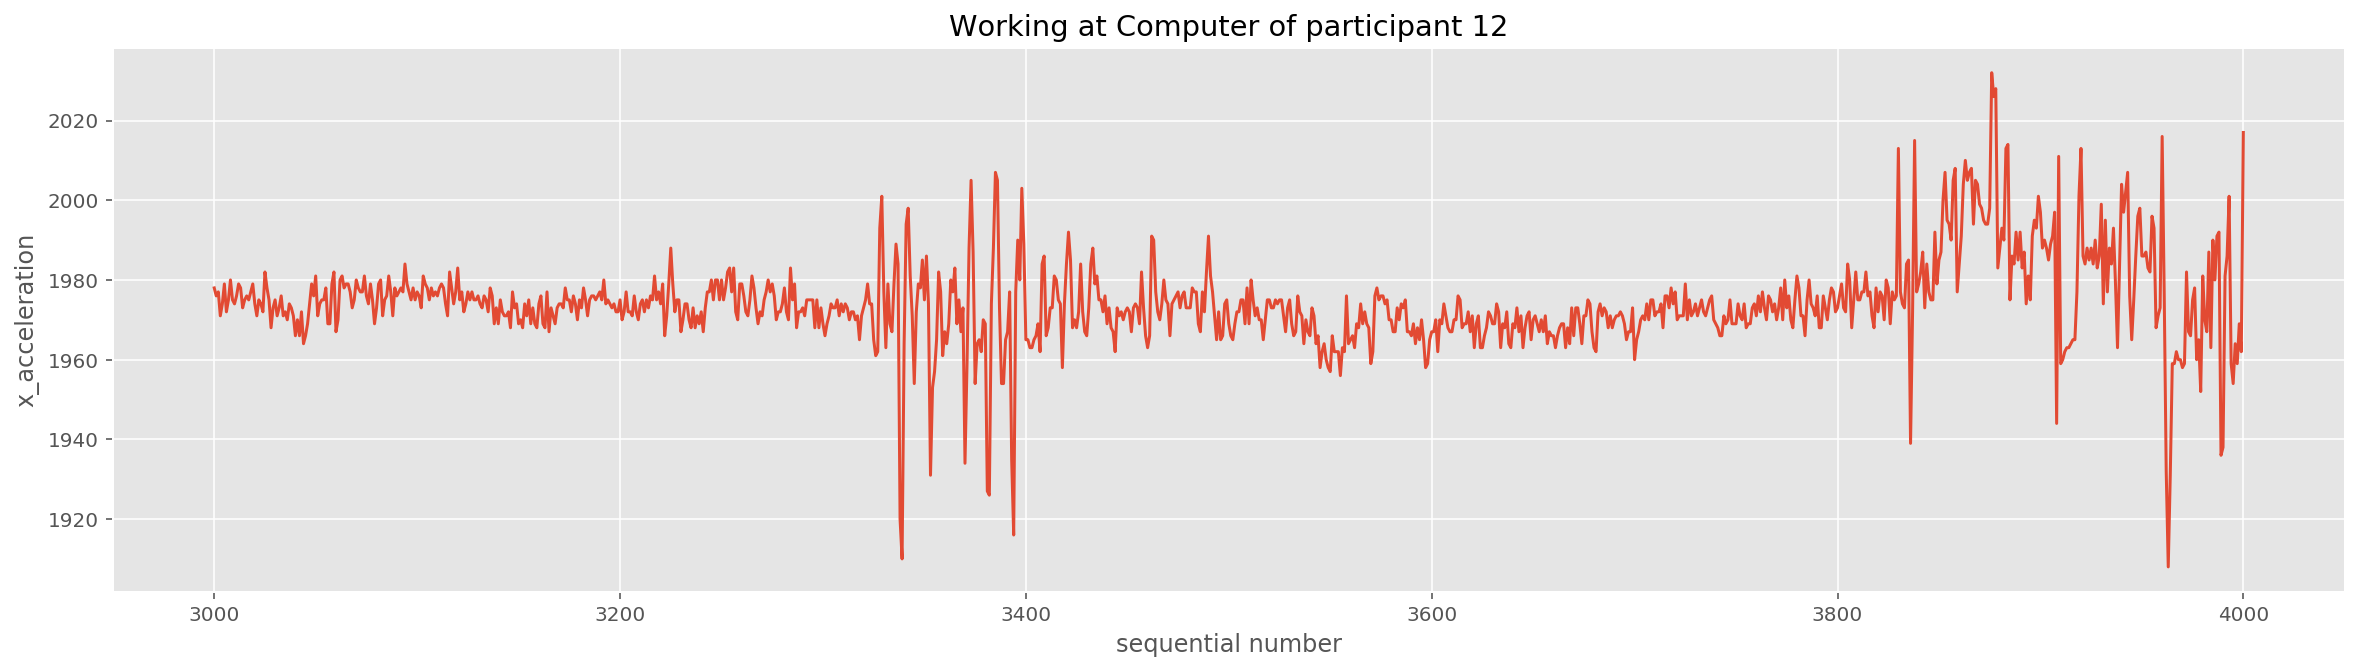

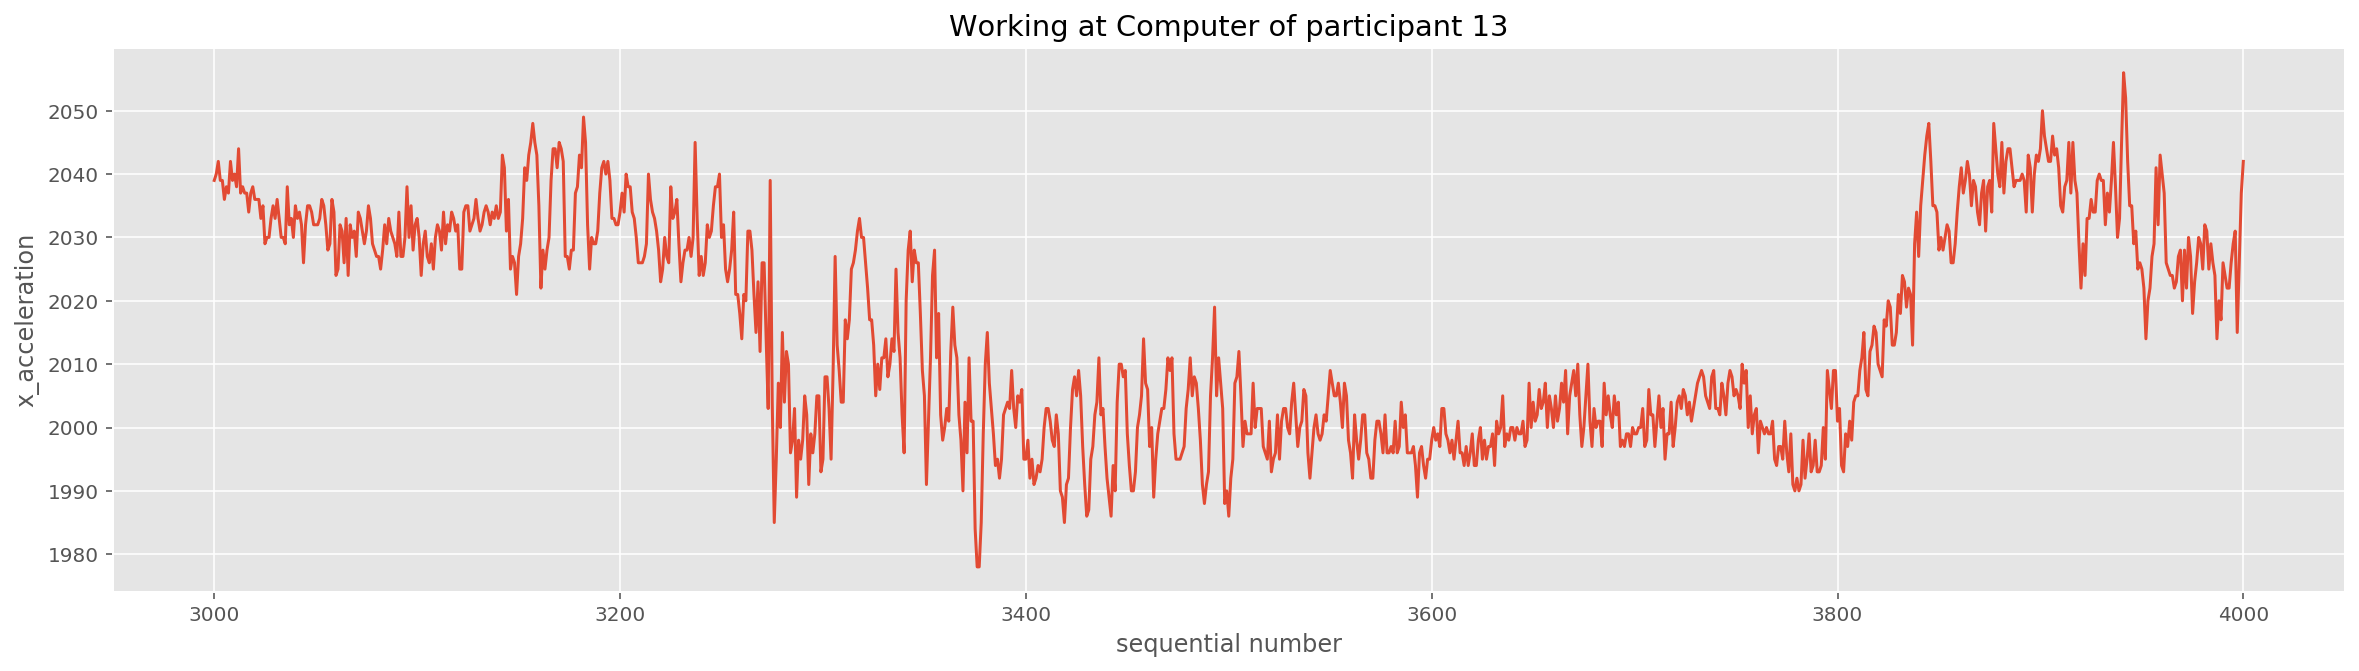

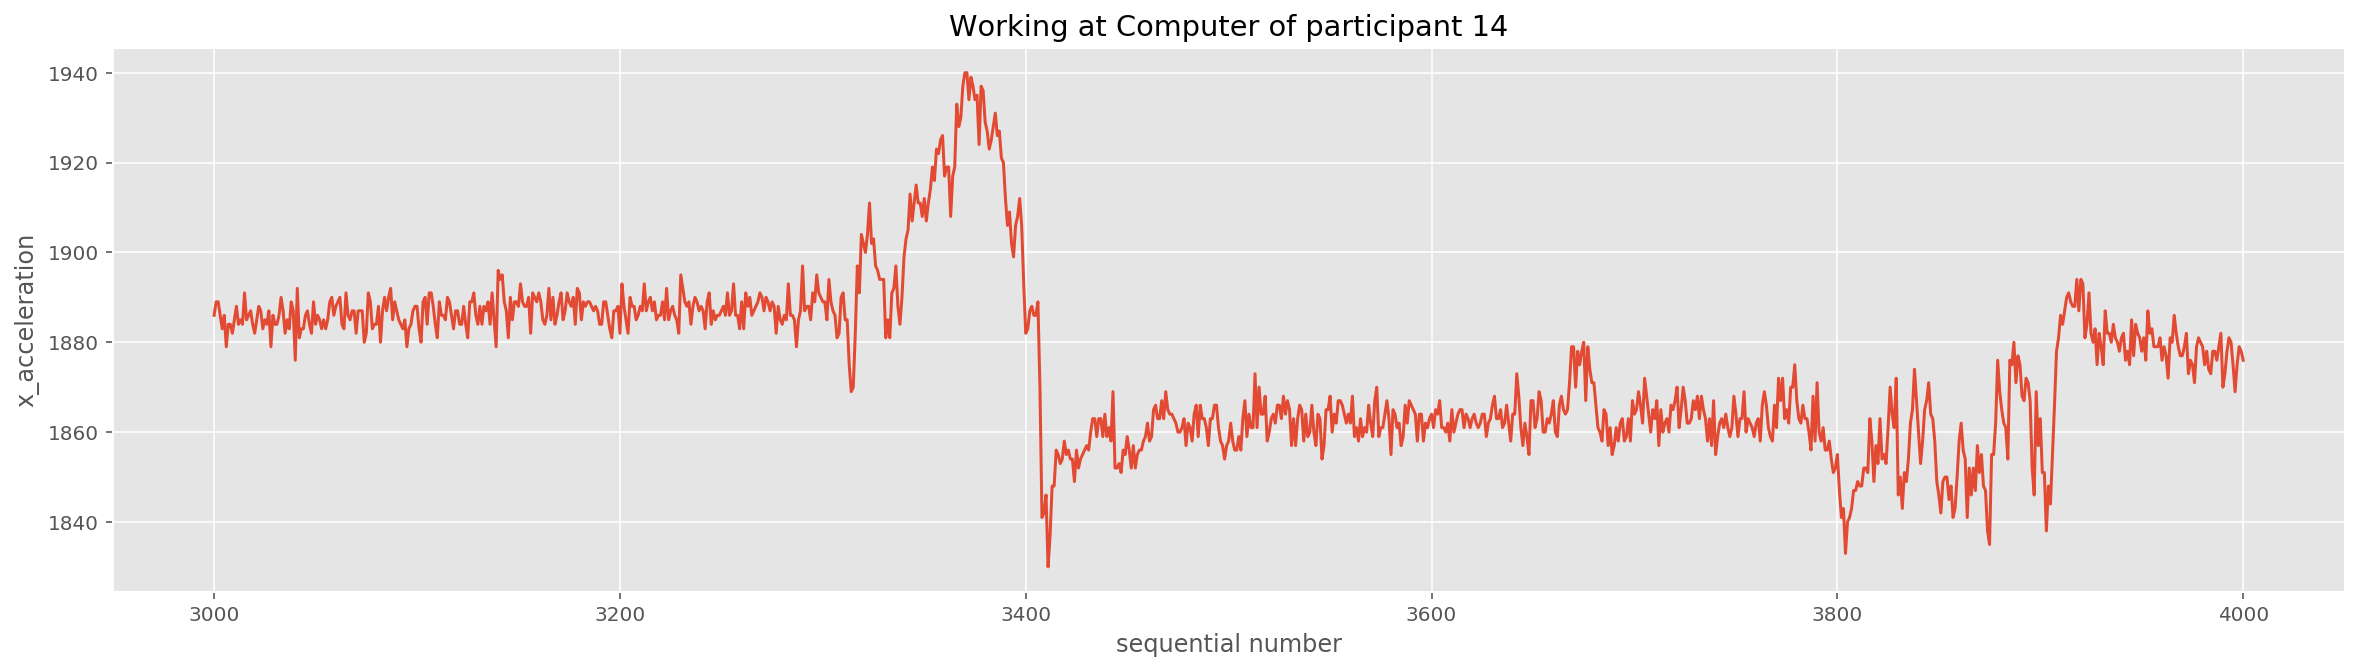

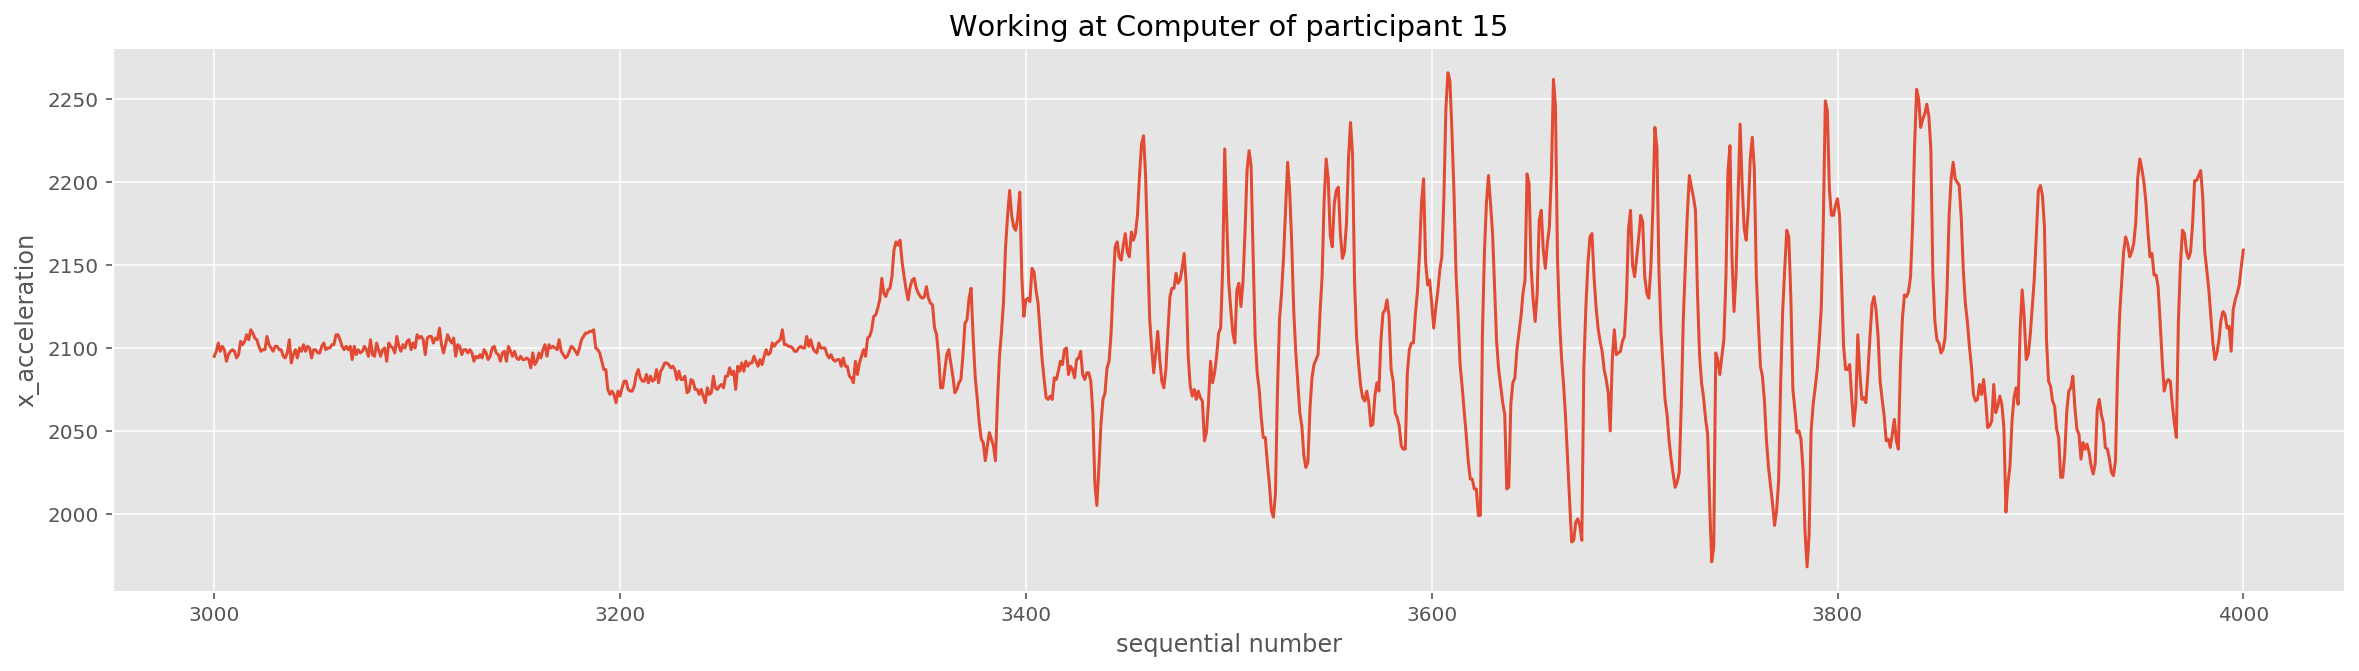

In [39]:
plot_activity_participants_timespan(df_all_cleaned, 
                                    train_filenames + test_filenames, 
                                    activity=1, 
                                    feature='x_acceleration', 
                                    start=0, 
                                    stop=4000)

We can observe, that we removed a part of the outliers as the minimum and maximum values of the desriptive features represents more appropriate values as at the beginning. In the following, we explore the relationships and interactions among the various features. We expect a correlation among the acceleration features and the activity feature as the accelerations can differ between the various performed activities. Furthermore, the accelerations should also be related to each other as the movement influences each dimension of the accelerometer. However, we expect a weak correlation between the x-acceleration/y-acceleration and the z-acceleration as some movements don't involve the change of the direction.

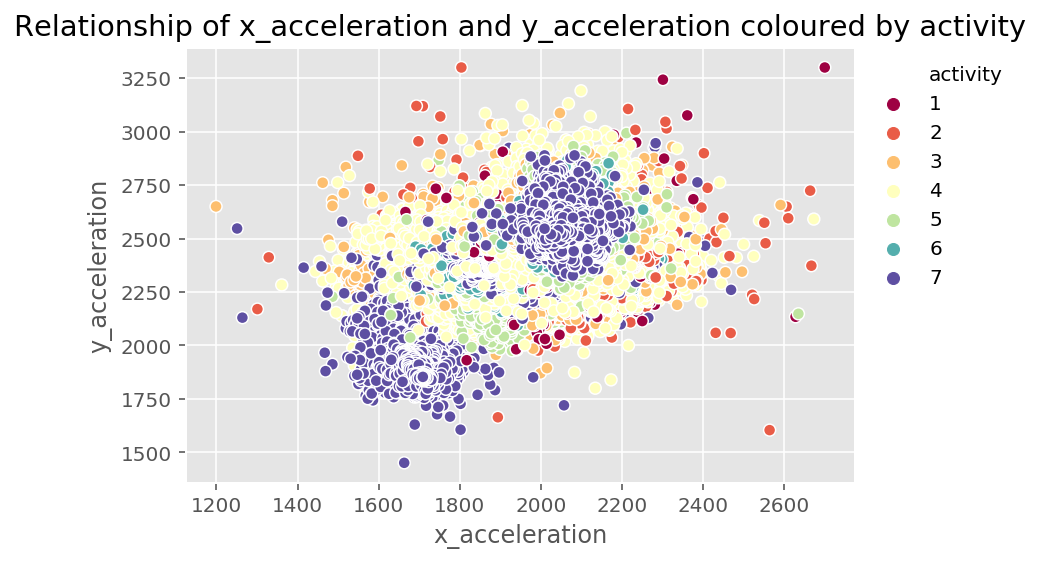

In [40]:
plot_continuous_pair('x_acceleration', 'y_acceleration', 'activity', df_all_cleaned)

In [41]:
print('X & Y - correlation coefficient:', 
      np.corrcoef(df_all_cleaned['x_acceleration'], df_all_cleaned['y_acceleration'])[0, 1].round(3))

X & Y - correlation coefficient: 0.38


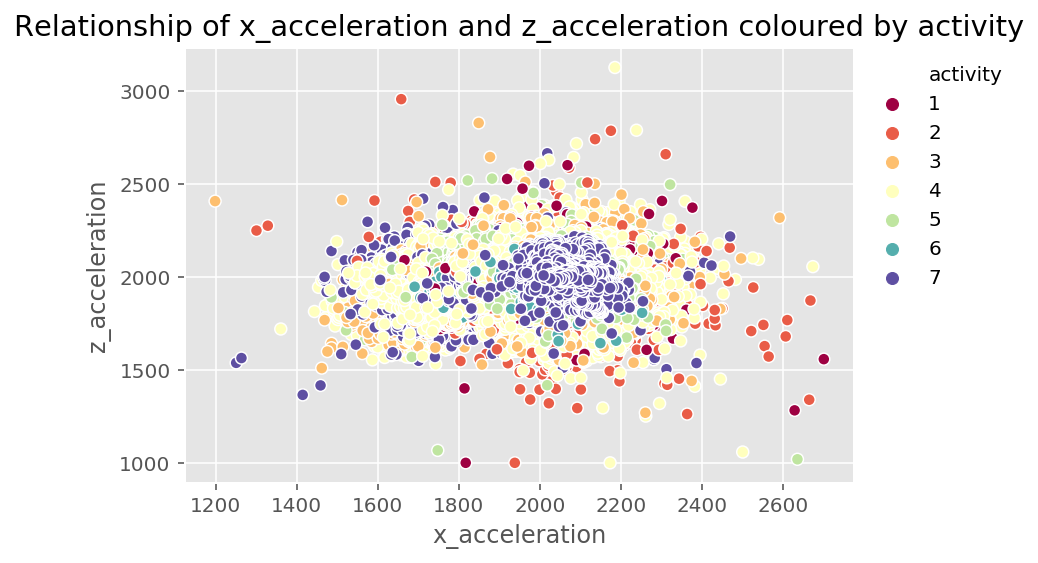

In [42]:
plot_continuous_pair('x_acceleration', 'z_acceleration', 'activity', df_all_cleaned)

In [43]:
print('X & Z - correlation coefficient:', 
      np.corrcoef(df_all_cleaned['x_acceleration'], df_all_cleaned['z_acceleration'])[0, 1].round(3))

X & Z - correlation coefficient: 0.019


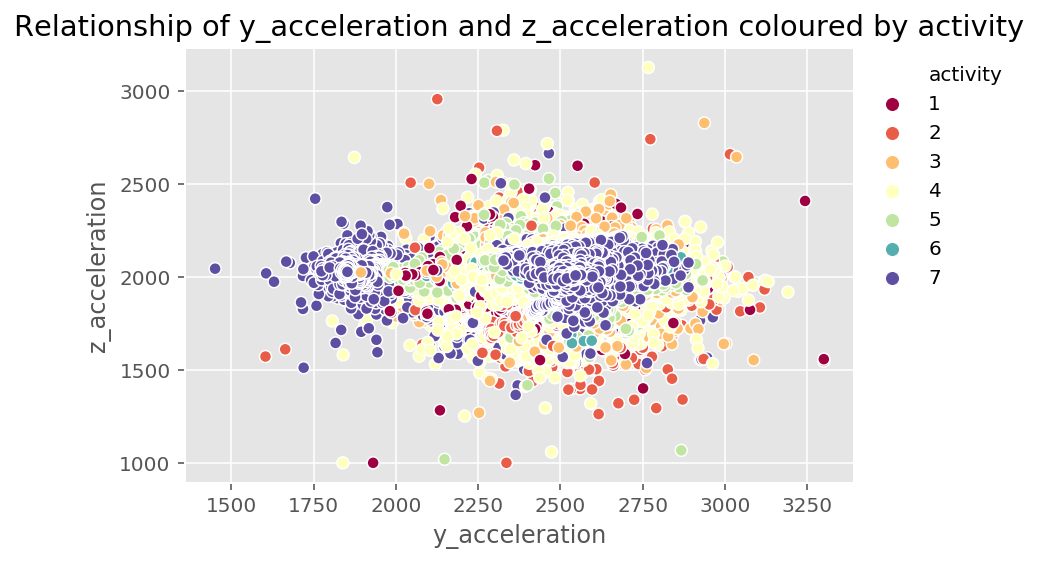

In [44]:
plot_continuous_pair('y_acceleration', 'z_acceleration', 'activity', df_all_cleaned)

In [45]:
print('Y & Z - correlation coefficient:', 
      np.corrcoef(df_all_cleaned['y_acceleration'], df_all_cleaned['z_acceleration'])[0, 1].round(3))

Y & Z - correlation coefficient: 0.32


The correlation of `X & Y` and `X & Z` supports our aforementioned hypothesis about the movements and accelerations. However, the `Y & Z` correlation differs from the assumption and has a higher correlation than expected. Moreover, we can observe that the acceleration data of all activities are quite similar in terms of the visualized clusters. In the following, we visualize the relationship among the desriptive features and target feature by using the violin plot. 

Thereby, we expect a high correlation between the accelerations and the target features activity which would support a good prediction score.

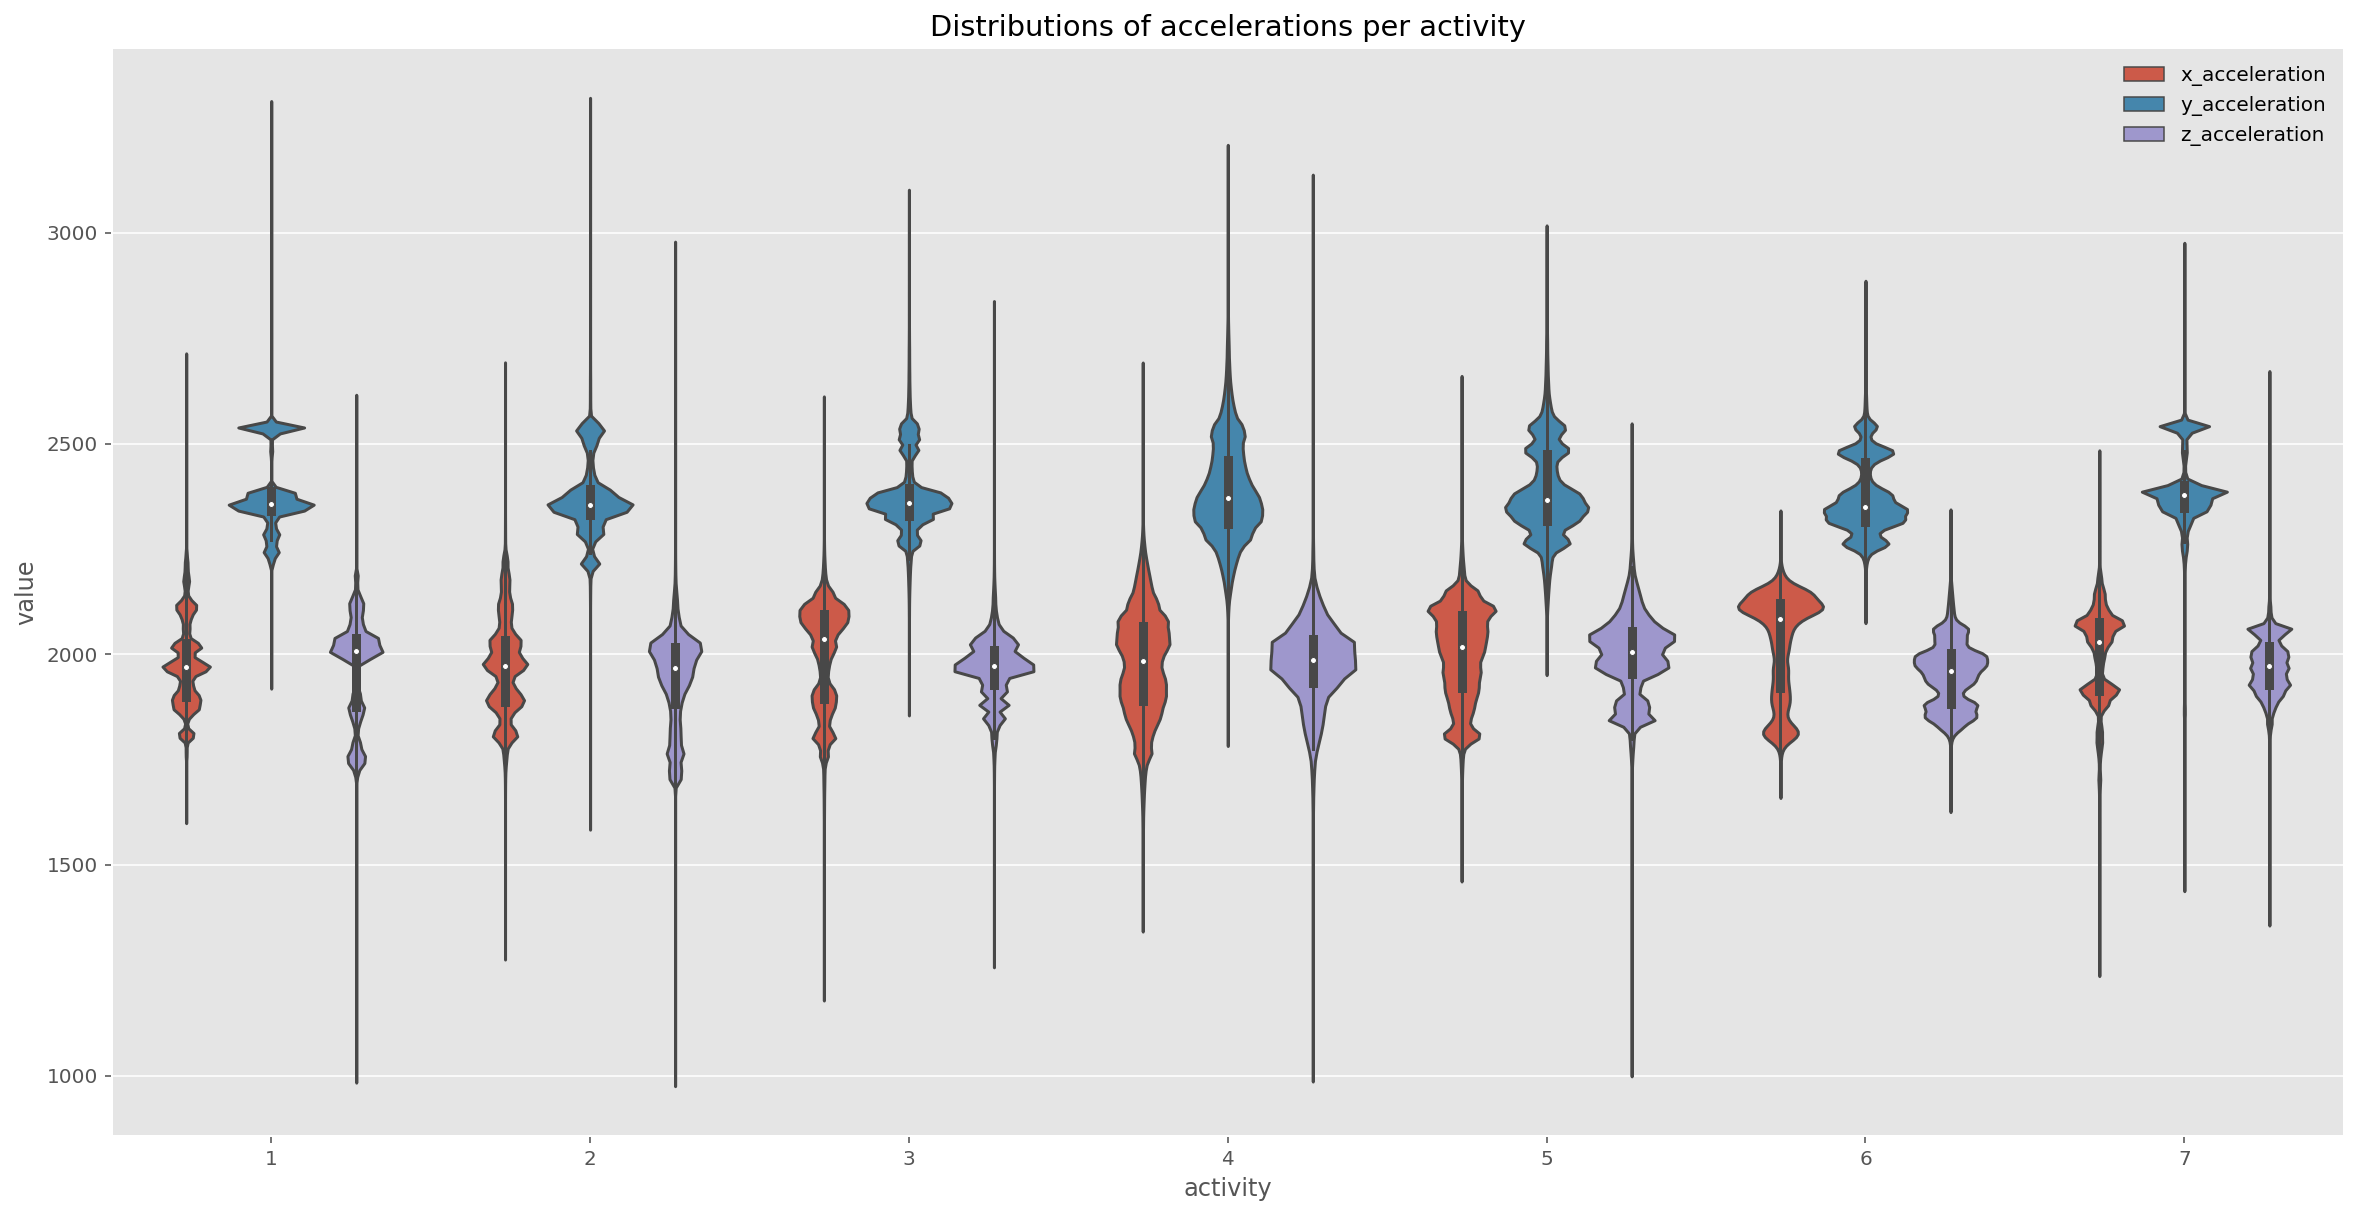

In [46]:
df_all_without_participant = df_all_cleaned.drop('participant', axis=1)
plot_accelerations_activities_violin('activity', 'value', 'acceleration', 
                                     df_all_without_participant.melt(id_vars=['activity'], var_name='acceleration'))

In [47]:
print('X-acceleration & Activity - correlation coefficient:', 
      np.corrcoef(df_all_cleaned['x_acceleration'], df_all_cleaned['activity'])[0, 1].round(3))
print('Y-acceleration & Activity - correlation coefficient:', 
      np.corrcoef(df_all_cleaned['y_acceleration'], df_all_cleaned['activity'])[0, 1].round(3))
print('Z-acceleration & Activity - correlation coefficient:', 
      np.corrcoef(df_all_cleaned['z_acceleration'], df_all_cleaned['activity'])[0, 1].round(3))

X-acceleration & Activity - correlation coefficient: 0.084
Y-acceleration & Activity - correlation coefficient: 0.034
Z-acceleration & Activity - correlation coefficient: 0.024


Finally, we observe a weak correlation between the accelerations and the activities as visualized by the violin plot. With this dataset we can expect low performance for the human activity classification. A good approach to deal with this issue is to create new descriptive features based on the acceleration data. Therefore, we use a sliding window approach which calculates new features for a defined timeframe.

## Feature Engineering <a id='feature_engineering'></a>

In this section, we calculate new descriptive features based on the acceleration data. Thereby, we follow the approach of sliding windows. Before the calculations, we filter the low and high frequency components as proposed by [5]. Based on the raw, low frequency and high frequency data, we calculate common features such as the mean, skewness, kurtosis, pair-correlation and so on. 

In [48]:
from scipy.signal import butter, lfilter, freqz

In [49]:
# Reference: [4]
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [50]:
# Filter settings
order = 6
fs = 156.0
cutoff = 4.0

Let's create the low and high frequency components for each acceleration axis.

In [51]:
df_all_cleaned['x_acceleration_low'] = butter_lowpass_filter(df_all_cleaned['x_acceleration'], cutoff, fs, order)
df_all_cleaned['y_acceleration_low'] = butter_lowpass_filter(df_all_cleaned['y_acceleration'], cutoff, fs, order)
df_all_cleaned['z_acceleration_low'] = butter_lowpass_filter(df_all_cleaned['z_acceleration'], cutoff, fs, order)
df_all_cleaned['x_acceleration_high'] = butter_highpass_filter(df_all_cleaned['x_acceleration'], cutoff, fs, order)
df_all_cleaned['y_acceleration_high'] = butter_highpass_filter(df_all_cleaned['y_acceleration'], cutoff, fs, order)
df_all_cleaned['z_acceleration_high'] = butter_highpass_filter(df_all_cleaned['z_acceleration'], cutoff, fs, order)

### Helper Methods

In [52]:
# Sliding window approach with a window size and window overlap
def sliding_window(data, window_size=52, window_overlap=0):
    shift = int(window_size - (window_size * window_overlap))
    length = data.shape[0]
    step = 0
    while True:
        if (step * shift + window_size) - 1 >= length:
            yield data.iloc[step * shift: length]
            break
        yield data.iloc[step * shift: (step * shift + window_size) - 1]
        step += 1

In [53]:
# Reference: Adapted from [3]
# Create all features based on the generated windows
def create_features(data, window_size, window_overlap):
    from collections import defaultdict
    from scipy.stats import kurtosis
    
    df_activities = []
    for activity, group in data.groupby('activity'):
        df_activity = defaultdict(list)
        for window in sliding_window(group, window_size, window_overlap):
            
            if(window.shape[0] == 0):
                continue
                
            # Basic features
            for feature in ['x_acceleration', 'y_acceleration', 'z_acceleration',
                            'x_acceleration_low', 'y_acceleration_low', 'z_acceleration_low',
                            'x_acceleration_high', 'y_acceleration_high', 'z_acceleration_high']:
                df_activity[feature + '_mean'].append(window[feature].mean())
                df_activity[feature + '_std'].append(window[feature].std())
                df_activity[feature + '_skew'].append(window[feature].skew())
                df_activity[feature + '_kurtosis'].append(window[feature].kurtosis())
                df_activity[feature + '_max_min'].append(max(window[feature]) - min(window[feature]))
                df_activity[feature + '_rms'].append(np.sqrt(np.mean(np.square(window[feature]))))

            # Correlations
            df_activity['xy_corr'].append(window.corr().loc['x_acceleration', 'y_acceleration'])
            df_activity['yz_corr'].append(window.corr().loc['y_acceleration', 'z_acceleration'])
            df_activity['zx_corr'].append(window.corr().loc['z_acceleration', 'x_acceleration'])
            
            df_activity['xy_low_corr'].append(window.corr().loc['x_acceleration_low', 'y_acceleration_low'])
            df_activity['yz_low_corr'].append(window.corr().loc['y_acceleration_low', 'z_acceleration_low'])
            df_activity['zx_low_corr'].append(window.corr().loc['z_acceleration_low', 'x_acceleration_low'])
            
            df_activity['xy_high_corr'].append(window.corr().loc['x_acceleration_high', 'y_acceleration_high'])
            df_activity['yz_high_corr'].append(window.corr().loc['y_acceleration_high', 'z_acceleration_high'])
            df_activity['zx_high_corr'].append(window.corr().loc['z_acceleration_high', 'x_acceleration_high'])
                    
            # Fourier transforms
            x_fft = abs(np.fft.rfft(window['x_acceleration']))
            y_fft = abs(np.fft.rfft(window['y_acceleration']))
            z_fft = abs(np.fft.rfft(window['z_acceleration']))

            df_activity['x_freq_max'].append(np.argmax(x_fft))
            df_activity['y_freq_max'].append(np.argmax(y_fft))
            df_activity['z_freq_max'].append(np.argmax(z_fft))

            df_activity['x_fft_max'].append(x_fft.max())
            df_activity['y_fft_max'].append(y_fft.max())
            df_activity['z_fft_max'].append(z_fft.max())
            
            df_activity['x_fft_mean'].append(x_fft.mean())
            df_activity['y_fft_mean'].append(y_fft.mean())
            df_activity['z_fft_mean'].append(z_fft.mean())

            df_activity['x_fft_std'].append(x_fft.std())
            df_activity['y_fft_std'].append(y_fft.std())
            df_activity['z_fft_std'].append(z_fft.std())

            df_activity['x_fft_kurtosis'].append(kurtosis(x_fft))
            df_activity['y_fft_kurtosis'].append(kurtosis(y_fft))
            df_activity['z_fft_kurtosis'].append(kurtosis(z_fft))
            
            # Target feature
            df_activity['activity'].append(activity)
            
        df_activities.append(pd.DataFrame(df_activity))
    return pd.concat(df_activities, ignore_index=True).dropna()

### Feature Creation

Based on the raw, low frequency and high frequency data, we can create all defined descriptive features. Therefore, we set the `window_size=156` timesteps and the `window_overlap=0` which have shown the best experimental results. Furthermore, we divide the entire dataset into a train and test set to evaluate our classification model on "unseen" data. The train data consists of the participants 1 to 12 and the test data of the participants 13 to 15 which results into 80% train participants and 20% test participants.

In [54]:
# Window settings
window_size = 156 # 3 seconds
window_overlap = 0

In [55]:
df_train = pd.concat([create_features(df_all_cleaned[df_all_cleaned['participant'] == int(participant)], 
                                      window_size, window_overlap) for participant in train_filenames])

In [56]:
df_train.shape

(10298, 79)

In [57]:
df_test = pd.concat([create_features(df_all_cleaned[df_all_cleaned['participant'] == int(participant)], 
                                     window_size, window_overlap) for participant in test_filenames])

In [58]:
df_test.shape

(1793, 79)

## Data Modelling <a id='data_modelling'></a>

In the section data modelling, we search for the optimal model by applying hyperparameter tuning in a k-fold cross validation fashion with `GridSearchCV`. Furthermore, we perform feature selection by using the feature importances determined by the `RandomForestClassifier` to get the most relevant descriptive features. After feature selection and hyperparameter tuning, we examine the optimal models with the test data and compare the performance with the performance metric `f1 score`. Thereby, we investigate the following classification models provided by `sklearn`:

- `KNeighborsClassifier`
- `DecisionTreeClassifier`

In [59]:
# Separate the train and test data into descriptive features and target feature
X_train = df_train.drop('activity', axis=1).values
y_train = df_train['activity']
X_test = df_test.drop('activity', axis=1).values
y_test = df_test['activity']

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (10298, 78)
X_test shape: (1793, 78)


In [60]:
# Standardize the datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Feature Selection

Let's apply feature selection by using the feature importances of the `RandomForestClassifier` and use this features for our classification models.

In [61]:
# Feature number for feature importances
num_features_plot = X_train.shape[1]

In [62]:
rf = RandomForestClassifier().fit(X_train, y_train)

In [63]:
fs_indices_rf = np.argsort(rf.feature_importances_)[::-1][0:num_features_plot]

best_features_rf = df_train.drop('activity', axis=1).columns[fs_indices_rf].values
feature_importances_rf = rf.feature_importances_[fs_indices_rf]

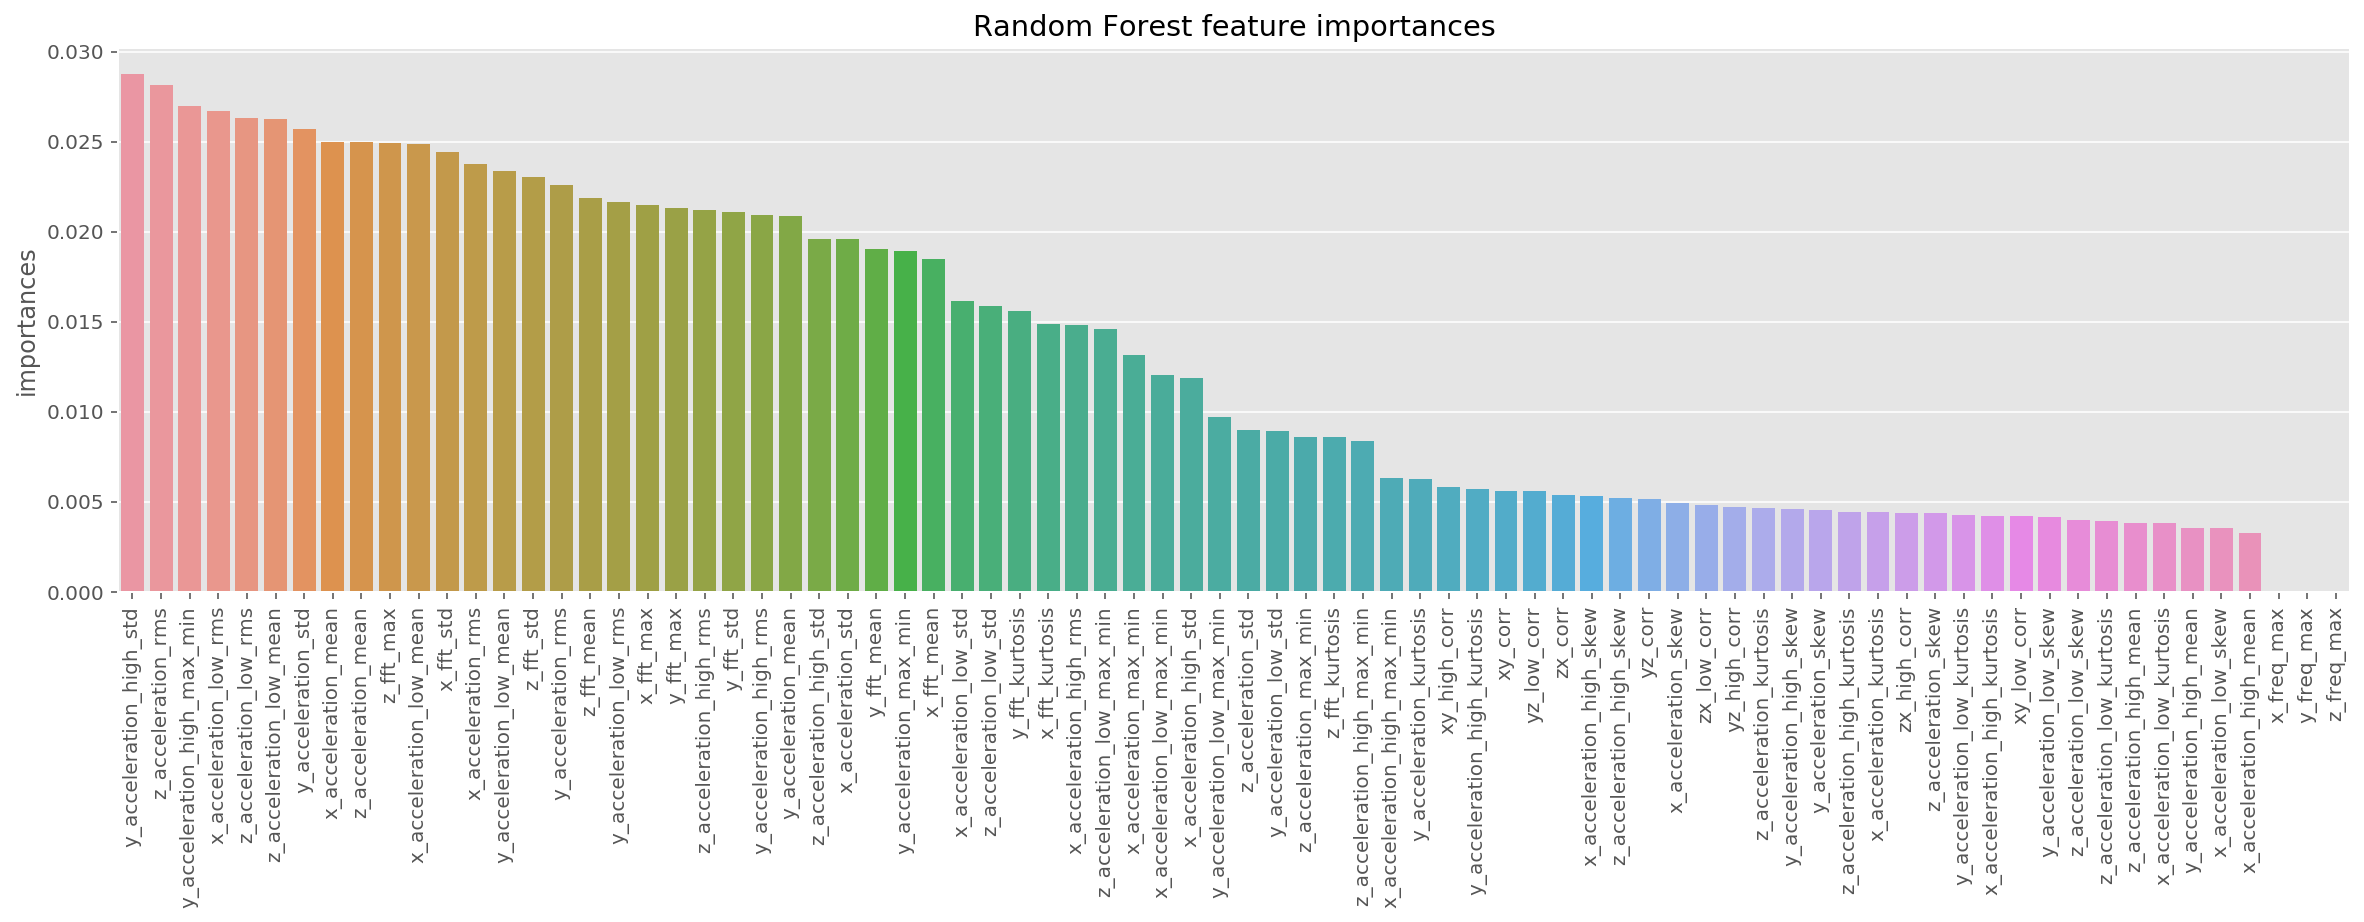

In [64]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Random Forest feature importances')
sns.barplot(best_features_rf, feature_importances_rf, ax=ax)
ax.set_ylabel('importances')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

Almost the half amount of features seem to have low importance for the prediction of the corresponding activity. The features `x_freq_max`, `y_freq_max` and `z_freq_max` have no importance for the prediction regarding the random forest model. Hence, we consider only 75 descriptive features in the following `GridSearchCV` model tuning. Other approaches for feature selection could be hill-climbing or k-best based on mutual information and so on. The package `sklearn` provides with `SelectKBest` such an approach.

### Training & Hyperparameter Tuning

In [65]:
# Reference: [6]
# Custom function to format the search results as a Pandas data frame.
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
                  'std_score': np.std(scores),
                  'min_score': np.min(scores),
                  'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

In [66]:
from sklearn.base import BaseEstimator, TransformerMixin

# Reference: [6]
# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

Since the dataset is highly imbalanced, we use the f1 score as scoring method.

In [67]:
# Cross-validation method
cv_method = StratifiedKFold(n_splits=5,
                            random_state=seed)

# Performance metric GridSearchCV
scoring_method = make_scorer(f1_score , average='macro')

#### KNeighborsClassifier

In [68]:
params_knn = {'rfi_fs__n_features_': [10, 30, 75],
              'knn__n_neighbors': [1, 3, 5, 10, 20],
              'knn__p': [1, 2, 5],
              'knn__weights': ['uniform', 'distance']}

pipe_knn = Pipeline([('rfi_fs', RFIFeatureSelector()),
                     ('knn', KNeighborsClassifier())])

gs_knn = GridSearchCV(estimator=pipe_knn,
                      param_grid=params_knn,
                      cv=cv_method,
                      scoring=scoring_method,
                      return_train_score=False,
                      n_jobs=-2,
                      verbose=2)

gs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-2)]: Done 450 out of 450 | elapsed: 37.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=999, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rfi_fs',
                                        RFIFeatureSelector(n_features_=10)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=-2,
             param_grid={'knn

In [69]:
gs_knn.best_params_

{'knn__n_neighbors': 5,
 'knn__p': 1,
 'knn__weights': 'distance',
 'rfi_fs__n_features_': 75}

In [70]:
gs_knn.best_estimator_

Pipeline(memory=None,
         steps=[('rfi_fs', RFIFeatureSelector(n_features_=75)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=1,
                                      weights='distance'))],
         verbose=False)

In [71]:
fs_knn_indices = gs_knn.best_estimator_.steps[0][1].fs_indices_

In [72]:
gs_knn.best_score_.round(3)

0.421

In [73]:
results_knn  = get_search_results(gs_knn)
results_knn.head()

mean_score  std_score max_score min_score knn__n_neighbors knn__p  \
41   0.421059  0.0729557  0.509216   0.31022                5      1   
23   0.418511  0.0733263  0.507285  0.314556                3      1   
20   0.417542  0.0746568  0.502482  0.305283                3      1   
38   0.414145  0.0731179  0.498657  0.308794                5      1   
59   0.412676  0.0774496  0.498748  0.310711               10      1   

   knn__weights rfi_fs__n_features_  
41     distance                  75  
23     distance                  75  
20      uniform                  75  
38      uniform                  75  
59     distance                  75

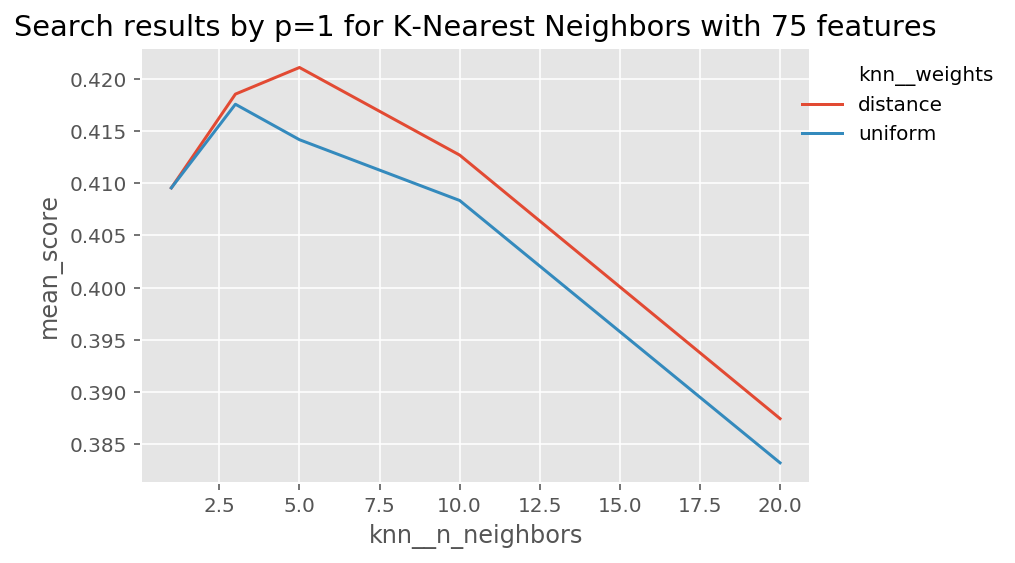

In [74]:
results_knn = results_knn[(results_knn['knn__p'] == 1) & (results_knn['rfi_fs__n_features_'] == 75)]
results_knn['mean_score'] = results_knn['mean_score'].astype(np.number)
results_knn['knn__n_neighbors'] = results_knn['knn__n_neighbors'].astype(np.number)

plt.title('Search results by p=1 for K-Nearest Neighbors with 75 features')
sns.lineplot(x='knn__n_neighbors', 
             y='mean_score', 
             hue='knn__weights',
             ci=None,
             legend='full',
             data=results_knn)
plt.legend(bbox_to_anchor=(1.4, 1), 
           facecolor="white", 
           frameon=False)

Based on the search results, we can see the optimal parameters of the k-nearest neighbors model. The best search results occur with 75 descriptive features and p=1 as distance measure. According to the curve shape, we don't expect more accurate predictions by choosing lower or higher values for the hyperparameters.

#### DecisionTreeClassifier

In [75]:
params_dt = {'rfi_fs__n_features_': [10, 30, 75],
             'dt__criterion': ['gini', 'entropy'],
             'dt__max_depth': [5, 8, 10, 15, 20, 25],
             'dt__min_samples_split': [2, 3, 5, 10, 15]}

pipe_dt = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier())])

gs_dt = GridSearchCV(estimator=pipe_dt,
                      param_grid=params_dt,
                      cv=cv_method,
                      scoring=scoring_method,
                      return_train_score=False,
                      n_jobs=-2,
                      verbose=2)

gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-2)]: Done 642 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-2)]: Done 900 out of 900 | elapsed: 46.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=999, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rfi_fs',
                                        RFIFeatureSelector(n_features_=10)),
                                       ('dt',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split...
             

In [76]:
gs_dt.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 10,
 'dt__min_samples_split': 3,
 'rfi_fs__n_features_': 75}

In [77]:
gs_dt.best_estimator_

Pipeline(memory=None,
         steps=[('rfi_fs', RFIFeatureSelector(n_features_=75)),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [78]:
fs_dt_indices = gs_dt.best_estimator_.steps[0][1].fs_indices_

In [79]:
gs_dt.best_score_.round(3)

0.355

In [80]:
results_dt  = get_search_results(gs_dt)
results_dt.head()

mean_score  std_score max_score min_score dt__criterion dt__max_depth  \
35   0.355069  0.0131103  0.366991  0.337577          gini            10   
44   0.350482  0.0123437  0.366817  0.333048          gini            10   
38   0.349797   0.012404  0.361689  0.333328          gini            10   
32   0.348451  0.0101503  0.360619  0.331855          gini            10   
23   0.345882  0.0286488  0.386717  0.313332          gini             8   

   dt__min_samples_split rfi_fs__n_features_  
35                     3                  75  
44                    15                  75  
38                     5                  75  
32                     2                  75  
23                     5                  75

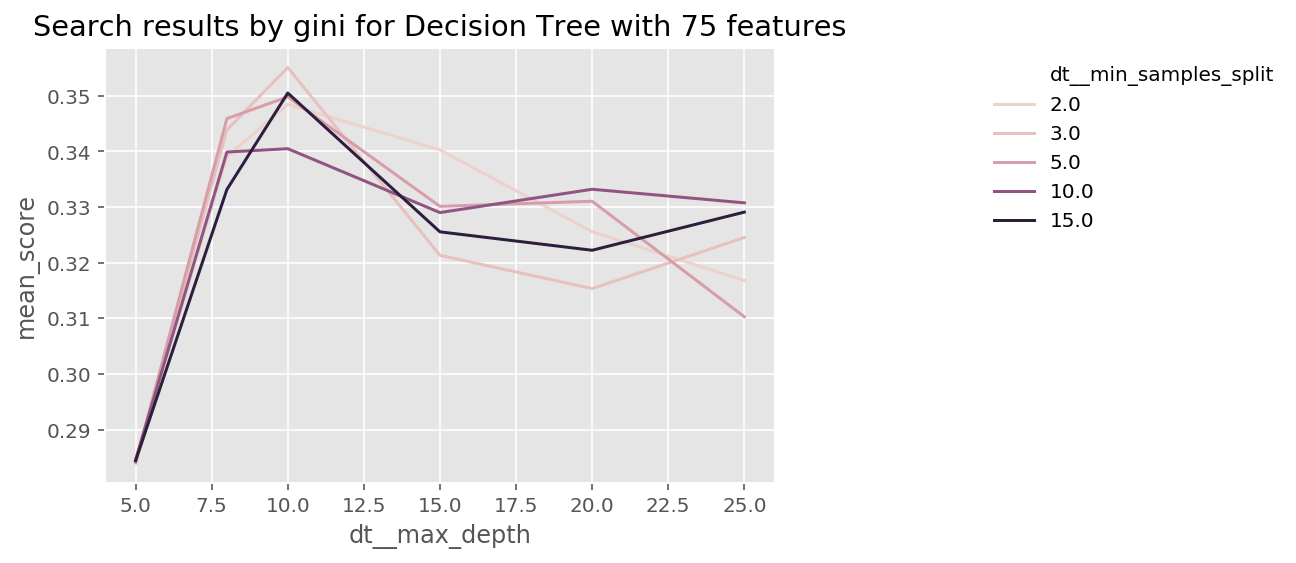

In [81]:
results_dt = results_dt[(results_dt['dt__criterion'] == 'gini') & (results_dt['rfi_fs__n_features_'] == 75)]
results_dt['mean_score'] = results_dt['mean_score'].astype(np.number)
results_dt['dt__max_depth'] = results_dt['dt__max_depth'].astype(np.number)
results_dt['dt__min_samples_split'] = results_dt['dt__min_samples_split'].astype(np.number)

plt.title('Search results by gini for Decision Tree with 75 features')
sns.lineplot(x='dt__max_depth', 
             y='mean_score', 
             hue='dt__min_samples_split',
             ci=None,
             legend='full',
             data=results_dt)
plt.legend(bbox_to_anchor=(1.1, 1), 
           facecolor="white", 
           frameon=False)

Based on the search results, we can see the optimal parameters of the decision tree model. The best search results occur with 75 descriptive features and gini as split criterion. According to the curve shape, we could investigate the behaviour after increasing the maximum depth with 5 minimum samples per split as the mean score is increasing with this set up. But we use the maximum of 10 to avoid further overfitting.

Finally, we can train our optimal classification models on the entire training dataset.

In [82]:
knn_model = KNeighborsClassifier(**gs_knn.best_estimator_[1].get_params()).fit(X_train[:, fs_knn_indices], y_train)

In [83]:
dt_model = DecisionTreeClassifier(**gs_dt.best_estimator_[1].get_params()).fit(X_train[:, fs_dt_indices], y_train)

## Evaluation <a id='evaluation'></a>

In this section, we compare the prediction results focusing on the f1 score for both models. Furthermore, we undertake the analysis of the activity predictions by considering the confusion matrix and classification report.

In [84]:
knn_preds = knn_model.predict(X_test[:, fs_knn_indices])

In [85]:
dt_preds = dt_model.predict(X_test[:, fs_dt_indices])

In [86]:
print('KNN f1-score:', f1_score(y_test, knn_preds, average='macro').round(3))

KNN f1-score: 0.339


In [87]:
print('DT f1-score:', f1_score(y_test, dt_preds, average='macro').round(3))

DT f1-score: 0.308


The k-nearest neighbors approach outperforms the decision tree model considering the f1 score. Let's crreate the confusion matrix of both models and visualize them as heatmap.

In [88]:
from sklearn.metrics import confusion_matrix, classification_report
knn_cm = confusion_matrix(y_test, knn_preds)
dt_cm = confusion_matrix(y_test, dt_preds)

In [89]:
df_knn_cm = pd.DataFrame(knn_cm, index = [i for i in "1234567"],
                         columns = [i for i in "1234567"])

df_dt_cm = pd.DataFrame(dt_cm, index = [i for i in "1234567"],
                        columns = [i for i in "1234567"])

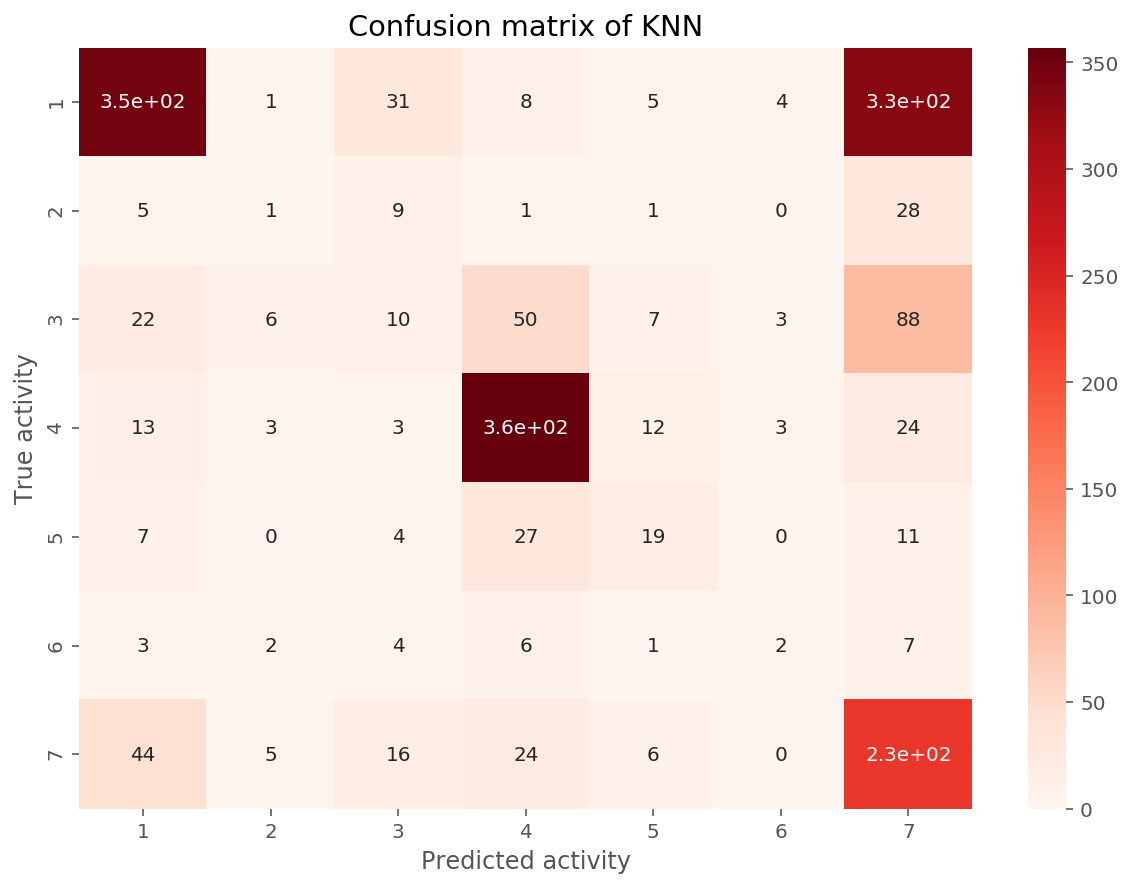

In [90]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Confusion matrix of KNN')
ax = sns.heatmap(df_knn_cm, annot=True, cmap='Reds', ax=ax)
ax.set_ylabel('True activity')
ax.set_xlabel('Predicted activity')
plt.show()

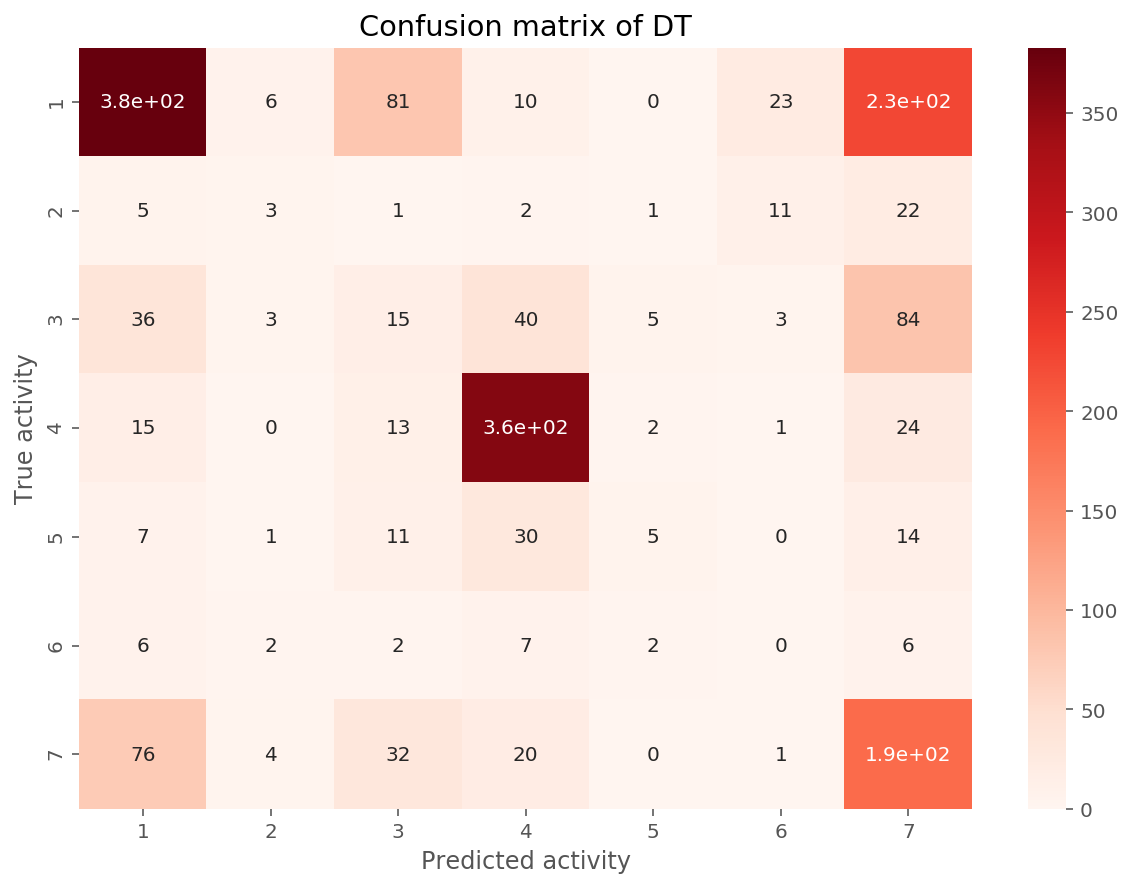

In [91]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Confusion matrix of DT')
ax = sns.heatmap(df_dt_cm, annot=True, cmap='Reds', ax=ax)
ax.set_ylabel('True activity')
ax.set_xlabel('Predicted activity')
plt.show()

Let's print the classification reports which include various important performance metrics such as precision, recall and f1 score.

In [92]:
print(classification_report(y_test, knn_preds))

              precision    recall  f1-score   support

           1       0.79      0.48      0.59       730
           2       0.06      0.02      0.03        45
           3       0.13      0.05      0.08       186
           4       0.75      0.86      0.80       415
           5       0.37      0.28      0.32        68
           6       0.17      0.08      0.11        25
           7       0.32      0.71      0.44       324

    accuracy                           0.54      1793
   macro avg       0.37      0.35      0.34      1793
weighted avg       0.58      0.54      0.53      1793



In [93]:
print(classification_report(y_test, dt_preds))

              precision    recall  f1-score   support

           1       0.73      0.52      0.61       730
           2       0.16      0.07      0.09        45
           3       0.10      0.08      0.09       186
           4       0.77      0.87      0.81       415
           5       0.33      0.07      0.12        68
           6       0.00      0.00      0.00        25
           7       0.34      0.59      0.43       324

    accuracy                           0.53      1793
   macro avg       0.35      0.31      0.31      1793
weighted avg       0.56      0.53      0.53      1793



Finally, let's visualize the f1 score for each activity to get an overview about the prediction performance for each of the target levels.

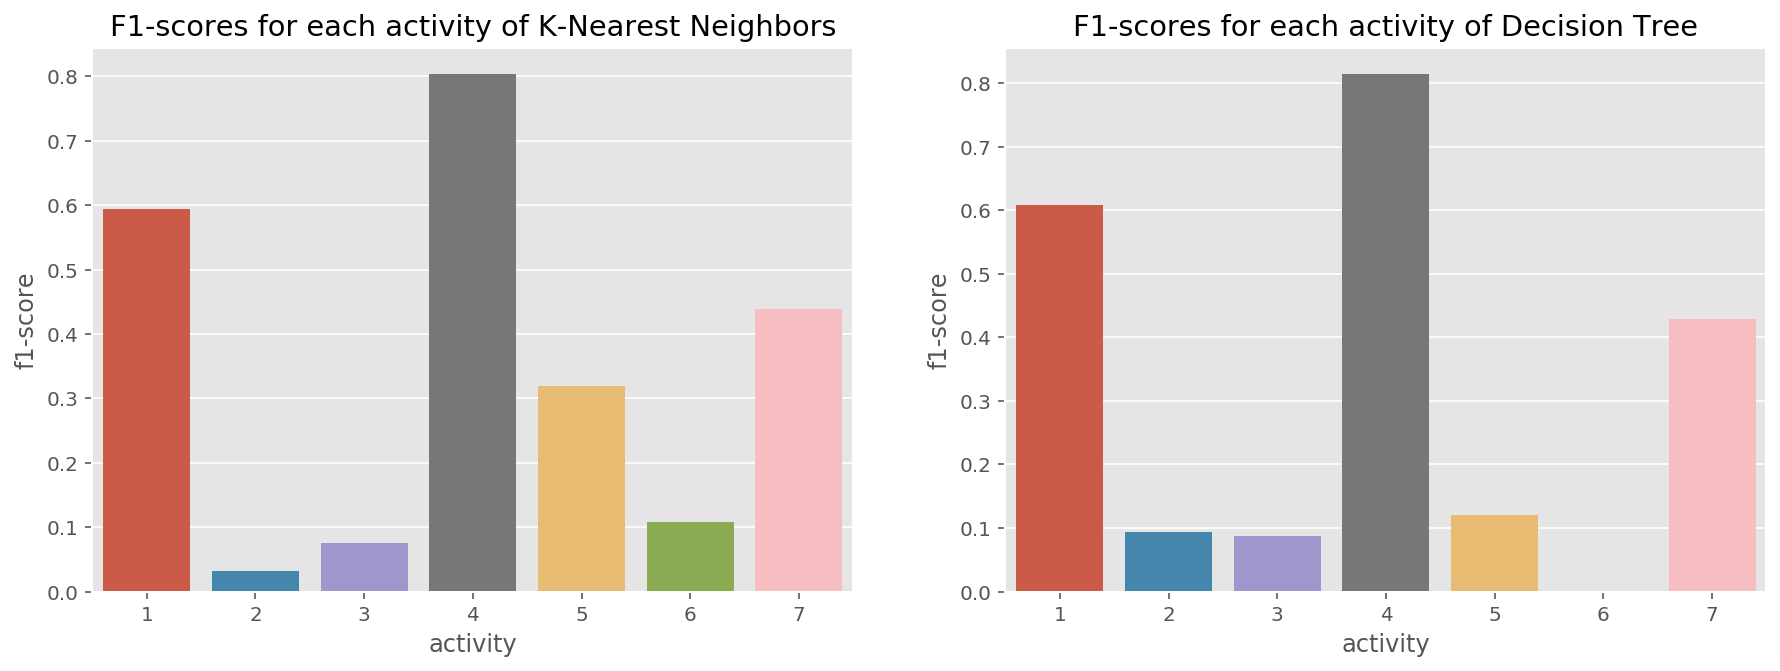

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_title('F1-scores for each activity of K-Nearest Neighbors')
sns.barplot(['1', '2', '3', '4', '5', '6', '7'], f1_score(y_test, knn_preds, average=None), ax=axs[0])
axs[0].set_ylabel('f1-score')
axs[0].set_xlabel('activity')
axs[1].set_title('F1-scores for each activity of Decision Tree')
sns.barplot(['1', '2', '3', '4', '5', '6', '7'], f1_score(y_test, dt_preds, average=None), ax=axs[1])
axs[1].set_ylabel('f1-score')
axs[1].set_xlabel('activity')
plt.show()

We observe low f1-scores especially for the activities `2`, `3`, `5` and `6` what can be caused by the high imbalance of the dataset whereby **2 = 2.5%**, **3 = 11.3%**, **5 = 2.7%** and **6 = 2.5%** are the amount of levels in the entire dataset. According to the confusion matrix, the activities `1`, `3` and `7` are highly connected to each other by misclassification. This can be caused  by similar motion patterns for these activities. For example, **1 = Working at Computer**, **3 = Standing** and **7 = Talking while Standing** seems to have equal acceleration values as the participant is standing/sitting in the same position. The decision tree shows moderately worse results in particular at the classification of the activities `5` and `6`.

## Summary <a id='summary'></a>

The k-nearest neighbors classifier produces the best f1 score (`33.9%`) and outperformed the decision tree both for the training set and test set. Thereby, the model used the best `75` descriptive features which were created with a sliding window approach with a length of 156 samples (~3 seconds). The optimal hyperparameters for the k-nearest neighbors model were `n_neigbhors=5`,  `weights=distance` and `p=1` for the distance measure.

However, we received overfitting for both the k-nearest neighbors and decision tree by comparing the train and test scores during grid search (for reducing the running time, the train score is removed from this notebook). This overfitting might be caused by the different motion patterns of the participants. One possible solution for reducing overfitting can be to gather more sensor data from the participants. Moreover, further constraining of the classification models such as the pruning of the decision tree can lead to less overfitting.

Besides the imbalanced dataset, another reason for the weak performance can be caused by the nature of equal motion patterns for some activities. For example, `Working at Computer`, `Talking while Standing` and `Standing` seems to have equal acceleration values as the participant is standing/sitting in the same position. Moreover, the activity `Standing Up, Walking and Going updown stairs` could be a combination of other activities. An aggregation of this target levels to one activity could increase the model performance but this approach depends on the overall project objective and whether it is necessary to distinguish among these activities.

The selection of 75 out of 78 descriptive features shows the best model performance so we could reach more accurate predictions by including more features during the feature engineering process. However, this poses a time consuming and complex task. Approaches such as convolutional neural networks (CNN) and recurrent neural networks (RNN) may outperform the basic machine learning models since the feature extraction is performed automatically during the learning process of the neural networks. Hence, further work can include the comprehend investigation of deep learning such as recurrent neural networks.

Considering both models, we recommend to use the k-nearest neighbors approach over decision trees as it have shown that minority activities of unseen participants can be predicted more accurately. This can be caused by the decision trees overfitting which is an important practical difficulty and disadvantage of these models. Setting more contraints and approaches such as pruning might reduce this issue but can pose a time intensive and difficult task. Futhermore, new data and motion patterns can be easily added to the k-nearest neighbors model which is an advantage for concept drifts and including further persons in a human activity recognition system.

However, k-nearest neighbors as lazy learner can require long time for prediction results which must be taken into account by creating human activity recognition systems. Especially the user experience can suffer from delayed activity recognition. Hence, the usage of k-nearest neighbors must meet the time requirements which depend on the underlying project.

## References <a id='references'></a>

[1] P. Casale, O. Pujol and P. Radeva, "Personalization and user verification in wearable systems using biometric walking patterns", Personal and Ubiquitous Computing, vol. 16, no. 5, pp. 563-580, 2011. Available: 10.1007/s00779-011-0415-z [Accessed 31 May 2020].

[2] J. Brownlee, "A Gentle Introduction to a Standard Human Activity Recognition Problem", Machine Learning Mastery, 2018. [Online]. Available: https://machinelearningmastery.com/how-to-load-and-explore-a-standard-human-activity-recognition-problem/. [Accessed: 31- May- 2020].

[3] sepehr125, "sepehr125/activity-recognition", GitHub, 2016. [Online]. Available: https://github.com/sepehr125/activity-recognition. [Accessed: 31- May- 2020].

[4] W. Weckesser, "Creating lowpass filter in SciPy - understanding methods and units", Stack Overflow, 2015. [Online]. Available: https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units. [Accessed: 01- Jun- 2020].

[5] P. Casale, O. Pujol and P. Radeva, "Human Activity Recognition from Accelerometer Data Using a Wearable Device", Pattern Recognition and Image Analysis, pp. 289-296, 2011. Available: 10.1007/978-3-642-21257-4_36 [Accessed 2 June 2020].

[6] V. Aksakalli, "Case Study: Predicting Income Status", www.featureranking.com, 2020. [Online]. Available: https://www.featureranking.com/tutorials/machine-learning-tutorials/case-study-predicting-income-status/. [Accessed: 25- May- 2020].